# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Unni Kohonen - [unni.kohonen@ulb.be](mailto:student1@ulb.ac.be) - Student ID 000554057
### Mohamed El Marsse - [Mohamed El Marsse](mailto:student2@ulb.ac.be) - Student ID 000408195
### Edwige Loems - [edwige.loems@ulb.be](mailto:student3@ulb.ac.be) - Student ID 000401457

### Video presentation:  https://youtu.be/OYCj0rw4tkE

## Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines


# Introduction


Vaccination is a significant tool in the public health domain and having a better understanding of the vaccination among the population is key.  The driven data competition in which we are taking part is about predicting, based on the responses from the National 2009 H1N1 Flu Survey, how likely individuals are to receive their H1N1 and seasonal flu vaccines. We will predict two distinct probabilities for the h1n1_vaccine and the seasonal_vaccine. [1]



# Libraries and functions

In [175]:
#Install the packages if needed
# Importing the libraries
library(xgboost)
library(nnet) 
library(rpart)
library(e1071)
library(glmnet)
library(tidyverse)
library(ggplot2)
library(randomForest)

set.seed(1)

#The ggplot2 library was used to plot the graphs indicating the proportion of h1n1 and seasonal vaccine among the population. [4]

In [2]:
options(warn = -1)

We developed our own metric functions. A function called evaluative_matrix that takes the  predicted values and the actual values as inputs and outputs the True positive rate, False positive rate, accuracy, F1 measure. This functions constructs a confusion matrix from the inputs and through calculation to determine TPR,recal,precission..
Another function that we developed is plot a ROC curve by using a similar metrics as the above.

In [3]:
#function to evaluate the models
evaluative_matrix <- function(Y_pred, Y_real) {
  
  confusion_matrix <- table(Y_real, Y_pred)
  
  precision <- confusion_matrix[4] / (confusion_matrix[4] + confusion_matrix[2])
  recall <- confusion_matrix[4] / (confusion_matrix[4] + confusion_matrix[3])
  accuracy <- (confusion_matrix[1] + confusion_matrix[4]) / sum(confusion_matrix)
  F1 <- 2 * ((precision * recall) / (precision + recall))
  TPR <- recall
  FPR <- confusion_matrix[2] / (confusion_matrix[2] + confusion_matrix[1])
  
  c(accuracy, F1, TPR, FPR)
}

#either draws the roc curve or returns FPR and TPR values
get_roc <- function(Y_pred,Y_real,var1,var2, p=T){
  thresholds <- seq(0,0.99,0.05)
  FPR <- c()
  TPR <- c()
  
  for(threshold in thresholds){
    Y_hat <- ifelse(Y_pred > threshold,var1,var2) 
    
    confusion_matrix <- table(Y_hat,Y_real)
    
    if(dim(confusion_matrix)[1] < 2){ 
      if(var2 %in% rownames(confusion_matrix)){
        confusion_matrix <- rbind(confusion_matrix,c(0,0))
        rownames(confusion_matrix)[2] <- var1
      }
      if(var1 %in% rownames(confusion_matrix)){
        confusion_matrix <- rbind(c(0,0),confusion_matrix)
        rownames(confusion_matrix)[1] <- var2
      }
    }
    
    FP <- confusion_matrix[2,1]
    TP <- confusion_matrix[2,2]
    N_N <- sum(confusion_matrix[,1]) # Total number of nonvaccine
    N_P <- sum(confusion_matrix[,2]) # Total number of vaccine
    
    FPR <- c(FPR,FP/N_N)
    TPR <- c(TPR,TP/N_P)
  }
    
  #if p is true, a plot is drawn, orherwise only the FPR and TPR are returned
  if(p) {
      plot(FPR,TPR)
      lines(FPR,TPR,col="blue")
      lines(thresholds,thresholds,lty=2)
      title("ROC Curve")
      axis(1, at=seq(from = 0, to = 1, by = 0.2))
      axis(2, at=seq(from = 0, to = 1, by = 0.2))
  } else {
      list("tpr" = TPR, "fpr" = FPR)
  }
}

#function to evaluate the accuracy of the feature selection methods. 
#This function is a direct result of the materials referenced in [4]. 
#A confusion matrix is created and is a table displaying how often the algorithm correctly or incorrectly predicted the outcome. 
#The confusion matrix is then used to calculate the accuracy of the methods. 
#We compared the accuracy of each methods depending to the number of features that was selected.
get_accuracy <- function(prediction, test) {
    cm <- table(prediction, test)
    accuracy <- sum(cm[1], cm[4]) / sum(cm[1:4])
}

# Data overview

From the driven data website, we obtained two datasets : the training_set_features (renamed data) and the training_set_labels (renamed labels). From the driven data website, we obtained two datasets : the training_set_features (renamed data) and the training_set_labels (renamed labels). 

In [4]:
#loading data
data <- read.csv("./training_set_features.csv")
labels <- read.csv("./training_set_labels.csv")

## Data exploration 

From the driven data website, we obtained two datasets : the training_set_features and the training_set_labels. 

In [5]:
#structure, summary and head of the dataset data
str(data) #structure of the data
summary(data)#summary
head(data) # get first rows

'data.frame':	26707 obs. of  36 variables:
 $ respondent_id              : int  0 1 2 3 4 5 6 7 8 9 ...
 $ h1n1_concern               : int  1 3 1 1 2 3 0 1 0 2 ...
 $ h1n1_knowledge             : int  0 2 1 1 1 1 0 0 2 1 ...
 $ behavioral_antiviral_meds  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ behavioral_avoidance       : int  0 1 1 1 1 1 0 1 1 1 ...
 $ behavioral_face_mask       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ behavioral_wash_hands      : int  0 1 0 1 1 1 0 1 1 0 ...
 $ behavioral_large_gatherings: int  0 0 0 1 1 0 0 0 1 1 ...
 $ behavioral_outside_home    : int  1 1 0 0 0 0 0 0 1 0 ...
 $ behavioral_touch_face      : int  1 1 0 0 1 1 0 1 1 1 ...
 $ doctor_recc_h1n1           : int  0 0 NA 0 0 0 0 1 0 0 ...
 $ doctor_recc_seasonal       : int  0 0 NA 1 0 1 0 0 0 0 ...
 $ chronic_med_condition      : int  0 0 1 1 0 0 0 1 0 1 ...
 $ child_under_6_months       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ health_worker              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ health_insurance           : int  1 1

 respondent_id    h1n1_concern   h1n1_knowledge  behavioral_antiviral_meds
 Min.   :    0   Min.   :0.000   Min.   :0.000   Min.   :0.00000          
 1st Qu.: 6676   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:0.00000          
 Median :13353   Median :2.000   Median :1.000   Median :0.00000          
 Mean   :13353   Mean   :1.618   Mean   :1.263   Mean   :0.04884          
 3rd Qu.:20030   3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:0.00000          
 Max.   :26706   Max.   :3.000   Max.   :2.000   Max.   :1.00000          
                 NA's   :92      NA's   :116     NA's   :71               
 behavioral_avoidance behavioral_face_mask behavioral_wash_hands
 Min.   :0.0000       Min.   :0.00000      Min.   :0.0000       
 1st Qu.:0.0000       1st Qu.:0.00000      1st Qu.:1.0000       
 Median :1.0000       Median :0.00000      Median :1.0000       
 Mean   :0.7256       Mean   :0.06898      Mean   :0.8256       
 3rd Qu.:1.0000       3rd Qu.:0.00000      3rd Qu.:1.0000       
 Max.   :1

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,0,1,0,0,0,0,0,0,1,1,⋯,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0,0,,
2,1,3,2,0,1,0,1,0,1,1,⋯,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0,0,pxcmvdjn,xgwztkwe
3,2,1,1,0,1,0,0,0,0,0,⋯,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2,0,rucpziij,xtkaffoo
4,3,1,1,0,1,0,1,1,0,0,⋯,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0,0,,
5,4,2,1,0,1,0,1,1,0,1,⋯,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1,0,wxleyezf,emcorrxb
6,5,3,1,0,1,0,1,0,0,1,⋯,"<= $75,000, Above Poverty",Married,Own,Employed,atmpeygn,"MSA, Principle City",2,3,saaquncn,vlluhbov


The dataset data contains the answers from the 26706 people that answered the survey. The data frame contains 36 columns that correspond to the respondent_id and 35 features. 

The display of the summary and the head of the data enable us to observe that we have categorical data that we will need to adress in the preprocessing section. We can also observe that some categories have NA’s. 

In [6]:
#summary of the dataset labels 
summary(labels)

 respondent_id    h1n1_vaccine    seasonal_vaccine
 Min.   :    0   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 6676   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :13353   Median :0.0000   Median :0.0000  
 Mean   :13353   Mean   :0.2125   Mean   :0.4656  
 3rd Qu.:20030   3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :26706   Max.   :1.0000   Max.   :1.0000  

The data frame labels indicates if the respondent got the h1n1 vaccine or the seasonal vaccine. 

The h1n1_vaccine and seasonal_vaccine will be used as the output variables for the feature selection methods and models. 

### Distribution of the target variables 

Distribution of h1n1 and seasonal vaccine in the population. We can observe that 5674 out the 26706 respondent got the h1n1 vaccine and 12435 respondent got the seasonal vaccine. The distribution is displayed on the barplots below. 

In [7]:
#Distribution of the target variables 

#Creation of the data frame for the h1n1 vaccine
df1_h1n1 <- table(labels$h1n1_vaccine)
#df1_h1n1
df2_h1n1 <- data.frame(df1_h1n1, stringsAsFactors = TRUE)
#df2_h1n1

#creation of the data frame for the seasonal vaccine
df1_seasonal <- table(labels$seasonal_vaccine)
#df1_seasonal
df2_seasonal <- data.frame(df1_seasonal, stringsAsFactors = TRUE)
#df2_seasonal

#Changing the names of the columns
colnames(df2_h1n1) <- c('h1n1_vaccine', 'Proportion_of_the_h1n1_vaccine_in_the_population')
colnames(df2_seasonal) <- c('Seasonal_vaccine', 'Proportion_of_the_seasonal_vaccine_in_the_population')
df2_h1n1
df2_seasonal

h1n1_vaccine,Proportion_of_the_h1n1_vaccine_in_the_population
<fct>,<int>
0,21033
1,5674


Seasonal_vaccine,Proportion_of_the_seasonal_vaccine_in_the_population
<fct>,<int>
0,14272
1,12435


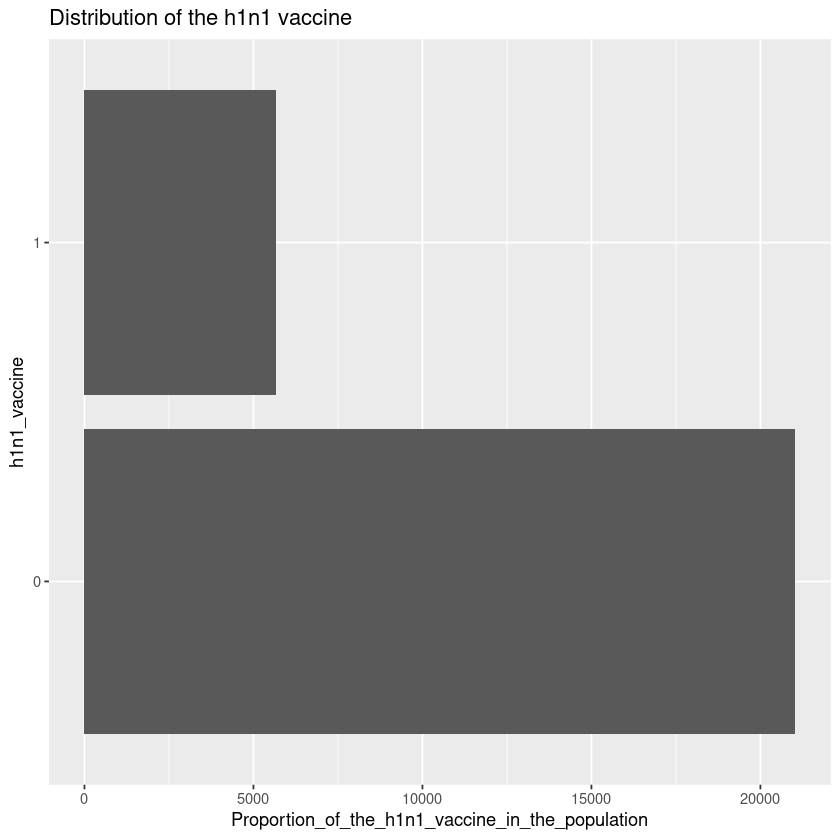

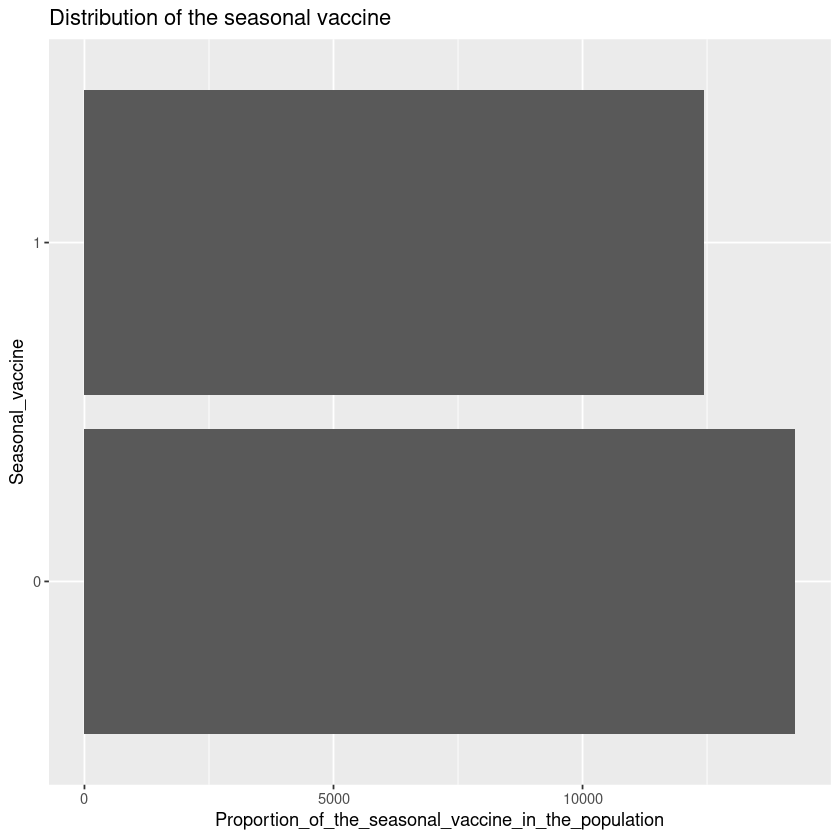

In [8]:
#Barplot
#The code for the barplot is from the STHDA
#(Statistical Tools For High-Throughput Data Analysis) website [3]. 

#Plot of the proportion of the h1n1 vaccine in the population 
# Barplot basique
p<-ggplot(data=df2_h1n1, aes(x=h1n1_vaccine, y=Proportion_of_the_h1n1_vaccine_in_the_population)) +
  geom_bar(stat="identity")
# Barplot horizontal
p + coord_flip()+ ggtitle('Distribution of the h1n1 vaccine')

#Plot of the proportion of the seasonal vaccine in the population 
# Barplot basique
p<-ggplot(data=df2_seasonal, aes(x=Seasonal_vaccine, y=Proportion_of_the_seasonal_vaccine_in_the_population)) +
  geom_bar(stat="identity")
# Barplot horizontal
p + coord_flip()+ ggtitle('Distribution of the seasonal vaccine')

## Description of the features in the dataset

Here is a list of the features provided in the dataset. This information is displayed on the driven data website [2]. 
The first column respondent_id is a unique and random identifier.

For all binary variables: 0 = No; 1 = Yes.

* h1n1_concern - Level of concern about the H1N1 flu.
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.

* h1n1_knowledge - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.

* behavioral_antiviral_meds - Has taken antiviral medications. (binary)

* behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)

* behavioral_face_mask - Has bought a face mask. (binary)

* behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)

* behavioral_large_gatherings - Has reduced time at large gatherings. (binary)

* behavioral_outside_home - Has reduced contact with people outside of own household. (binary)

* behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)

* doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)

* doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)

* chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

* child_under_6_months - Has regular close contact with a child under the age of six months. (binary)

* health_worker - Is a healthcare worker. (binary)

* health_insurance - Has health insurance. (binary)

* opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness.
    + 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

* opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
    + 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
    
* opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.
    + 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
    
* opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.
    + 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

* opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
    + 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
    
* opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.
    + 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
    
* age_group - Age group of respondent.

* education - Self-reported education level.

* race - Race of respondent.

* sex - Sex of respondent.

* income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.

* marital_status - Marital status of respondent.

* rent_or_own - Housing situation of respondent.

* employment_status - Employment status of respondent.

* hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.

* census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

* household_adults - Number of other adults in household, top-coded to 3.

* household_children - Number of children in household, top-coded to 3.

* employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.

* employment_occupation - Type of occupation of respondent. Values are represented as short random character strings."

# Data preprocessing


The preprocessing of our data will impact the performance of our models. 
The datasets that were provided for the competition have missing values. We have identified the missing values and replaced them prior to implementing the model selection procedure. For the feature selection, we will assess two filter methods (correlation with the output and mRMR) and one wrapper method (forward selection). 


## Feature engineering & Missing value imputation 

We observe in the data overview section that the data that we have have categorical data and NA’s. They have to be removed from the datasets before using the datasets as input data for the predictive models. 

We transformed the categorical variables into numeric values. We deleted the categories that had a percentage of NA’s above 10% and we replaced the NA with the most frequent value in that column. 

In [9]:
#Some variables of our dataset are categorical data. 
#The missing values appears as empty strings instead of NA’s.

#Replacing empty strings with NAs
data <- data.frame(lapply(data, function(x) ifelse(x == '', NA, x)))

In [10]:
#Transforming character class columns to integers
data <- data.frame(lapply(data, function(x) if(class(x)=="character") { as.factor(x) } else { x } ))
data <- data.frame(lapply(data, function(x) if(class(x)=="factor") { as.numeric(x) } else { x } ))               

In [11]:
#Displaying % of missing values per column
NA_percent <- apply(data, 2, function(x)(sum(is.na(x))/nrow(data))*100)
sort(NA_percent, decreasing = TRUE)

employment_occupation         employment_industry 
                 50.4362152                  49.9120081 
           health_insurance              income_poverty 
                 45.9579885                  16.5612012 
           doctor_recc_h1n1        doctor_recc_seasonal 
                  8.0877673                   8.0877673 
                rent_or_own           employment_status 
                  7.6459355                   5.4779646 
             marital_status                   education 
                  5.2720261                   5.2682817 
      chronic_med_condition        child_under_6_months 
                  3.6357509                   3.0703561 
              health_worker opinion_seas_sick_from_vacc 
                  3.0104467                   2.0107088 
          opinion_seas_risk opinion_seas_vacc_effective 
                  1.9245891                   1.7298836 
opinion_h1n1_sick_from_vacc opinion_h1n1_vacc_effective 
                  1.4790130                   1.4640356 
          opinion_h1n1_risk            household_adults 
                  1.4528026                   0.9323398 
         household_children        behavioral_avoidance 
                  0.9323398                   0.7788220 
      behavioral_touch_face              h1n1_knowledge 
                  0.4792751                   0.4343431 
               h1n1_concern behavioral_large_gatherings 
                  0.3444790                   0.3257573 
    behavioral_outside_home   behavioral_antiviral_meds 
                  0.3070356                   0.2658479 
      behavioral_wash_hands        behavioral_face_mask 
                  0.1572621                   0.0711424 
              respondent_id                   age_group 
                  0.0000000                   0.0000000 
                       race                         sex 
                  0.0000000                   0.0000000 
             hhs_geo_region                  census_msa 
                  0.0000000                   0.0000000

Some variables have a high percentage of missing values. The variables with the highest percentage of missing values will be deleted. 

We reduced the number of features from 35 to 31 (the respondent_id is not considered as a feature). Some of the features that are left still have missing values. The missing values will be replaced with the most frequent value in that column. 

Replacing the missing values with the mean of the column was considered. This method was problematic for the binary categories. We also considered replacing the missing values with the median of the column (median imputation) but did not chose that option because our data does not have a lot of outliers. 

In [12]:
#removing columns with % of NA above 10%
ncol(data)
data <- data[,which(colMeans(!is.na(data))>.9)]
ncol(data) 

[1] 36

[1] 32

We managed to use decision trees to predict the missing values in the data but unfortunately, replacing the NAs with the predicted values wasn't functional. The attempt is commented below.

In [13]:
#replacing NA with Rpart

#predict_NAs <- function(col_name) {
#    all = data
#    formula <- as.formula(paste(col_name, "~ ."))
#    class_mod <- rpart(formula, data=all[!is.na(all[,col_name]), ], method='class', na.action=na.omit)
#
#    column_pred <- predict(class_mod, all[is.na(data[,col_name]), ])
#
#    column_pred = ifelse(column_pred>.5,1,0)
#    column_pred = data.frame(column_pred)
#    column_pred$column = ifelse(column_pred$X1==1,1,2)
#    column_pred$respondent_id = data.frame(as.integer(rownames(column_pred)))
#
#    all <- data.frame(lapply(all, function(x) ifelse(is.na(x), 0, x)))
#
#    var1 = column_pred$respondent_id
#    var12 = var1$as.integer.rownames.column_pred..
#    var2 = column_pred$column
#
#    all[,col_name][match(var12, all$respondent_id)-1] <- var2
#    all
#}

#NA_cols <- names(which(colSums(is.na(data))>0))

#for (col_name in NA_cols) {
#    data[,col_name]<-predict_NAs(col_name)[,col_name]
#}

As we encountered issues in the previouss step, we resorted to assigning the mode to the missing values in our data

In [14]:
#replacing the NA with the most frequent value in that column
calc_mode <- function(x){
#  
  # List the distinct / unique values
  distinct_values <- unique(x)
  
  # Count the occurrence of each distinct value
  distinct_tabulate <- tabulate(match(x, distinct_values))
  
  # Return the value with the highest occurrence
  distinct_values[which.max(distinct_tabulate)]
}


data<-data.frame(apply(data,2,function(x) ifelse(is.na(x),calc_mode(x),x)))

### Normalisation

The objective of the normalization is to transform the features into the same range. We considered that the different ranges in which our data fits are close and that our datasets does not need to be normalized. 


## Feature selection 

We considered three feature selection methods (correlation with the output, mRMR and forward selection). The code and the documentation about the feature selection are from the practical 5 of the course with light modifications (Practical 5 - Ensemble and feature selection with solutions). 

The filter methods are preprocessing methods. They attempt to assess the merits of features from the data, ignoring the effects of the selected feature subset on the performance of the learning
algorithm. Examples are methods that select variables by ranking them through compression techniques (like PCA), or by computing correlation or a more advanced similarity measure such as minimum redundancy maximum relevance (mRMR) with the output.

The wrapper methods assess subsets of variables according to their usefulness to a given predictor. The method conducts a search for a good subset using the learning algorithm itself as part of the evaluation function. The problem boils  down to a problem of stochastic state space search. Example are the stepwise methods proposed in linear regression analysis.

For each method, we obtained different metrics to chose the feature method that we will use. We compared the accuracy, CV error and standard deviation of each methods.  

The accuracy is the accuracy of the predictions. It summaries the performance of the prediction algorithm depending on the number of features that we selected.  The CV error is the cross-valuation error (mean square error). The more the model is close to 0, the more the predictions match the observed data.  The standard deviation gives information about the variability of the data. 

We performed two distinct features selection for the h1n1 vaccine and the seasonal vaccine. We used the same input variables but chose either the h1n1_vaccine or seasonal_vaccine as the output variable. We believe that separating the feature selection method for the two predictions will improve the performance of our model. 


## Feature selection - H1N1 vaccine

[1] 0.2124537

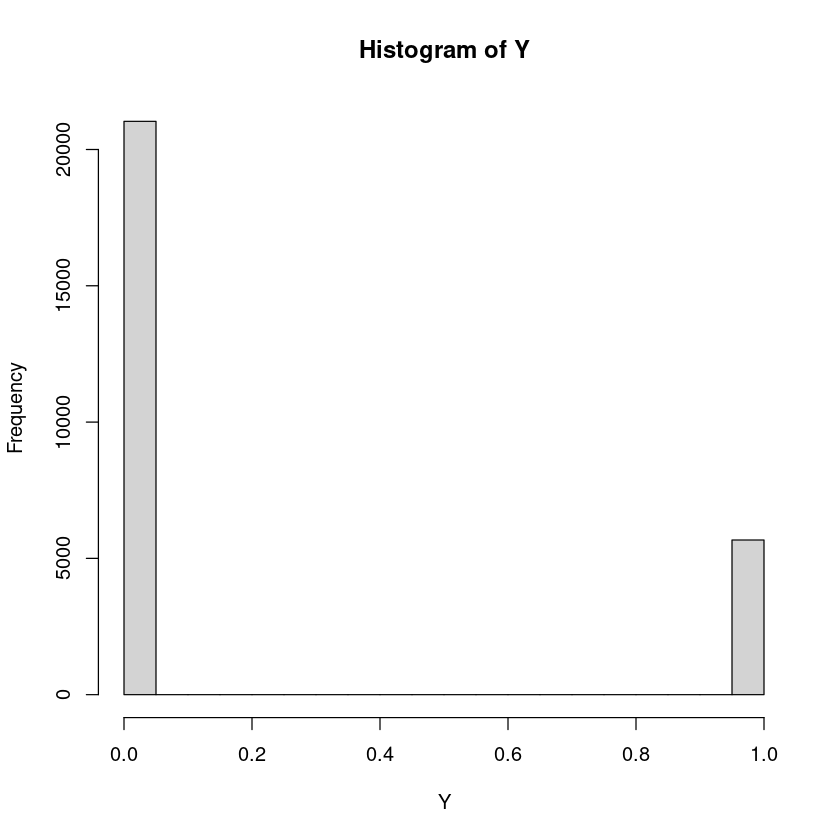

In [15]:
#Input and Output variables.
#The input variables is the data. We remove the respondent_id column because it is not considered a feature. 
#The output variable is the h1n1_vaccine variable for the labels dataset.

X <- data  #using data without labels
X <- subset(data, select = -c(respondent_id))
Y <- labels[,"h1n1_vaccine"] #H1N1 vaccine

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

hist(Y)
mean(Y) #check if it correspond to the expected value 

## Feature selection - Filter methods (H1N1 vaccine)

We used two filter methods : the correlation with the output method and the mRMR method. 

### Correlation with the output (H1N1 vaccine)

The correlation with the output methods performs selection by keeping the most correlated variables with the output. The code below is the same as the one from the practical 5. We added the accuracy function. The accuracy was calculated multiple times with a number of feature selected that is different.

In [16]:
# correlation with the output
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_31 <- get_accuracy(Y_hat_ts, Y_ts)
    }
}  

# The CV error and the standard deviation are calculated for all the features. 
# The values of the CV error and standard deviation will be compared between the three models.  
print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

#Accuracy if we select 31 features 
accuracy_31

 [1] "#Features:  1  ; CV error= 0.1414  ; std dev= 0.0028" 
 [2] "#Features:  2  ; CV error= 0.1325  ; std dev= 0.0031" 
 [3] "#Features:  3  ; CV error= 0.1282  ; std dev= 0.0034" 
 [4] "#Features:  4  ; CV error= 0.1278  ; std dev= 0.0033" 
 [5] "#Features:  5  ; CV error= 0.1275  ; std dev= 0.0033" 
 [6] "#Features:  6  ; CV error= 0.1275  ; std dev= 0.0033" 
 [7] "#Features:  7  ; CV error= 0.1257  ; std dev= 0.0032" 
 [8] "#Features:  8  ; CV error= 0.1254  ; std dev= 0.0032" 
 [9] "#Features:  9  ; CV error= 0.1252  ; std dev= 0.0033" 
[10] "#Features:  10  ; CV error= 0.1251  ; std dev= 0.0033"
[11] "#Features:  11  ; CV error= 0.125  ; std dev= 0.0033" 
[12] "#Features:  12  ; CV error= 0.125  ; std dev= 0.0034" 
[13] "#Features:  13  ; CV error= 0.125  ; std dev= 0.0034" 
[14] "#Features:  14  ; CV error= 0.125  ; std dev= 0.0033" 
[15] "#Features:  15  ; CV error= 0.125  ; std dev= 0.0033" 
[16] "#Features:  16  ; CV error= 0.1249  ; std dev= 0.0033"
[17] "#Features:  17  ; 

[1] 0.5

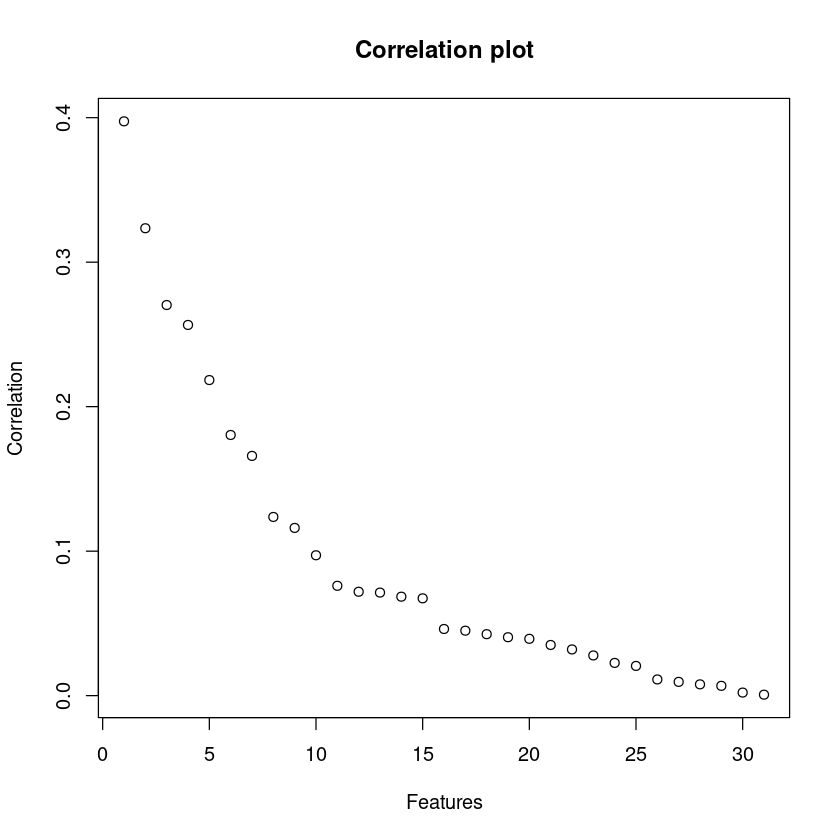

In [17]:
#Correlation plot
correlation_plot <- correlation_vector[order(correlation_vector[ , 1], decreasing = TRUE), ]
plot(correlation_plot, xlab='Features', ylab='Correlation', main='Correlation plot')

The correlation plot indicates the correlation of our 31 variables with the output. The features are ranked according to the value of the correlation. 

The best features have the highest correlation. The features that we can remove from the dataset have the lowest correlation. 

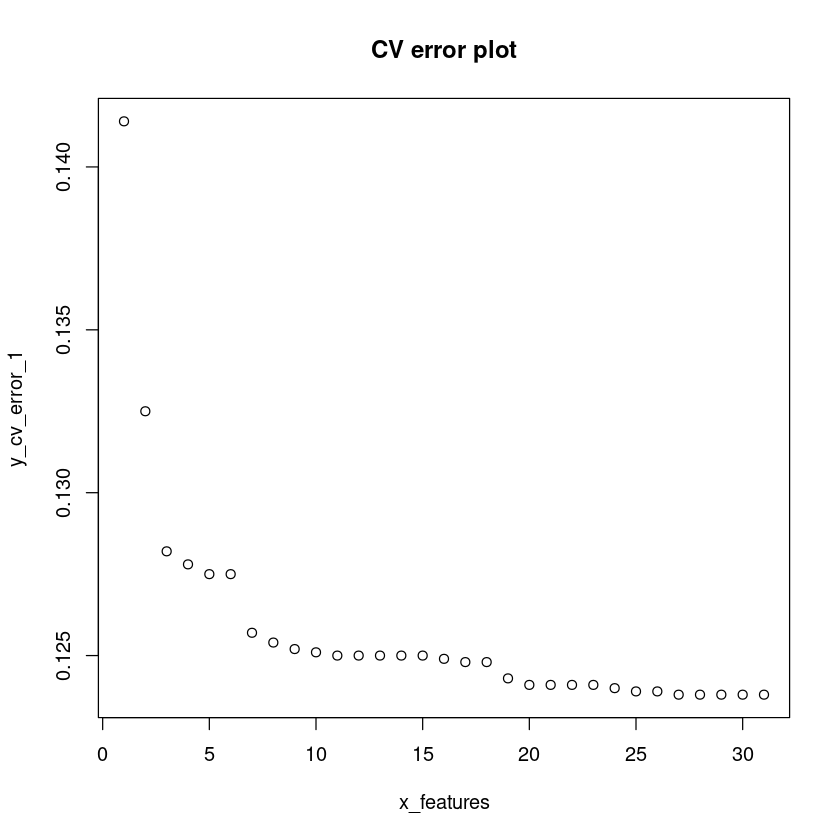

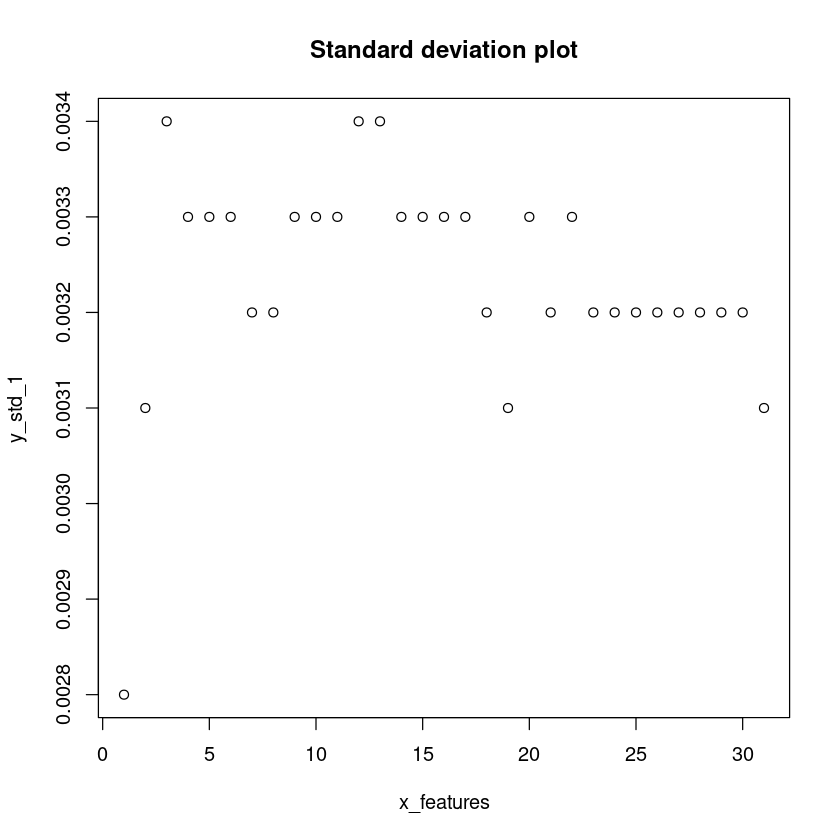

In [18]:
# CV error plot and Standard deviation plot 
x_features <- c(1:n)
y_cv_error_1 <- round(apply(CV_err,1,mean),digits=4)
plot(x_features, y_cv_error_1, main='CV error plot')

y_std_1 <- round(apply(CV_err,1,sd),digits=4)
plot(x_features, y_std_1, main='Standard deviation plot')

The CV error plot indicates the CV error for all the features ranked by their correlation value. 

The standard deviation plot indicates the variability of the data for each feature. 

We can observe that the CV error is higher for the features that have the highest correlation value. The difference between the highest and lowest value for the CV error is small.  

The lowest value for the standard deviation is associated with the best feature selected. The range of the standard deviation value for the other features is really small.  

In [19]:
#Accuracy if we select 25, 20, 15, 10, 9, 8, 7, 6 and 5 features. 
#We decided to obtain the accuracy separately for all the number of features that we selected. 
#This allowed us to reduce the number of iteration and reduce the time to run the notebook.

#Accurary if we select 25 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:25],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:25],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_25 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_25

#Accurary if we select 20 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:20],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:20],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_20 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_20

#Accurary if we select 15 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:20],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:20],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_15 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_15

#Accurary if we select 10 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:20],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:20],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_10 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_10

#Accurary if we select 9 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:9],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:9],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_9 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_9

#Accurary if we select 8 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:8],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:8],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_8 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_8

#Accurary if we select 7 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:7],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:7],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_7 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_7

#Accurary if we select 6 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:6],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:6],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_6 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_6

#Accurary if we select 5 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:5],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:5],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_5 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.06060606

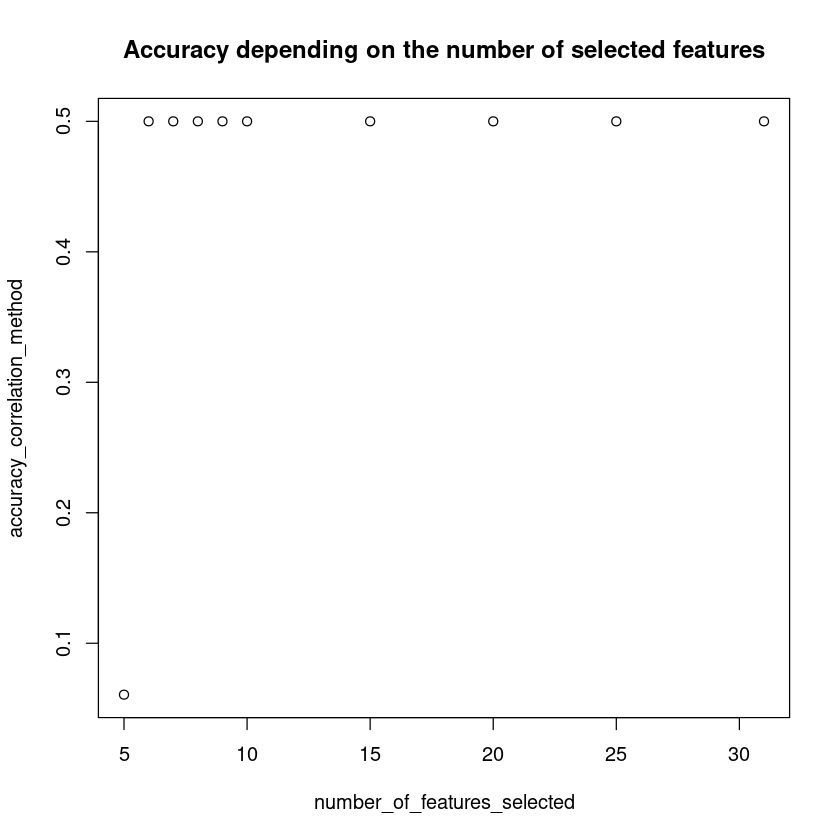

In [20]:
#Plot of the accuracy depending on the number of features. 

#Creation of the vector 
number_of_features_selected <- c('31', '25', '20', '15', '10', '9', '8', '7', '6', '5')
accuracy_correlation_method <- c(accuracy_31, accuracy_25, accuracy_20, accuracy_15, accuracy_10, accuracy_9, accuracy_8, accuracy_7, accuracy_6, accuracy_5)

#plot of accuracy
plot(number_of_features_selected, accuracy_correlation_method, main='Accuracy depending on the number of selected features')

We can observe that the accuracy is decreasing when we select a reduced number of features (drops to 0.061 when we select only 5 features). 

In [21]:
# Ranking of the features with the correlation with the output method. 
correlation_ranking_idx
colnames(X)[correlation_ranking_idx]

[1] 10 16 15 19 11 18 14  1  2 12 17  6  5  9 13  4 25 21 23  3 22 26  8  7 24
[26] 27 20 30 28 29 31

[1] "doctor_recc_h1n1"            "opinion_h1n1_risk"          
 [3] "opinion_h1n1_vacc_effective" "opinion_seas_risk"          
 [5] "doctor_recc_seasonal"        "opinion_seas_vacc_effective"
 [7] "health_worker"               "h1n1_concern"               
 [9] "h1n1_knowledge"              "chronic_med_condition"      
[11] "opinion_h1n1_sick_from_vacc" "behavioral_wash_hands"      
[13] "behavioral_face_mask"        "behavioral_touch_face"      
[15] "child_under_6_months"        "behavioral_avoidance"       
[17] "marital_status"              "age_group"                  
[19] "race"                        "behavioral_antiviral_meds"  
[21] "education"                   "rent_or_own"                
[23] "behavioral_outside_home"     "behavioral_large_gatherings"
[25] "sex"                         "employment_status"          
[27] "opinion_seas_sick_from_vacc" "household_adults"           
[29] "hhs_geo_region"              "census_msa"                 
[31] "household_children"

### mRMR (H1N1)

The documentation about the mRMR approach is from the section 12.8 of the course syllabus. 
mRMR (minimum Reducancy Maximal Relevance) is a forward selection method which selects at each step the variable which has at the same time the highest degree of relevance and the lowest redundancy with the already selected features.  This redundancy is not adressed with the previous method (correlation with the output). 

In [22]:
#mRMR approach 
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_31<- get_accuracy(Y_hat_ts, Y_ts)
    }
}  

#Computation of the CV error and standard deviation for all the features.
print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

#Accuracy results for 31 features selected : 
print(accuracy_results_31)

 [1] "#Features:  1  ; CV error= 0.1414  ; std dev= 0.0028" 
 [2] "#Features:  2  ; CV error= 0.134  ; std dev= 0.0033"  
 [3] "#Features:  3  ; CV error= 0.1315  ; std dev= 0.0032" 
 [4] "#Features:  4  ; CV error= 0.1264  ; std dev= 0.0033" 
 [5] "#Features:  5  ; CV error= 0.1263  ; std dev= 0.0033" 
 [6] "#Features:  6  ; CV error= 0.1257  ; std dev= 0.0034" 
 [7] "#Features:  7  ; CV error= 0.1254  ; std dev= 0.0032" 
 [8] "#Features:  8  ; CV error= 0.1253  ; std dev= 0.0032" 
 [9] "#Features:  9  ; CV error= 0.1251  ; std dev= 0.0032" 
[10] "#Features:  10  ; CV error= 0.1247  ; std dev= 0.0032"
[11] "#Features:  11  ; CV error= 0.1247  ; std dev= 0.0032"
[12] "#Features:  12  ; CV error= 0.1247  ; std dev= 0.0032"
[13] "#Features:  13  ; CV error= 0.1246  ; std dev= 0.0032"
[14] "#Features:  14  ; CV error= 0.1246  ; std dev= 0.0032"
[15] "#Features:  15  ; CV error= 0.1245  ; std dev= 0.0032"
[16] "#Features:  16  ; CV error= 0.1245  ; std dev= 0.0031"
[17] "#Features:  17  ; 

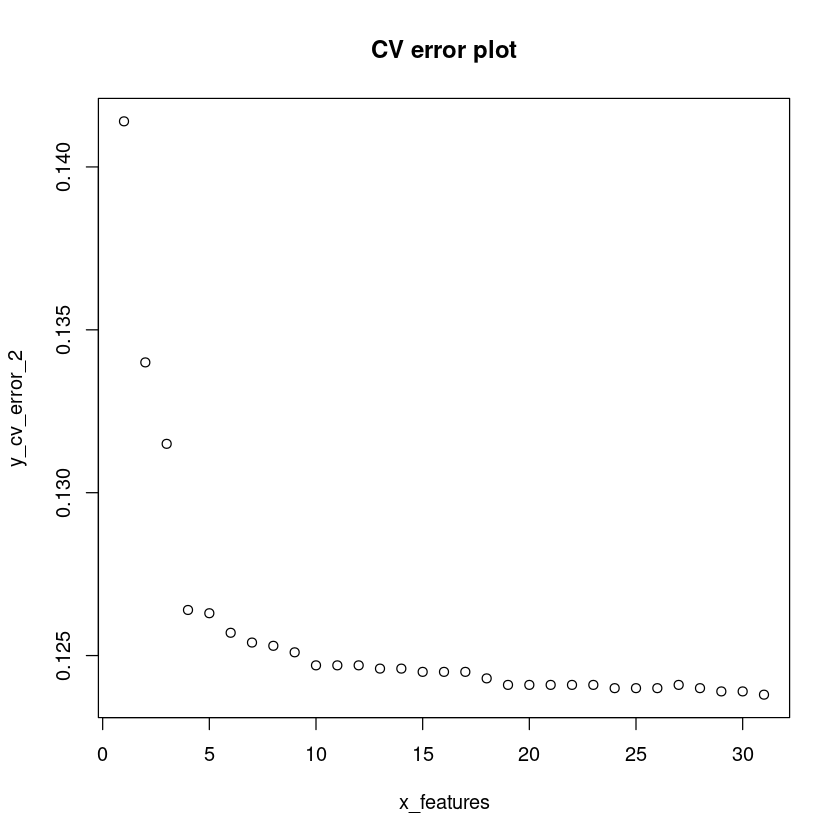

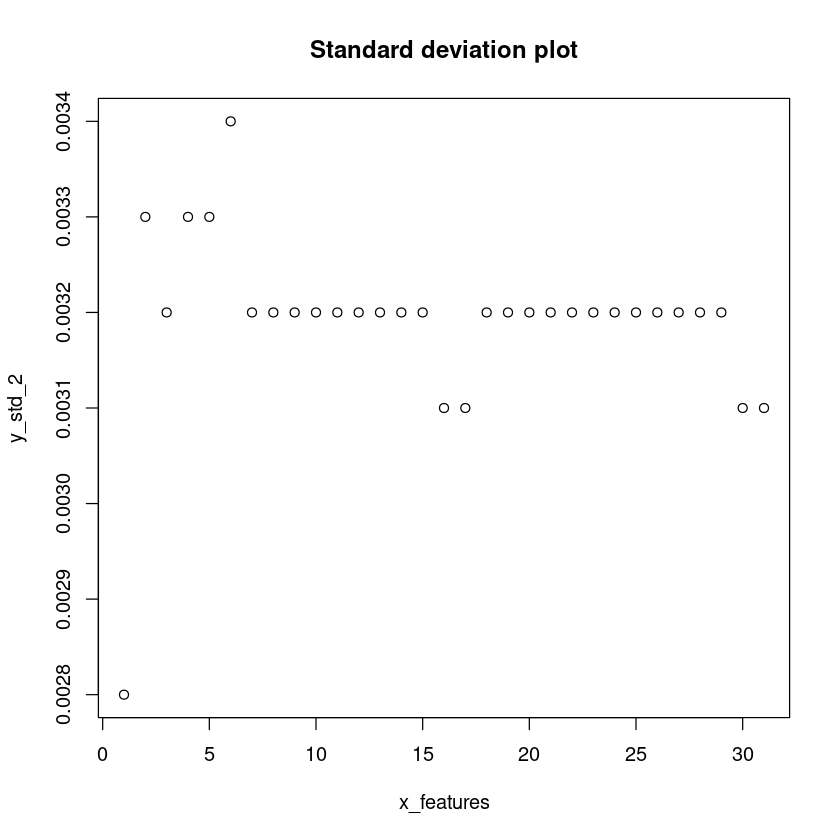

In [23]:
# CV error plot  and Standard deviaton plot 

x_features <- c(1:n)
y_cv_error_2 <- round(apply(CV_err,1,mean),digits=4)
plot(x_features, y_cv_error_2, main='CV error plot')

y_std_2 <- round(apply(CV_err,1,sd),digits=4)
plot(x_features, y_std_2, main='Standard deviation plot')

The CV error and standard deviation plot are very similar to the plots that we obtained for the correlation with the output methods. The observation that we made for the two methods are the same. 

The CV error plot indicates the CV error for all the features ranked by their correlation value. 
The standard deviation plot indicates the variability of the data for each feature. 

We can observe that the CV error is higher for the features that have the highest correlation value. 
The difference between the highest and lowest value for the CV error is small.  
The lowest value for the standard deviation is associated with the best feature selected. The range of the standard deviation value for the other features is really small.  

In [24]:
#Accuracy if we select 25, 20, 15, 10, 9, 8, 7, 6 and 5 features. 

#The number of features selected is the same as for the other methods. 
#This will allow us to compare the accuracy plot for the three methods and help us find the more 
#appropriate method for our datasets.

#As for the correlation with the output method, we decided to obtain the accuracy separately for all the 
#number of features that we selected. 
#This allowed us to reduce the number of iteration and reduce the time to run the notebook.

#Accuracy results for 25 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:25],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:25],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_25 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_25)

#Accuracy results for 20 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:20],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:20],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_20 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_20)

#Accuracy results for 15 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:15],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:15],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_15 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_15)

#Accuracy results for 10 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:10],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:10],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_10 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_10)

#Accuracy results for 9 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:9],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:9],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_9 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_9)

#Accuracy results for 8 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:8],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:8],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_8 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_8)

#Accuracy results for 7 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:7],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:7],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_7 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_7)

#Accuracy results for 6 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:6],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:6],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_6 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_6)

#Accuracy results for 5 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:5],drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:5],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_5 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_5)

[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.6
[1] 0.4
[1] 0.4285714
[1] 0.5555556
[1] 0.3529412
[1] 0.6904762


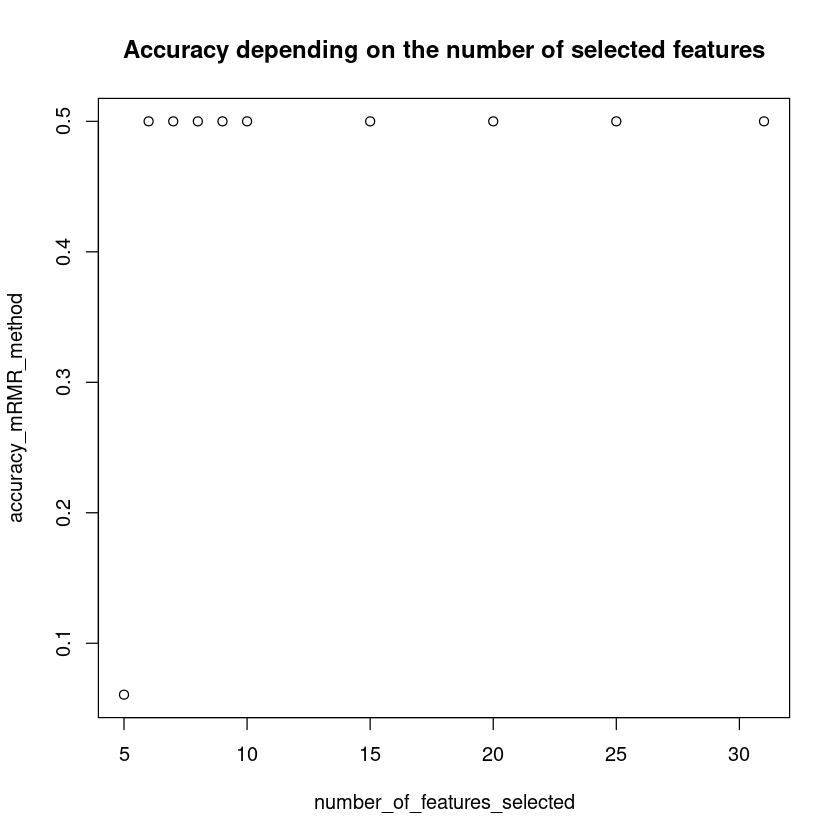

In [25]:
#Plot of the accuracy depending on the number of features. 

#Creation of the vector 
accuracy_mRMR_method<- c(accuracy_31, accuracy_25, accuracy_20, accuracy_15, accuracy_10, accuracy_9, accuracy_8, accuracy_7, accuracy_6, accuracy_5)

#plot of accuracy
plot(number_of_features_selected, accuracy_mRMR_method, main='Accuracy depending on the number of selected features')

We can observe that the accuracy have the lowest values when the features selected are 10 or lower. 

The performance of the model is only stable until 10 features are selected. 

In [26]:
# Ranking of the features with the correlation with the output method. 
selected
colnames(X)[selected]

[1] 10 15 14 16 24 21 19 25  2 11 30 18 13 26 23  5 12 22  1 31  9 28  3 17 29
[26]  6 27  4  8 20  7

[1] "doctor_recc_h1n1"            "opinion_h1n1_vacc_effective"
 [3] "health_worker"               "opinion_h1n1_risk"          
 [5] "sex"                         "age_group"                  
 [7] "opinion_seas_risk"           "marital_status"             
 [9] "h1n1_knowledge"              "doctor_recc_seasonal"       
[11] "household_adults"            "opinion_seas_vacc_effective"
[13] "child_under_6_months"        "rent_or_own"                
[15] "race"                        "behavioral_face_mask"       
[17] "chronic_med_condition"       "education"                  
[19] "h1n1_concern"                "household_children"         
[21] "behavioral_touch_face"       "hhs_geo_region"             
[23] "behavioral_antiviral_meds"   "opinion_h1n1_sick_from_vacc"
[25] "census_msa"                  "behavioral_wash_hands"      
[27] "employment_status"           "behavioral_avoidance"       
[29] "behavioral_outside_home"     "opinion_seas_sick_from_vacc"
[31] "behavioral_large_gatherings"

## Feature selection - wrapper methods (H1N1)

We used one wrapper method, the forward selection. 

### Forward selection (H1N1)

The documentation about the forward selection is from the section 12.4 of the syllabus. 
The procedure starts with no variables and progressively incorporates features. The first input selected is the one which allows the lowest generalisation error. The second input selected is the one that, together with the first, has the lowest error, and so on, until no further improvement is made or the required number of features is attained. In our case, the number of input selected is equal to the number of features that we have.  

Our number of features was small (31). We did not have to reduce further our number of features selected before using the forward selection method. 

In [27]:
#Forward selection method
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

bbb = c()
ddd = c()

# Perform up to n (number of variables) round of selection
for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_31 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
    # Vector of the CV error and standard deviation for each feature selected 
    bbb <- append(bbb, round(CV_err_mean[selected_current],digits=4))
    ddd <- append(ddd, round(CV_err_sd[selected_current],digits=4))
    
    # The CV error and the standard deviation are calculated for all the features. 
    # The values of the CV error and standard deviation will be compared between the three models.  
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV_err_mean[selected_current],digits=4), " ; std dev=",round(CV_err_sd[selected_current],digits=4)))
 
}
                   
#Accuracy of the method is we select 31 features. 
print(accuracy_results_31)

[1] "Round  1  ; Selected feature:  10  ; CV error= 0.1414  ; std dev= 0.0028"
[1] "Round  2  ; Selected feature:  16  ; CV error= 0.1325  ; std dev= 0.0031"
[1] "Round  3  ; Selected feature:  15  ; CV error= 0.1282  ; std dev= 0.0034"
[1] "Round  4  ; Selected feature:  14  ; CV error= 0.1264  ; std dev= 0.0033"
[1] "Round  5  ; Selected feature:  21  ; CV error= 0.1258  ; std dev= 0.0033"
[1] "Round  6  ; Selected feature:  20  ; CV error= 0.1255  ; std dev= 0.0034"
[1] "Round  7  ; Selected feature:  19  ; CV error= 0.1251  ; std dev= 0.0032"
[1] "Round  8  ; Selected feature:  11  ; CV error= 0.1247  ; std dev= 0.0033"
[1] "Round  9  ; Selected feature:  1  ; CV error= 0.1245  ; std dev= 0.0033"
[1] "Round  10  ; Selected feature:  2  ; CV error= 0.1243  ; std dev= 0.0033"
[1] "Round  11  ; Selected feature:  25  ; CV error= 0.1241  ; std dev= 0.0033"
[1] "Round  12  ; Selected feature:  7  ; CV error= 0.124  ; std dev= 0.0033"
[1] "Round  13  ; Selected feature:  24  ; CV error= 

In [28]:
# Ranking of the features selected in each round with the forward selection method. 
colnames(X)[selected]
selected

[1] "doctor_recc_h1n1"            "opinion_h1n1_risk"          
 [3] "opinion_h1n1_vacc_effective" "health_worker"              
 [5] "age_group"                   "opinion_seas_sick_from_vacc"
 [7] "opinion_seas_risk"           "doctor_recc_seasonal"       
 [9] "h1n1_concern"                "h1n1_knowledge"             
[11] "marital_status"              "behavioral_large_gatherings"
[13] "sex"                         "child_under_6_months"       
[15] "race"                        "behavioral_face_mask"       
[17] "chronic_med_condition"       "opinion_seas_vacc_effective"
[19] "behavioral_antiviral_meds"   "household_children"         
[21] "education"                   "census_msa"                 
[23] "employment_status"           "rent_or_own"                
[25] "behavioral_avoidance"        "behavioral_wash_hands"      
[27] "hhs_geo_region"              "opinion_h1n1_sick_from_vacc"
[29] "behavioral_touch_face"       "behavioral_outside_home"    
[31] "household_adults"

[1] 10 16 15 14 21 20 19 11  1  2 25  7 24 13 23  5 12 18  3 31 22 29 27 26  4
[26]  6 28 17  9  8 30

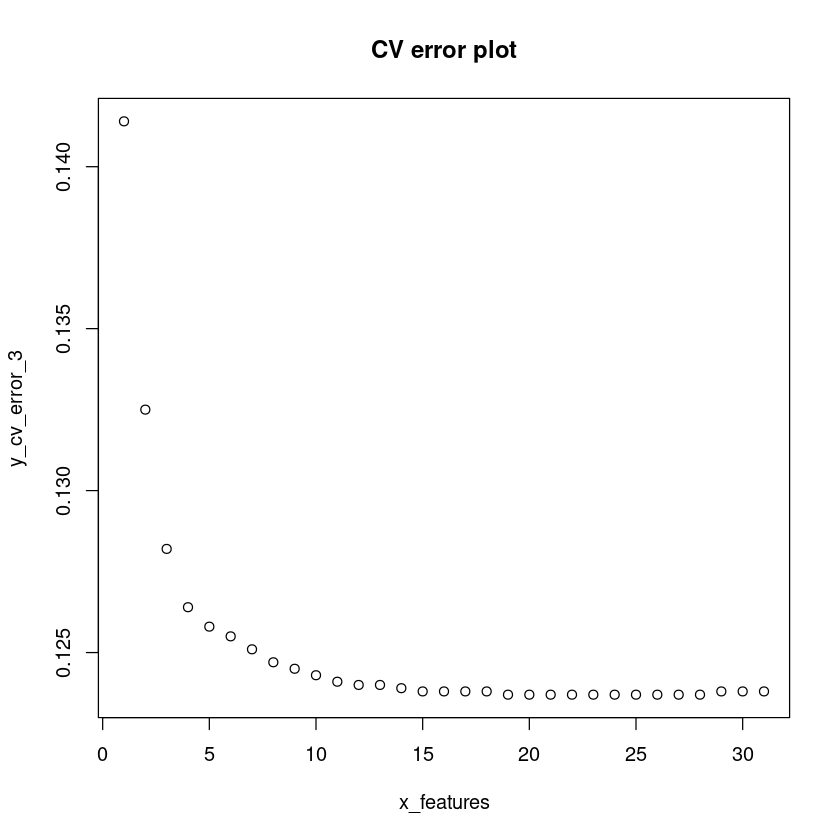

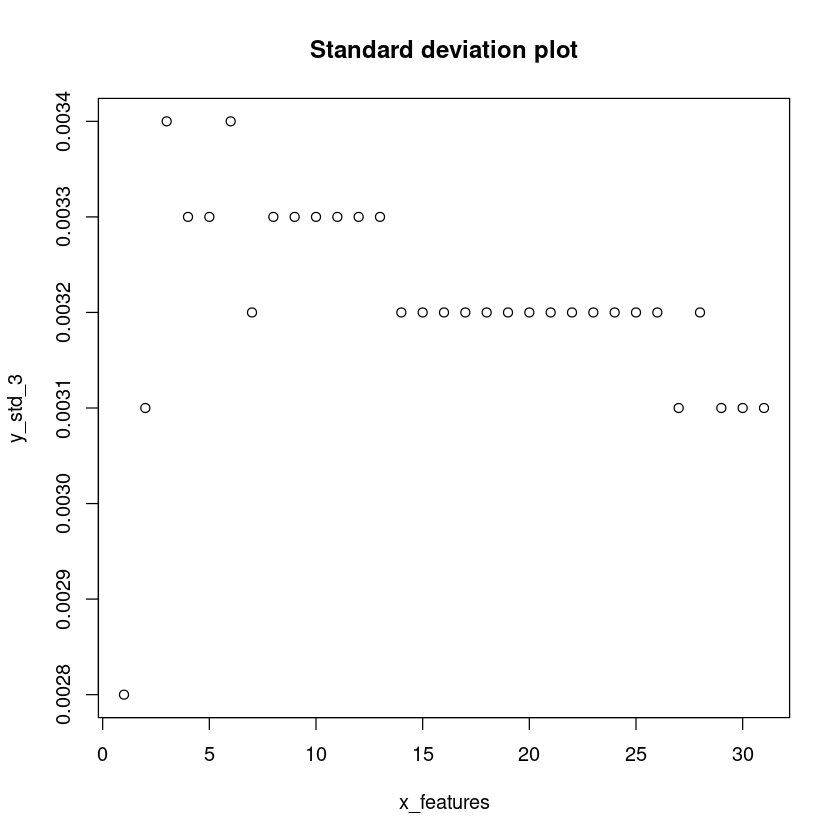

In [29]:
# CV error plot and Standard deviation plot 

x_features <- c(1:n)
y_cv_error_3 <- bbb
plot(x_features, y_cv_error_3, main='CV error plot')

y_std_3 <- ddd
plot(x_features, y_std_3, main='Standard deviation plot')

The CV error and standard deviation plot are very similar to the plots that we obtained for the correlation with the output methods and the mRMR method. The observation that we made for the three methods are the same. 

The CV error plot indicates the CV error for all the features ranked by their correlation value. 
#The standard deviation plot indicates the variability of the data for each feature. 

We can observe that the CV error is higher for the features that have the highest correlation value. 
#The difference between the highest and lowest value for the CV error is small.  

The lowest value for the standard deviation is associated with the best feature selected. The range of the standard deviation value for the other features is really small.  

In [31]:
#Accuracy if we select 25, 20, 15, 10, 9, 8, 7, 6 and 5 features. 
#The number of features selected is the same as for the other methods. 

#Accuracy if the number of selected features is 25 
CV_folds <- 10
size_CV <-floor(N/CV_folds)
selected<-NULL

for (round in 1:25) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_25 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
    
}

print(accuracy_results_25)

#Accuracy if the number of selected features is 20
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:20) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_20 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])

 
}
                   
print(accuracy_results_20)

#Accuracy if the number of selected features is 15
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:15) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_15 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])

 
}
                   
print(accuracy_results_15)

#Accuracy if the number of selected features is 10
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:10) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_10 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_10)

#Accuracy if the number of selected features is 9
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:9) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_9 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_9)

#Accuracy if the number of selected features is 8
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:8) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_8 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_8)

#Accuracy if the number of selected features is 7
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:7) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_7 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_7)

#Accuracy if the number of selected features is 6
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:6) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_6 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_6)

#Accuracy if the number of selected features is 5
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:5) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,h1n1_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(h1n1_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_5 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_5)

[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.4
[1] 0.3333333
[1] 0.75


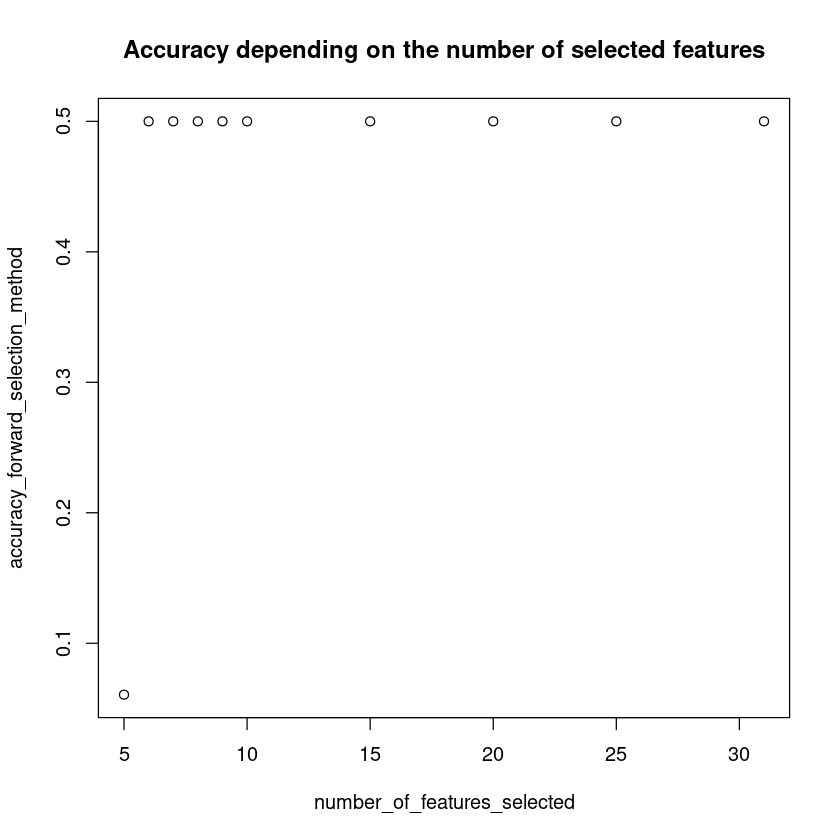

In [33]:
#Plot of the accuracy depending on the number of features. 

#Creation of the vector 
accuracy_forward_selection_method<- c(accuracy_31, accuracy_25, accuracy_20, accuracy_15, accuracy_10, accuracy_9, accuracy_8, accuracy_7, accuracy_6, accuracy_5)

#plot of accuracy
plot(number_of_features_selected, accuracy_forward_selection_method, main='Accuracy depending on the number of selected features')

We can observe that the accuracy have the lowest values when the features selected are 7 or lower. The performance of the model is only stable until 7 features are selected. 

## Comparison of the three feature selection approach (H1N1)

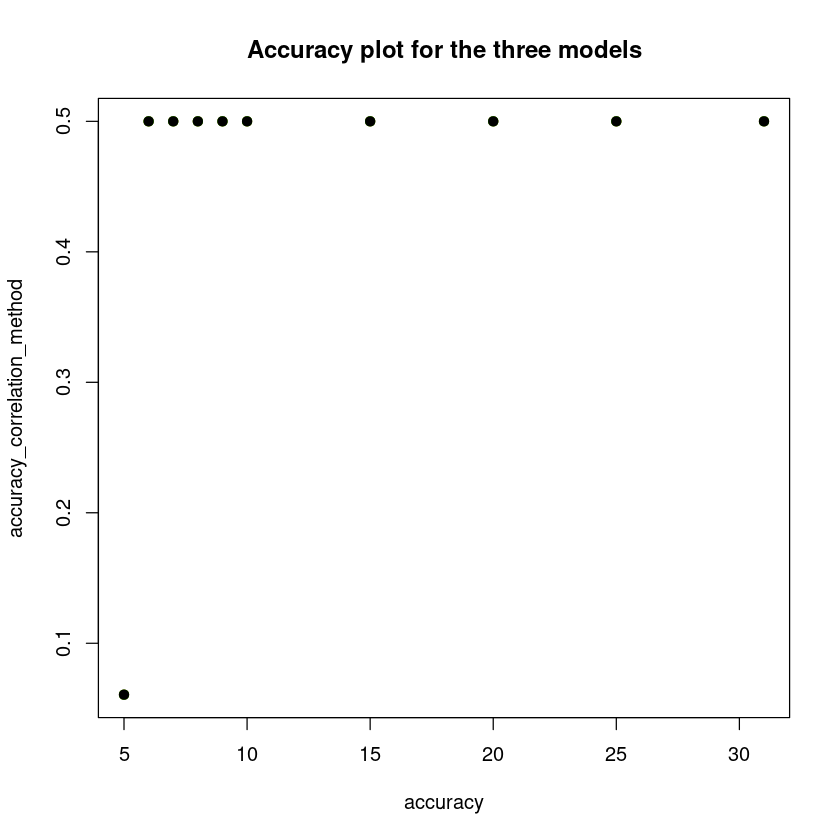

In [39]:
#Accuracy plot for the three models.  
#The accuracy for the correlation with the output approach is colored in red. 
#The accuracy for the mRMR approach is colored in green. 
#The accuracy for the forward selection method is colored in black. 

plot(number_of_features_selected,accuracy_correlation_method,pch = 19,col="red", main="Accuracy plot for the three models", xlab="accuracy")
points(number_of_features_selected,accuracy_mRMR_method,pch = 19,col="green")
points(number_of_features_selected,accuracy_forward_selection_method,pch = 19,col="black")

We decided to plot the accuracy with two methods instead of three to ease the reading of the plot.

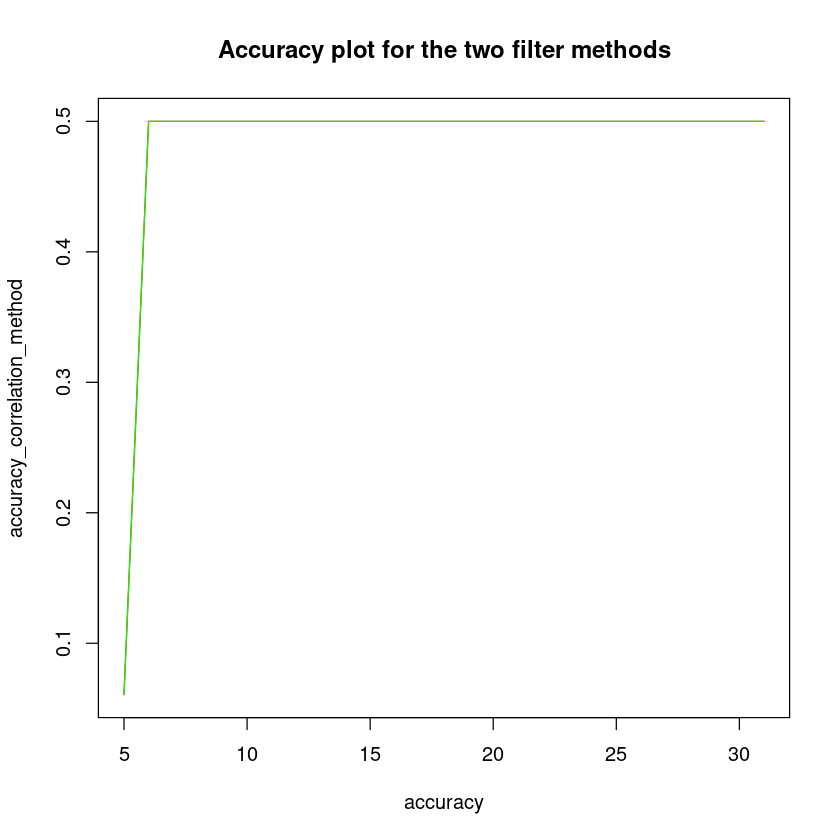

In [44]:
#Accuracy plot for the two filter methods. 

plot(number_of_features_selected,accuracy_correlation_method,type="l",col="red", main="Accuracy plot for the two filter methods", xlab="accuracy")
points(number_of_features_selected,accuracy_mRMR_method,type="l",col="green")

We can observe that the performance of the mRMR method is stable until we select 15 features and that the performance of the correlation with the output method is stable until we select 7 feature. 

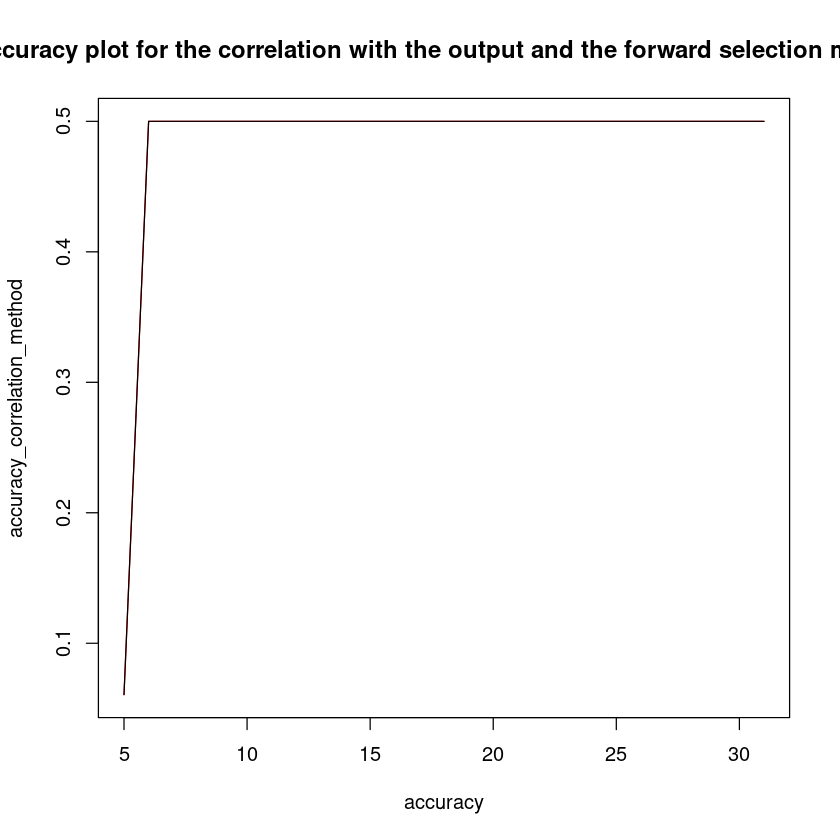

In [45]:
#Accuracy plot for the correlation with the output and the forward selection method

plot(number_of_features_selected,accuracy_correlation_method,type="l",col="red", main="Accuracy plot for the correlation with the output and the forward selection method", xlab="accuracy")
points(number_of_features_selected,accuracy_forward_selection_method,type="l",col="black")

The performance of the two methods are similar. The correlation with the output method is stable until we select 6 features (and then goes upwards) compared to the forward selection method that is stable until we select 7 features (and then decrease before going upwards).

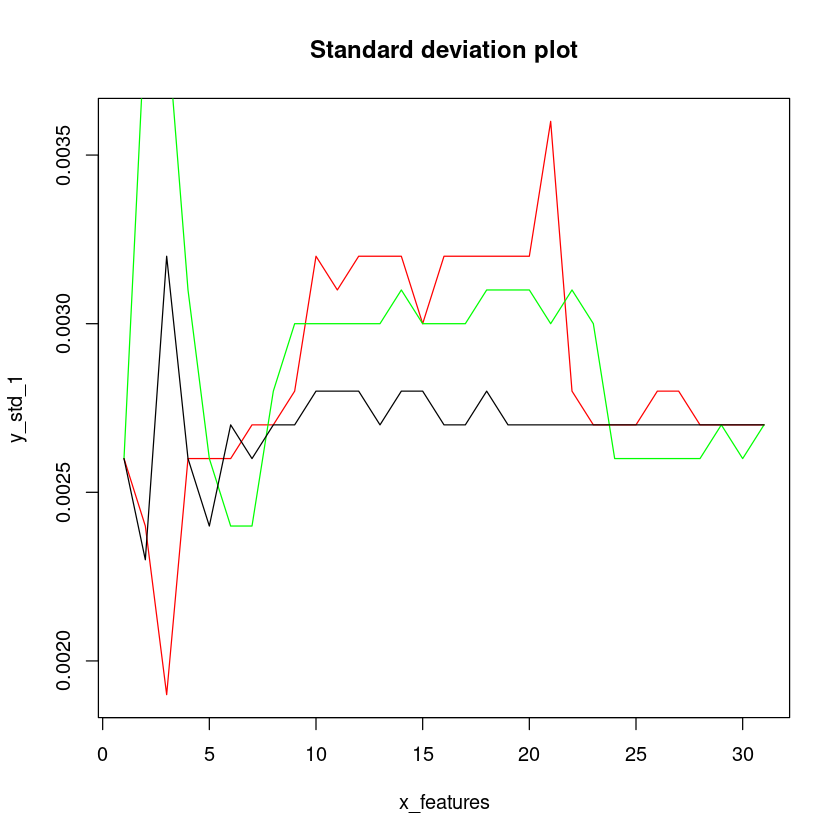

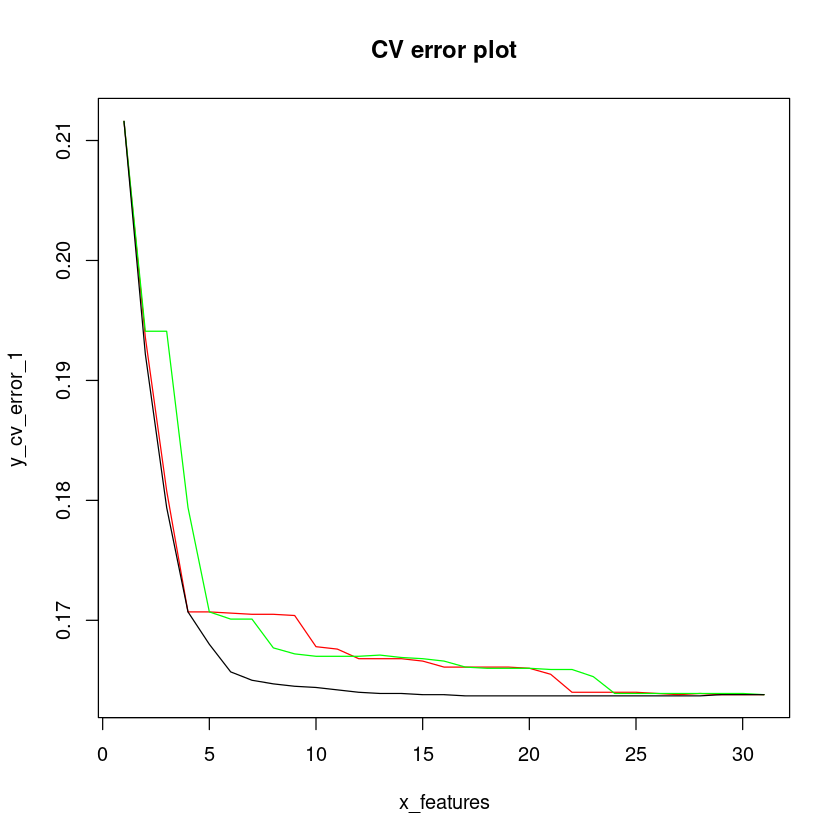

In [176]:
#CV error plot for the three methods. 
plot(x_features, y_std_1, main='Standard deviation plot', type="l", col="red")
points(x_features,y_std_2,type="l",col="green")
points(x_features,y_std_3,type="l",col="black")

#Standard deviation plot for the three methods. 
plot(x_features, y_cv_error_1, type="l",main='CV error plot', col="red")
points(x_features,y_cv_error_2,type="l",col="green")
points(x_features,y_cv_error_3,type="l",col="black")

We can observe that the standard deviation values for the three methods are in the same range and have similar values.
For the CV error values, we can observe that the cross-validation values are lower for the the forward selection method. 

As the accuracy of the correlation with the output and forward selection methods are similar, we chose the forward selection methods for our feature selection because the CV error were the lowest. 

In [50]:
# Creation of the dataset that will be used for the prediction for the h1n1 vaccine 
# The forward selection method was selected. 
# We removed the last 7 features selected by our approach. 

data_h1n1 <- subset(data, select = -c(behavioral_avoidance, behavioral_wash_hands, hhs_geo_region, opinion_h1n1_sick_from_vacc, behavioral_touch_face, behavioral_outside_home, household_adults))
data_h1n1

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_face_mask,behavioral_large_gatherings,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,⋯,opinion_seas_sick_from_vacc,age_group,education,race,sex,marital_status,rent_or_own,employment_status,census_msa,household_children
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0,0,0,0,0,0,0,0,⋯,2,4,1,4,1,2,1,2,3,0
2,1,3,2,0,0,0,0,0,0,0,⋯,4,2,2,4,2,2,2,1,1,0
3,2,1,1,0,0,0,0,0,1,0,⋯,2,1,3,4,2,2,1,1,1,0
4,3,1,1,0,0,1,0,1,1,0,⋯,1,5,2,4,1,2,2,2,2,0
5,4,2,1,0,0,1,0,0,0,0,⋯,4,3,4,4,1,1,1,1,1,0
6,5,3,1,0,0,0,0,1,0,0,⋯,4,5,2,4,2,1,1,1,2,3
7,6,0,0,0,0,0,0,0,0,0,⋯,1,4,1,4,2,2,1,1,1,0
8,7,1,0,0,0,0,1,0,1,0,⋯,1,3,4,4,1,1,1,1,3,0
9,8,0,2,0,0,1,0,0,0,0,⋯,1,3,3,4,2,1,1,1,1,0


## Feature selection - Seasonal vaccine

We followed the same steps for feature selection method for the seasonal vaccine as for the the h1n1 vaccine.  We also chose to explore the same three methods (correlation with the output, mRMR and forward selection). The code is the same as for the h1n1 vaccine. 

We also noted that a lot of our observation were similar.

[1] 0.4656083

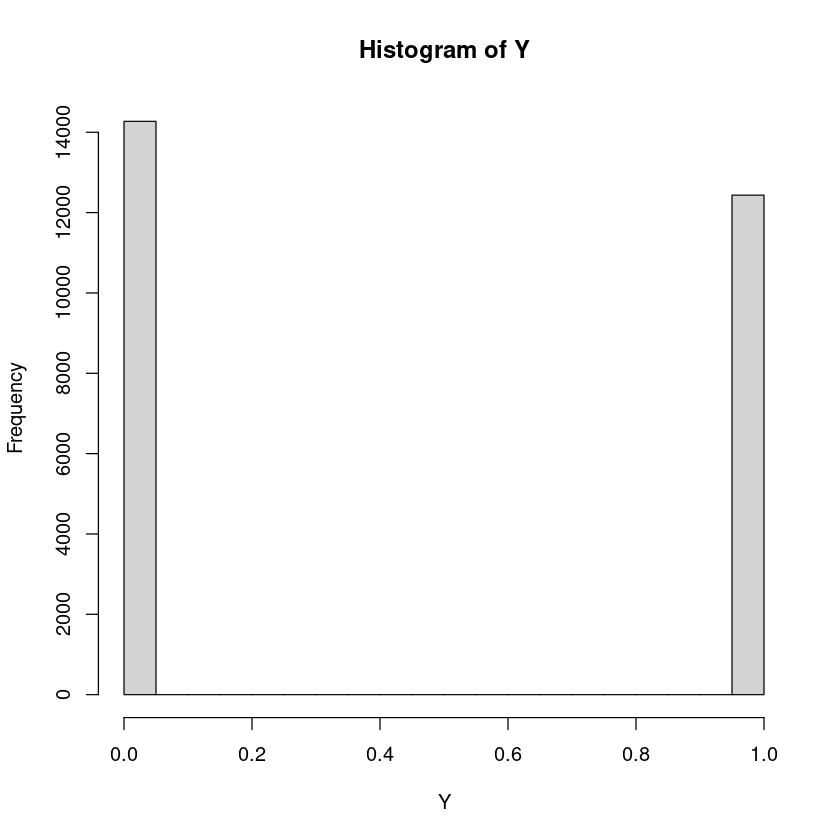

In [51]:
#Input and Output variables.
#The input variables is the data. We remove the respondent_id column because it is not considered a feature. 
#The output variable is the seasonal_vaccine variable for the labels dataset.


X <- data  #using data without labels
X <- subset(data, select = -c(respondent_id))
Y <- labels[,"seasonal_vaccine"] #Seasonal vaccine

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

hist(Y)
mean(Y) #check if it correspond to the expected value 

## Feature selection - Filter methods (Seasonal vaccine)

We used two filter methods : the correlation with the output method and the mRMR method. 

The code below is still the same as the one from the practical 5 (with light modification).

### Correlation with the output


In [52]:
# correlation with the output
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_31 <- get_accuracy(Y_hat_ts, Y_ts)
    }
}  

# The CV error and the standard deviation are calculated for all the features. 
# The values of the CV error and standard deviation will be compared between the three models.  
print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))


#Accuracy if we select 31 features 
accuracy_31

 [1] "#Features:  1  ; CV error= 0.2116  ; std dev= 0.0026" 
 [2] "#Features:  2  ; CV error= 0.1936  ; std dev= 0.0024" 
 [3] "#Features:  3  ; CV error= 0.1808  ; std dev= 0.0019" 
 [4] "#Features:  4  ; CV error= 0.1707  ; std dev= 0.0026" 
 [5] "#Features:  5  ; CV error= 0.1707  ; std dev= 0.0026" 
 [6] "#Features:  6  ; CV error= 0.1706  ; std dev= 0.0026" 
 [7] "#Features:  7  ; CV error= 0.1705  ; std dev= 0.0027" 
 [8] "#Features:  8  ; CV error= 0.1705  ; std dev= 0.0027" 
 [9] "#Features:  9  ; CV error= 0.1704  ; std dev= 0.0028" 
[10] "#Features:  10  ; CV error= 0.1678  ; std dev= 0.0032"
[11] "#Features:  11  ; CV error= 0.1676  ; std dev= 0.0031"
[12] "#Features:  12  ; CV error= 0.1668  ; std dev= 0.0032"
[13] "#Features:  13  ; CV error= 0.1668  ; std dev= 0.0032"
[14] "#Features:  14  ; CV error= 0.1668  ; std dev= 0.0032"
[15] "#Features:  15  ; CV error= 0.1666  ; std dev= 0.003" 
[16] "#Features:  16  ; CV error= 0.1661  ; std dev= 0.0032"
[17] "#Features:  17  ; 

[1] 0.5

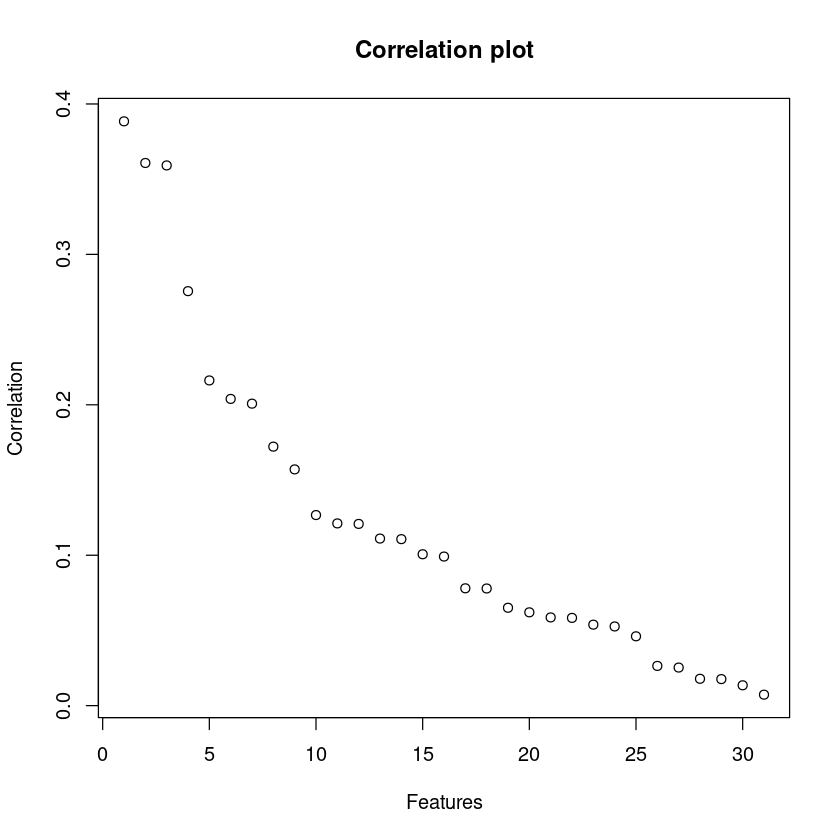

In [53]:
#Correlation plot
correlation_plot <- correlation_vector[order(correlation_vector[ , 1], decreasing = TRUE), ]
plot(correlation_plot, xlab='Features', ylab='Correlation', main='Correlation plot')

The correlation plot indicates the correlation of our 31 variables with the output. The features are ranked according to the value of the correlation. 

The best features have the highest correlation. The features that we can remove from the dataset have the lowest correlation. 

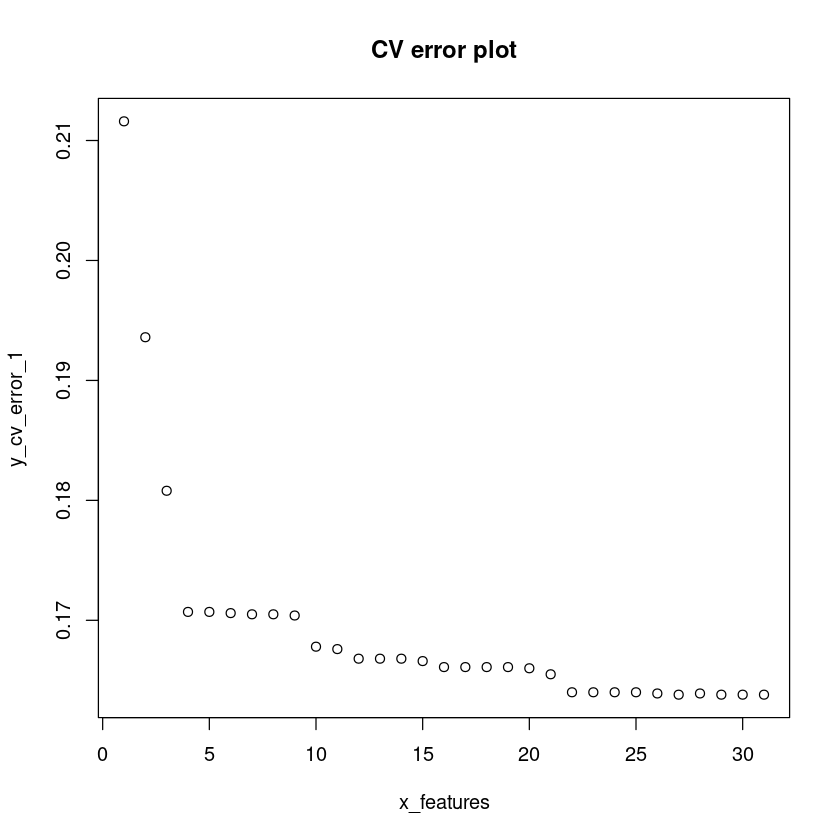

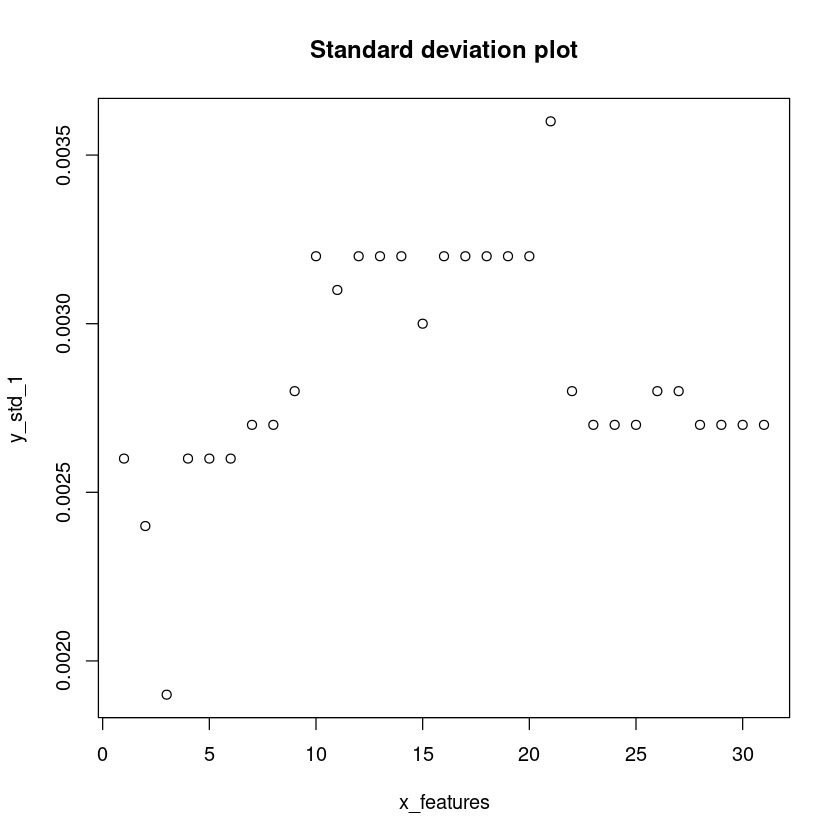

In [54]:
# CV error plot and Standard deviation plot 
x_features <- c(1:n)
y_cv_error_1 <- round(apply(CV_err,1,mean),digits=4)
plot(x_features, y_cv_error_1, main='CV error plot')

y_std_1 <- round(apply(CV_err,1,sd),digits=4)
plot(x_features, y_std_1, main='Standard deviation plot')

The CV error plot indicates the CV error for all the features ranked by their correlation value. 

The standard deviation plot indicates the variability of the data for each feature. 

We can observe that the CV error is higher for the features that have the highest correlation value. The difference between the highest and lowest value for the CV error is small.  

The lowest value for the standard deviation is associated with the best feature selected. The range of the standard deviation value for the other features is really small.  

In [55]:
#Accuracy if we select 25, 20, 15, 10, 9, 8, 7, 6 and 5 features. 
#We decided to obtain the accuracy separately for all the number of features that we selected. 
#This allowed us to reduce the number of iteration and reduce the time to run the notebook.

#Accurary if we select 25 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:25],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:25],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_25 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_25

#Accurary if we select 20 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:20],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:20],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_20 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_20

#Accurary if we select 15 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:20],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:20],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_15 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_15

#Accurary if we select 10 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:20],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:20],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_10 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_10

#Accurary if we select 9 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:9],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:9],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_9 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_9

#Accurary if we select 8 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:8],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:8],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_8 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_8

#Accurary if we select 7 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:7],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:7],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_7 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_7

#Accurary if we select 6 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:6],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:6],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_6 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_6

#Accurary if we select 5 features 
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:5],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:5],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
} 

cm <- table(Y_ts, Y_hat_ts)
accuracy_5 <- sum(cm[1], cm[4]) / sum(cm[1:4])
accuracy_5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.5

[1] 0.3333333

[1] 0.25

[1] 0.8

[1] 0.7272727

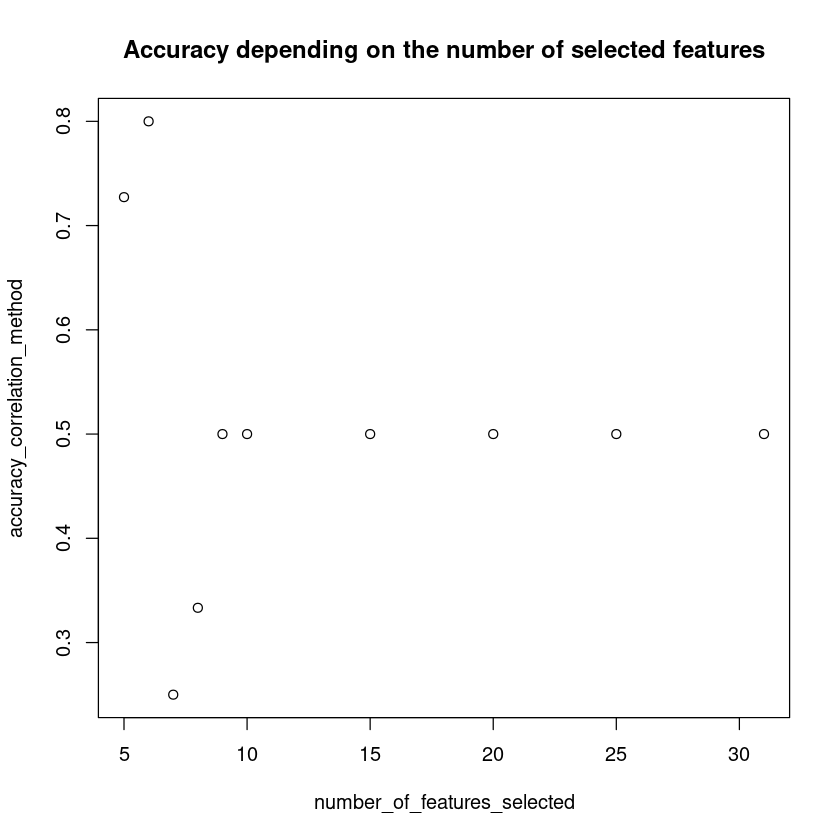

In [56]:
#Plot of the accuracy depending on the number of features. 

#Creation of the vector 
number_of_features_selected <- c('31', '25', '20', '15', '10', '9', '8', '7', '6', '5')
accuracy_correlation_method <- c(accuracy_31, accuracy_25, accuracy_20, accuracy_15, accuracy_10, accuracy_9, accuracy_8, accuracy_7, accuracy_6, accuracy_5)

#plot of accuracy
plot(number_of_features_selected, accuracy_correlation_method, main='Accuracy depending on the number of selected features')

We can observe that the accuracy is decreasing when we select a reduced number of features (drops to 0.33 when we select only 8 features). The accuracy goes upwards when we select 6 and 5 features. The accuracy is stable until we select 9 features. 

In [57]:
# Ranking of the features with the correlation with the output method. 
correlation_ranking_idx
colnames(X)[correlation_ranking_idx]

[1] 19 11 18 21 16 15 10 12  1 14  9  2  6 31 23 26  4 24  7 30 27 20  5  8 25
[26] 17 22 29 28 13  3

[1] "opinion_seas_risk"           "doctor_recc_seasonal"       
 [3] "opinion_seas_vacc_effective" "age_group"                  
 [5] "opinion_h1n1_risk"           "opinion_h1n1_vacc_effective"
 [7] "doctor_recc_h1n1"            "chronic_med_condition"      
 [9] "h1n1_concern"                "health_worker"              
[11] "behavioral_touch_face"       "h1n1_knowledge"             
[13] "behavioral_wash_hands"       "household_children"         
[15] "race"                        "rent_or_own"                
[17] "behavioral_avoidance"        "sex"                        
[19] "behavioral_large_gatherings" "household_adults"           
[21] "employment_status"           "opinion_seas_sick_from_vacc"
[23] "behavioral_face_mask"        "behavioral_outside_home"    
[25] "marital_status"              "opinion_h1n1_sick_from_vacc"
[27] "education"                   "census_msa"                 
[29] "hhs_geo_region"              "child_under_6_months"       
[31] "behavioral_antiviral_meds"

### mRMR (Seasonal vaccine)

In [58]:
# mRMR approach 
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_31<- get_accuracy(Y_hat_ts, Y_ts)
    }
}  

#Computation of the CV error and standard deviation for all the features.
print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

#Accuracy results for 31 features selected : 
print(accuracy_results_31)

 [1] "#Features:  1  ; CV error= 0.2116  ; std dev= 0.0026" 
 [2] "#Features:  2  ; CV error= 0.1941  ; std dev= 0.0039" 
 [3] "#Features:  3  ; CV error= 0.1941  ; std dev= 0.0039" 
 [4] "#Features:  4  ; CV error= 0.1794  ; std dev= 0.0031" 
 [5] "#Features:  5  ; CV error= 0.1707  ; std dev= 0.0026" 
 [6] "#Features:  6  ; CV error= 0.1701  ; std dev= 0.0024" 
 [7] "#Features:  7  ; CV error= 0.1701  ; std dev= 0.0024" 
 [8] "#Features:  8  ; CV error= 0.1677  ; std dev= 0.0028" 
 [9] "#Features:  9  ; CV error= 0.1672  ; std dev= 0.003"  
[10] "#Features:  10  ; CV error= 0.167  ; std dev= 0.003"  
[11] "#Features:  11  ; CV error= 0.167  ; std dev= 0.003"  
[12] "#Features:  12  ; CV error= 0.167  ; std dev= 0.003"  
[13] "#Features:  13  ; CV error= 0.1671  ; std dev= 0.003" 
[14] "#Features:  14  ; CV error= 0.1669  ; std dev= 0.0031"
[15] "#Features:  15  ; CV error= 0.1668  ; std dev= 0.003" 
[16] "#Features:  16  ; CV error= 0.1666  ; std dev= 0.003" 
[17] "#Features:  17  ; 

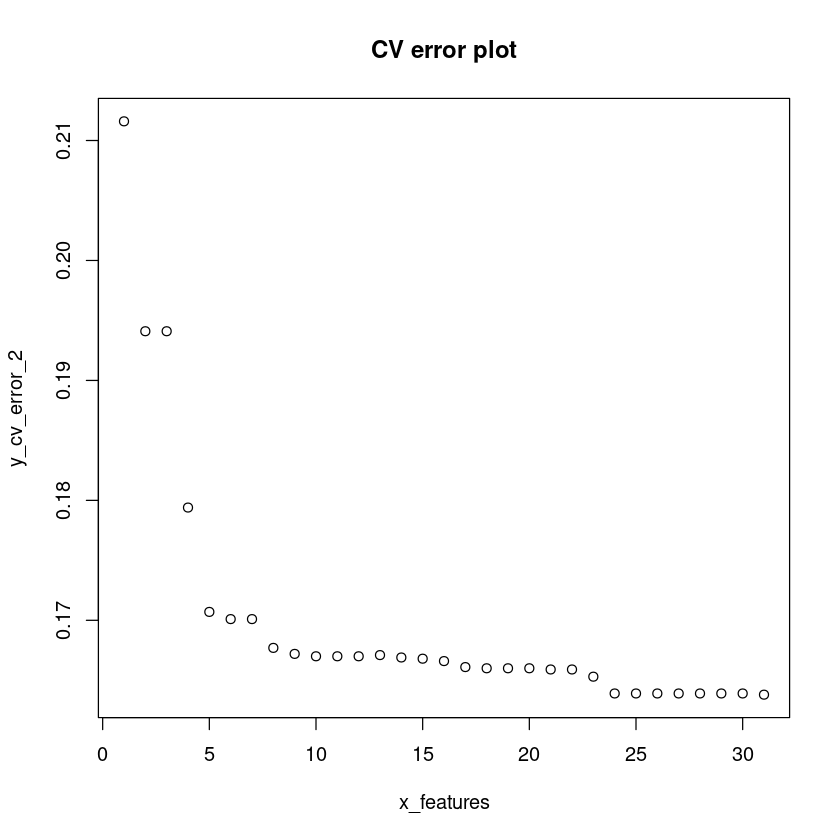

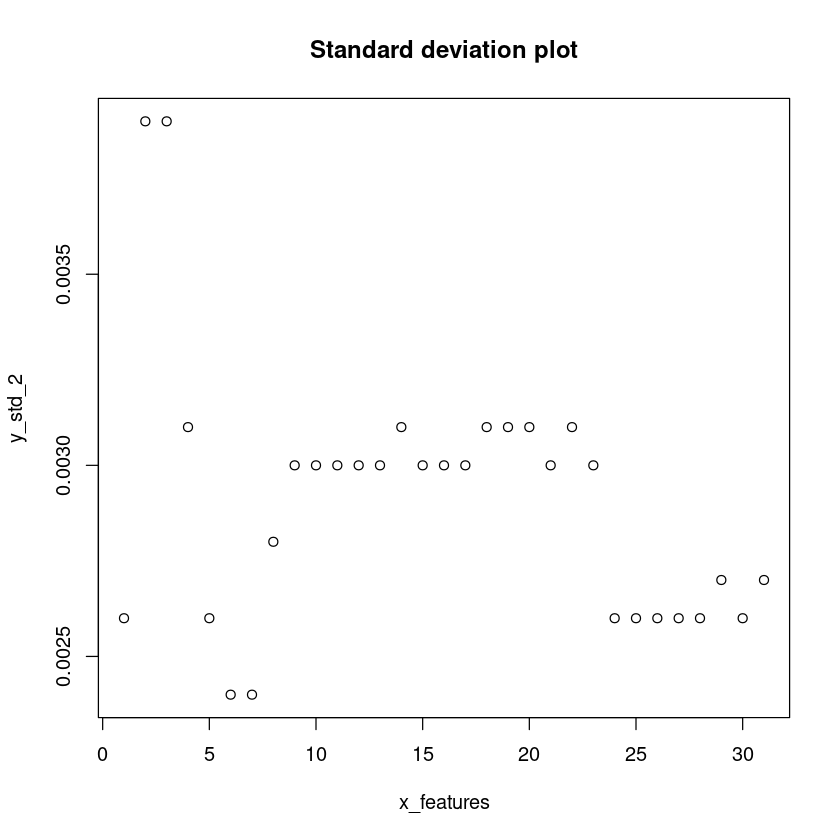

In [59]:
# CV error plot  and Standard deviaton plot 

x_features <- c(1:n)
y_cv_error_2 <- round(apply(CV_err,1,mean),digits=4)
plot(x_features, y_cv_error_2, main='CV error plot')

y_std_2 <- round(apply(CV_err,1,sd),digits=4)
plot(x_features, y_std_2, main='Standard deviation plot')

The CV error and standard deviation plot are similar to the plots that we obtained for the correlation with the output methods.  The ranges of the values for the CV error are the same for the correlation with the output and mRMR methods. We can make the same observation for the standard deviation.  

The CV error plot indicates the CV error for all the features ranked by their correlation value. 
The standard deviation plot indicates the variability of the data for each feature. 

In [60]:
#Accuracy if we select 25, 20, 15, 10, 9, 8, 7, 6 and 5 features. 

#Accuracy results for 25 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:25],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:25],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_25 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_25)

#Accuracy results for 20 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:20],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:20],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_20 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_20)

#Accuracy results for 15 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:15],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:15],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_15 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_15)

#Accuracy results for 10 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:10],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:10],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_10 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_10)

#Accuracy results for 9 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:9],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:9],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_9 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_9)

#Accuracy results for 8 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:8],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:8],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_8 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_8)

#Accuracy results for 7 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:7],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:7],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_7 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_7)

#Accuracy results for 6 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:6],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:6],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_6 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_6)

#Accuracy results for 5 features selected :
for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:5],drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:5],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
        
        #accuracy
        accuracy_results_5 <- get_accuracy(Y_hat_ts, Y_ts)
    }
} 

print(accuracy_results_5)

[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.5
[1] 0.2857143
[1] 0.2857143
[1] 0.25
[1] 0.3076923


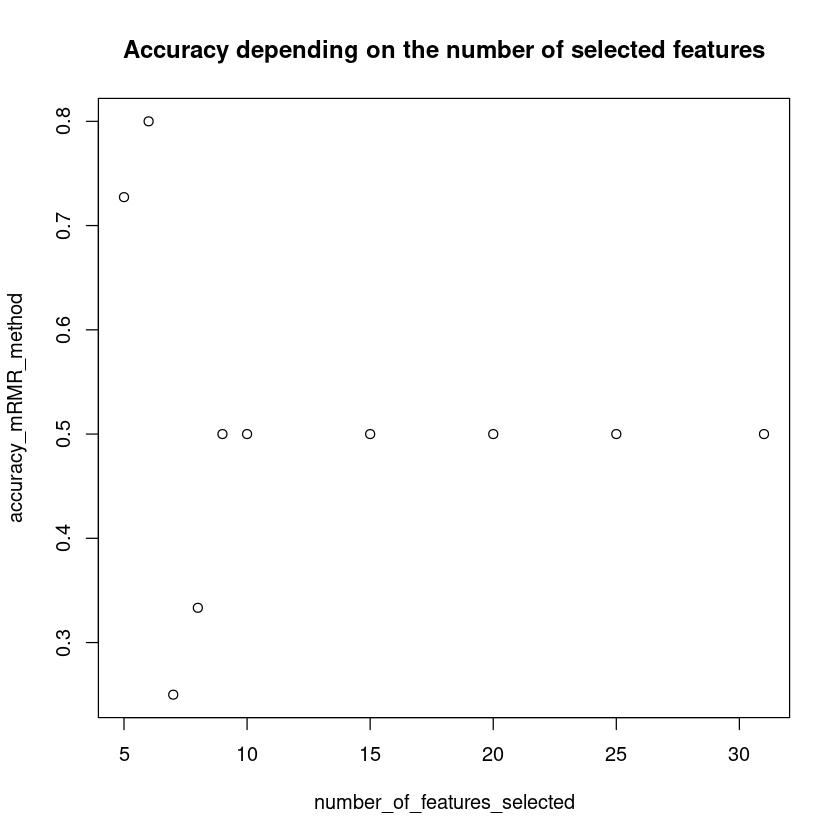

In [61]:
#Plot of the accuracy depending on the number of features. 

#Creation of the vector 
accuracy_mRMR_method<- c(accuracy_31, accuracy_25, accuracy_20, accuracy_15, accuracy_10, accuracy_9, accuracy_8, accuracy_7, accuracy_6, accuracy_5)

#plot of accuracy
plot(number_of_features_selected, accuracy_mRMR_method, main='Accuracy depending on the number of selected features')

We can observe that the accuracy have the lowest values when the features selected are 9 or lower (the accuracy decrease). 

The performance of the model is only stable until 9 features are selected. 

In [62]:
# Ranking of the features with the correlation with the output method. 
selected
colnames(X)[selected]

[1] 19 21 31 11 18 26 24 14 23 12 15 16 30 25 10  9  2  1 27  6 22 29 28 20  5
[26]  4 13  7  3  8 17

[1] "opinion_seas_risk"           "age_group"                  
 [3] "household_children"          "doctor_recc_seasonal"       
 [5] "opinion_seas_vacc_effective" "rent_or_own"                
 [7] "sex"                         "health_worker"              
 [9] "race"                        "chronic_med_condition"      
[11] "opinion_h1n1_vacc_effective" "opinion_h1n1_risk"          
[13] "household_adults"            "marital_status"             
[15] "doctor_recc_h1n1"            "behavioral_touch_face"      
[17] "h1n1_knowledge"              "h1n1_concern"               
[19] "employment_status"           "behavioral_wash_hands"      
[21] "education"                   "census_msa"                 
[23] "hhs_geo_region"              "opinion_seas_sick_from_vacc"
[25] "behavioral_face_mask"        "behavioral_avoidance"       
[27] "child_under_6_months"        "behavioral_large_gatherings"
[29] "behavioral_antiviral_meds"   "behavioral_outside_home"    
[31] "opinion_h1n1_sick_from_vacc"

## Feature selection - wrapper methods (Seasonal vaccine)


We used one wrapper method, the forward selection. 

### Forward selection

In [66]:
#Forward selection method
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

ccc <- c()

eee <- c()

# Perform up to n (number of variables) round of selection
for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_31 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
    # vector of the CV error and standard deviation for each feature selected 
    ccc <- append(ccc, round(CV_err_mean[selected_current],digits=4))
    eee <- append(eee, round(CV_err_sd[selected_current],digits=4))
    
    # The CV error and the standard deviation are calculated for all the features. 
    # The values of the CV error and standard deviation will be compared between the three models.  
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV_err_mean[selected_current],digits=4), " ; std dev=",round(CV_err_sd[selected_current],digits=4)))
 
}

#Accuracy of the method is we select 31 features. 
print(accuracy_results_31)

[1] "Round  1  ; Selected feature:  19  ; CV error= 0.2116  ; std dev= 0.0026"
[1] "Round  2  ; Selected feature:  11  ; CV error= 0.1922  ; std dev= 0.0023"
[1] "Round  3  ; Selected feature:  21  ; CV error= 0.1794  ; std dev= 0.0032"
[1] "Round  4  ; Selected feature:  18  ; CV error= 0.1707  ; std dev= 0.0026"
[1] "Round  5  ; Selected feature:  20  ; CV error= 0.168  ; std dev= 0.0024"
[1] "Round  6  ; Selected feature:  14  ; CV error= 0.1657  ; std dev= 0.0027"
[1] "Round  7  ; Selected feature:  2  ; CV error= 0.165  ; std dev= 0.0026"
[1] "Round  8  ; Selected feature:  23  ; CV error= 0.1647  ; std dev= 0.0027"
[1] "Round  9  ; Selected feature:  9  ; CV error= 0.1645  ; std dev= 0.0027"
[1] "Round  10  ; Selected feature:  12  ; CV error= 0.1644  ; std dev= 0.0028"
[1] "Round  11  ; Selected feature:  10  ; CV error= 0.1642  ; std dev= 0.0028"
[1] "Round  12  ; Selected feature:  26  ; CV error= 0.164  ; std dev= 0.0028"
[1] "Round  13  ; Selected feature:  22  ; CV error= 0

In [67]:
# Ranking of the features selected in each round with the forward selection method. 
colnames(X)[selected]
selected

[1] "opinion_seas_risk"           "doctor_recc_seasonal"       
 [3] "age_group"                   "opinion_seas_vacc_effective"
 [5] "opinion_seas_sick_from_vacc" "health_worker"              
 [7] "h1n1_knowledge"              "race"                       
 [9] "behavioral_touch_face"       "chronic_med_condition"      
[11] "doctor_recc_h1n1"            "rent_or_own"                
[13] "education"                   "opinion_h1n1_sick_from_vacc"
[15] "census_msa"                  "marital_status"             
[17] "household_adults"            "opinion_h1n1_risk"          
[19] "behavioral_outside_home"     "child_under_6_months"       
[21] "household_children"          "behavioral_wash_hands"      
[23] "behavioral_avoidance"        "behavioral_large_gatherings"
[25] "opinion_h1n1_vacc_effective" "sex"                        
[27] "behavioral_face_mask"        "h1n1_concern"               
[29] "employment_status"           "hhs_geo_region"             
[31] "behavioral_antiviral_meds"

[1] 19 11 21 18 20 14  2 23  9 12 10 26 22 17 29 25 30 16  8 13 31  6  4  7 15
[26] 24  5  1 27 28  3

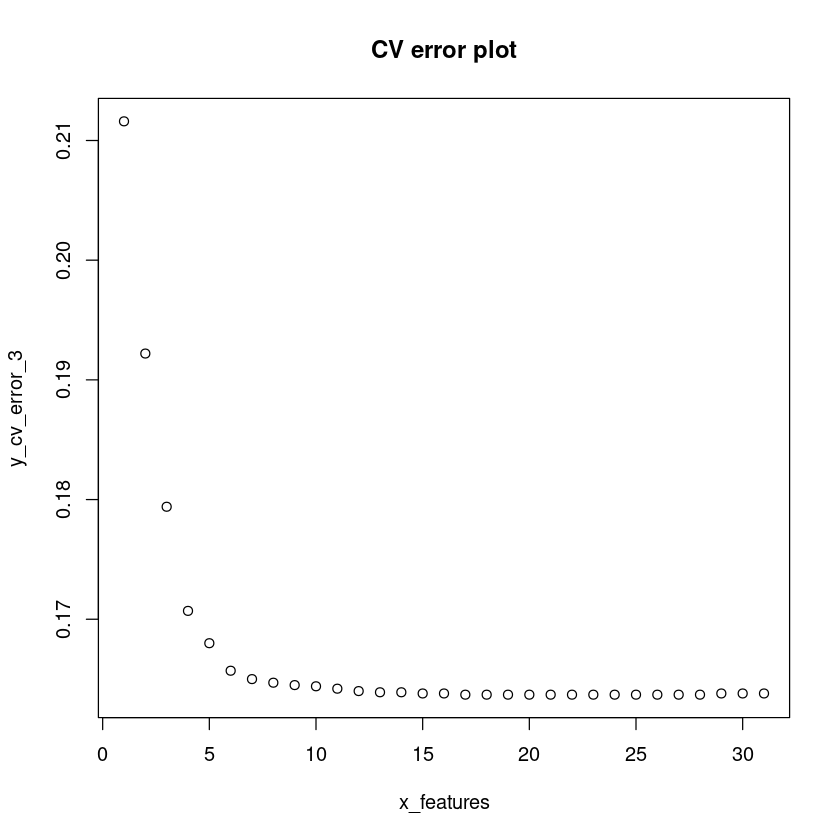

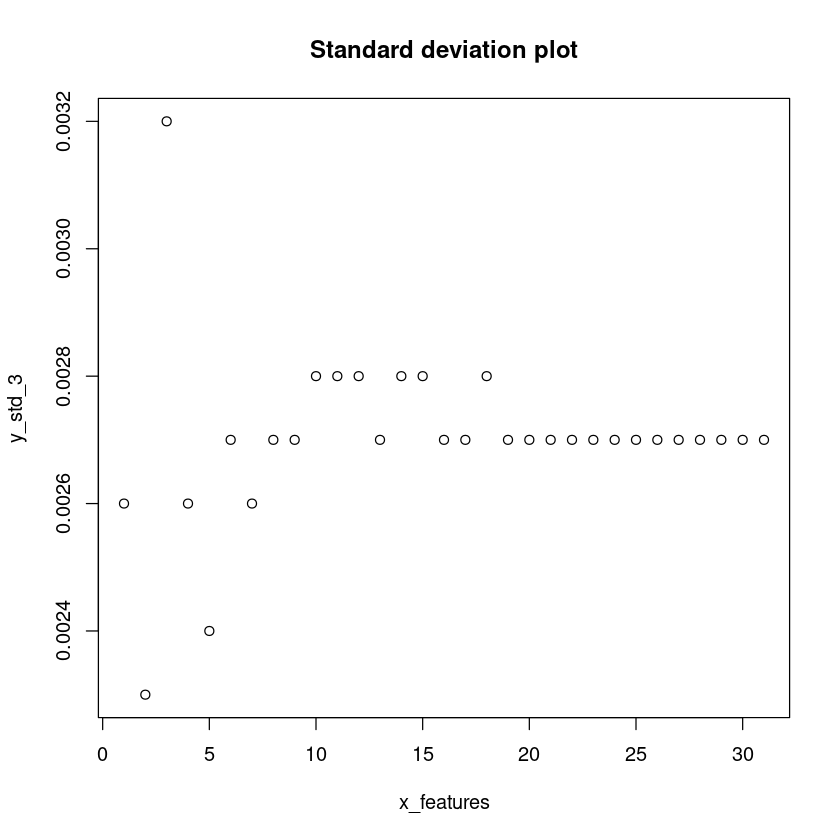

In [68]:
# CV error plot and Standard deviation plot 

x_features <- c(1:n)
y_cv_error_3 <- ccc
plot(x_features, y_cv_error_3, main='CV error plot')

y_std_3 <- eee
plot(x_features, y_std_3, main='Standard deviation plot')

The CV error and standard deviation plot are in the same ranges as the value that we observed with the two previous methods. 

The CV error plot indicates the CV error for all the features ranked by their correlation value. 
The standard deviation plot indicates the variability of the data for each feature. 

In [69]:
#Accuracy if we select 25, 20, 15, 10, 9, 8, 7, 6 and 5 features. 

#Accuracy if the number of selected features is 25 
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:25) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_25 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV_err_mean[selected_current],digits=4), " ; std dev=",round(CV_err_sd[selected_current],digits=4)))
    #we can attest that only the first 25 selected features were used to perfom 25 round of selection
 
}
                   
print(accuracy_results_25)

#Accuracy if the number of selected features is 20
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:20) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_20 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])

 
}
                   
print(accuracy_results_20)

#Accuracy if the number of selected features is 15
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:15) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_15 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])

 
}
                   
print(accuracy_results_15)

#Accuracy if the number of selected features is 10
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:10) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_10 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_10)

#Accuracy if the number of selected features is 9
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:9) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_9 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_9)

#Accuracy if the number of selected features is 8
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:8) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_8 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_8)

#Accuracy if the number of selected features is 7
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:7) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_7 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_7)

#Accuracy if the number of selected features is 6
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:6) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_6 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_6)

#Accuracy if the number of selected features is 5
#drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:5) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,seasonal_vaccine = Y_tr)
        
            # Model fit (using lm function)
            model<- lm(seasonal_vaccine~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
            
            #accuracy
            accuracy_results_5 <- get_accuracy(Y_hat_ts, Y_ts)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
 
}
                   
print(accuracy_results_5)

[1] "Round  1  ; Selected feature:  19  ; CV error= 0.2116  ; std dev= 0.0026"
[1] "Round  2  ; Selected feature:  11  ; CV error= 0.1922  ; std dev= 0.0023"
[1] "Round  3  ; Selected feature:  21  ; CV error= 0.1794  ; std dev= 0.0032"
[1] "Round  4  ; Selected feature:  18  ; CV error= 0.1707  ; std dev= 0.0026"
[1] "Round  5  ; Selected feature:  20  ; CV error= 0.168  ; std dev= 0.0024"
[1] "Round  6  ; Selected feature:  14  ; CV error= 0.1657  ; std dev= 0.0027"
[1] "Round  7  ; Selected feature:  2  ; CV error= 0.165  ; std dev= 0.0026"
[1] "Round  8  ; Selected feature:  23  ; CV error= 0.1647  ; std dev= 0.0027"
[1] "Round  9  ; Selected feature:  9  ; CV error= 0.1645  ; std dev= 0.0027"
[1] "Round  10  ; Selected feature:  12  ; CV error= 0.1644  ; std dev= 0.0028"
[1] "Round  11  ; Selected feature:  10  ; CV error= 0.1642  ; std dev= 0.0028"
[1] "Round  12  ; Selected feature:  26  ; CV error= 0.164  ; std dev= 0.0028"
[1] "Round  13  ; Selected feature:  22  ; CV error= 0

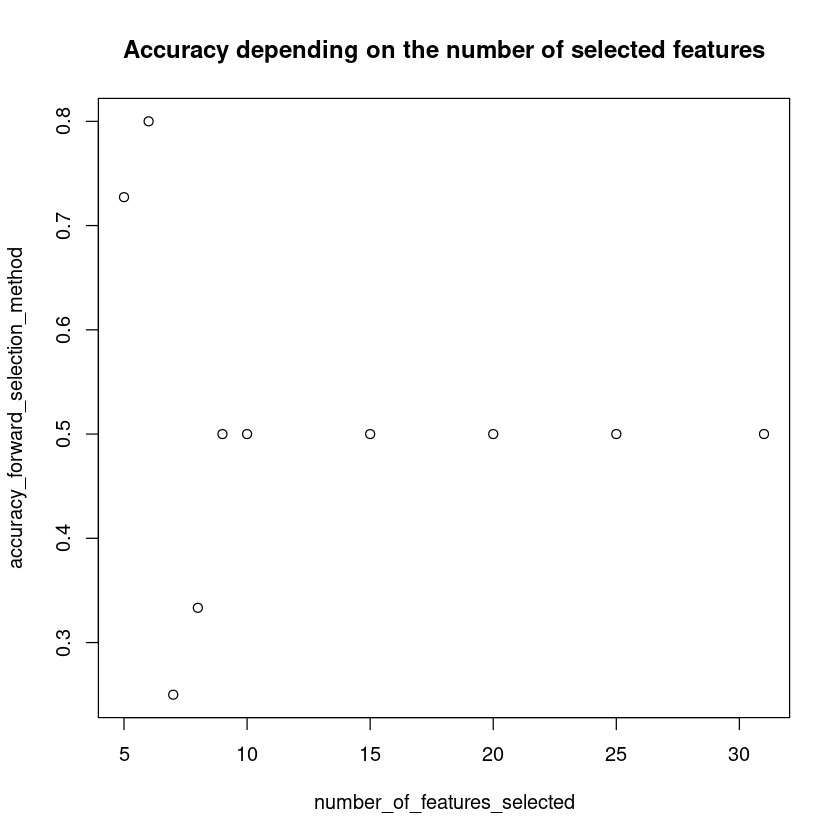

In [70]:
#Plot of the accuracy depending on the number of features. 

#Creation of the vector 
accuracy_forward_selection_method<- c(accuracy_31, accuracy_25, accuracy_20, accuracy_15, accuracy_10, accuracy_9, accuracy_8, accuracy_7, accuracy_6, accuracy_5)

#plot of accuracy
plot(number_of_features_selected, accuracy_forward_selection_method, main='Accuracy depending on the number of selected features')

We can observe that the accuracy have the lowest values when the features selected are 5. However, the performance of the model is only stable until 8 features are selected. 

## Comparison of the three feature selection approach - Seasonal vaccine

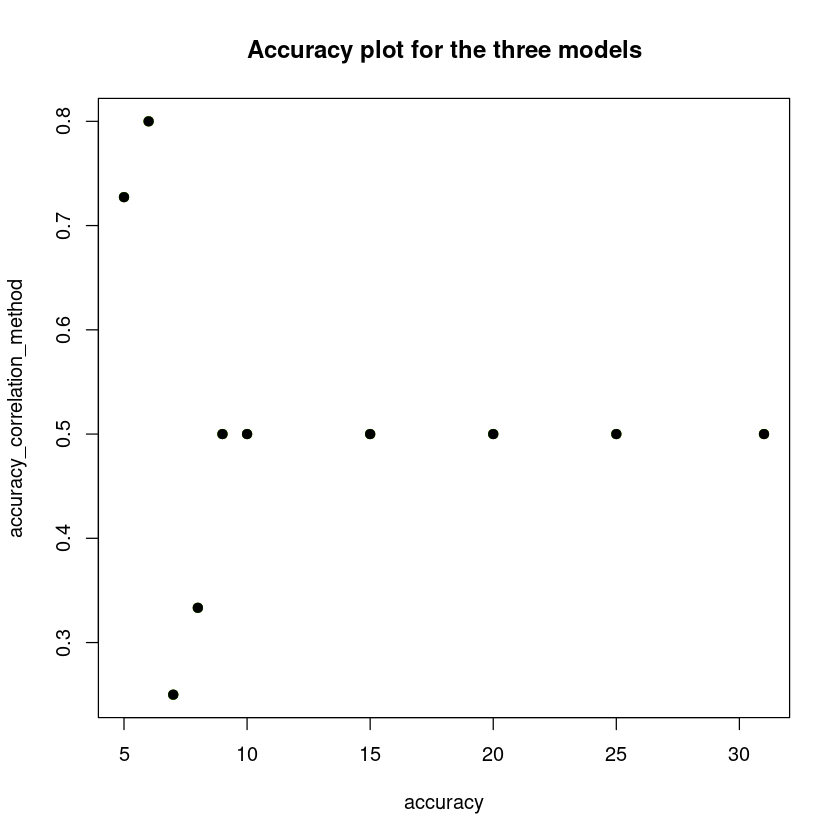

In [72]:
#Accuracy plot for the three models.  
#The accuracy for the correlation with the output approach is colored in red. 
#The accuracy for the mRMR approach is colored in green. 
#The accuracy for the forward selection method is colored in black. 

plot(number_of_features_selected,accuracy_correlation_method,pch = 19,col="red", main="Accuracy plot for the three models", xlab="accuracy")
points(number_of_features_selected,accuracy_mRMR_method,pch = 19,col="green")
points(number_of_features_selected,accuracy_forward_selection_method,pch = 19,col="black")

As for the h1n1 vaccine, we decided to plot the accuracy with two methods instead of three to ease the reading of the plot.

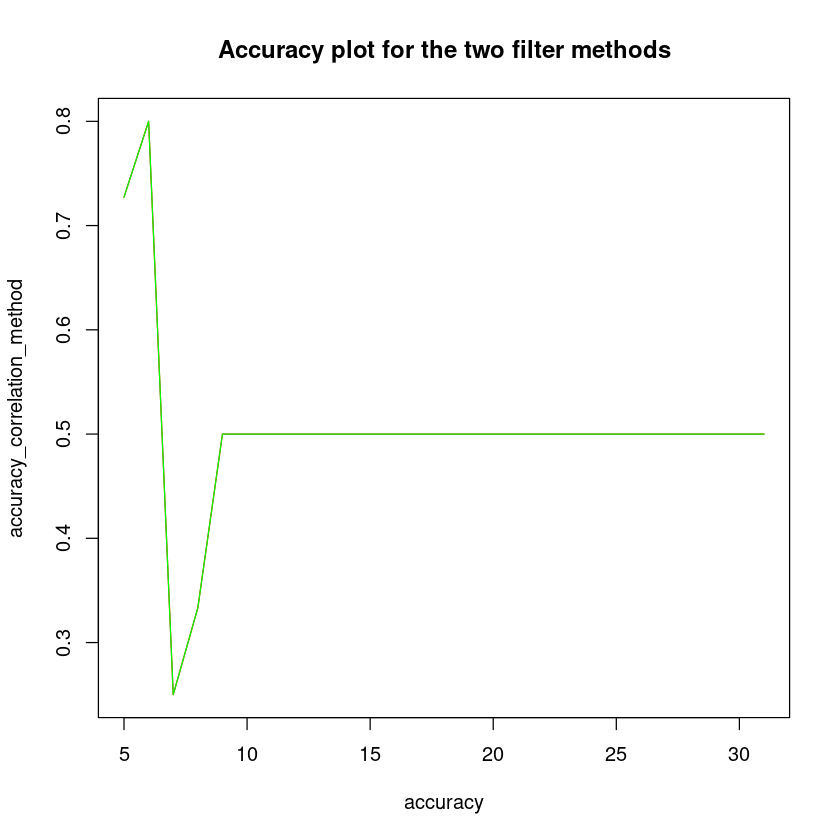

In [74]:
#Accuracy plot for the two filter methods. 

plot(number_of_features_selected,accuracy_correlation_method,type="l",col="red", main="Accuracy plot for the two filter methods", xlab="accuracy")
points(number_of_features_selected,accuracy_mRMR_method,type="l",col="green")

We can observe that the performance of the mRMR method is stable until we select 9 features and that the performance of the correlation with the output method is stable until we select 8 feature. 

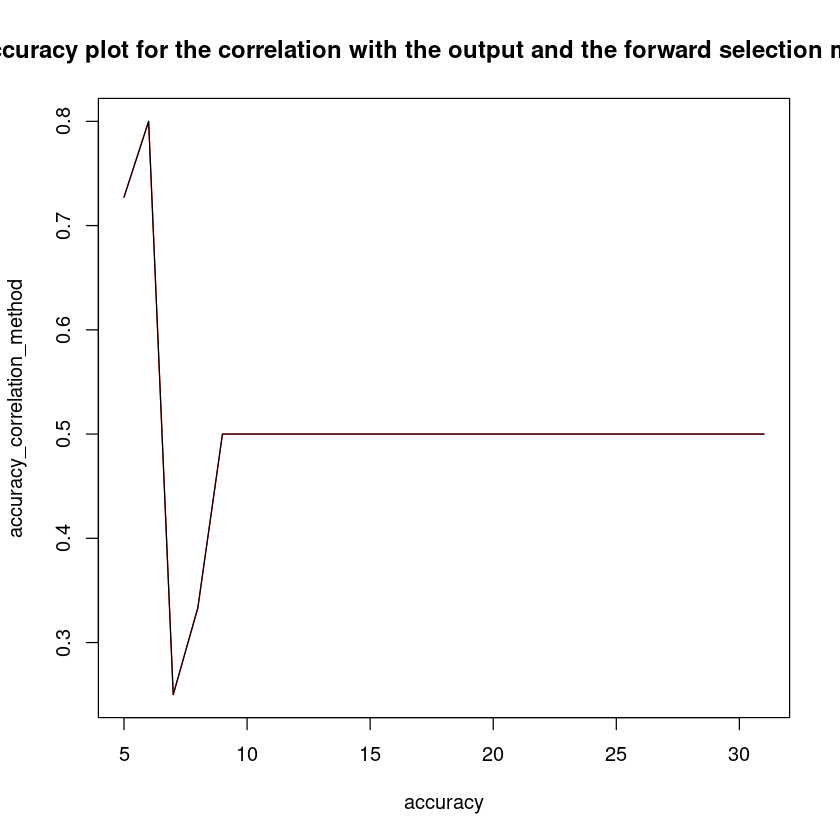

In [78]:
#Accuracy plot for the correlation with the output and the forward selection method

plot(number_of_features_selected,accuracy_correlation_method,type="l",col="red", main="Accuracy plot for the correlation with the output and the forward selection method", xlab="accuracy")
points(number_of_features_selected,accuracy_forward_selection_method,type="l",col="black")

The performance of the two methods are similar until we select 9 features.

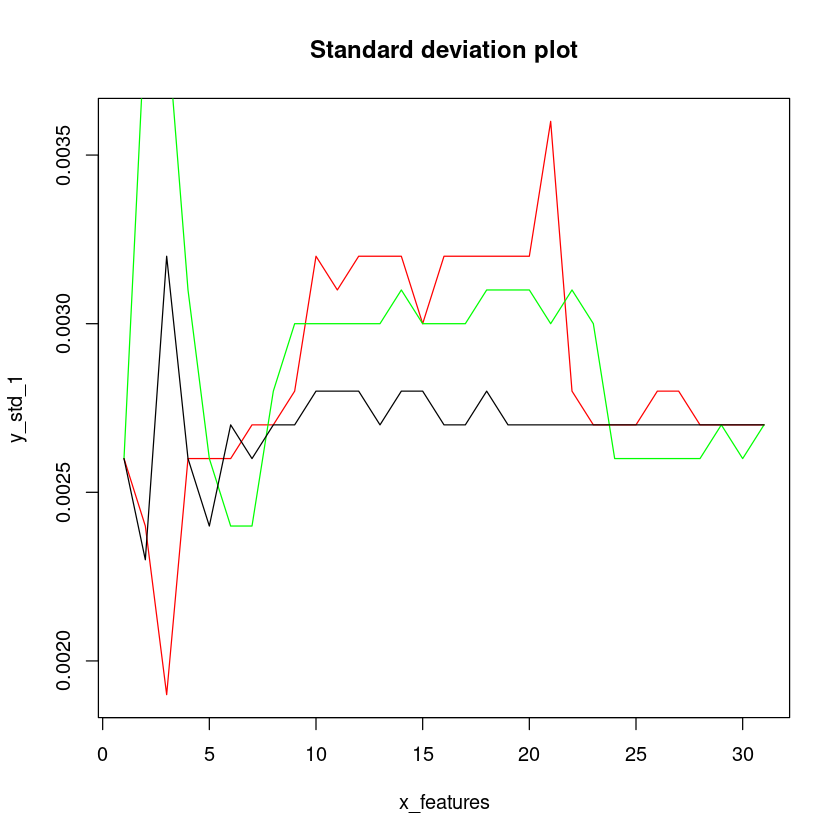

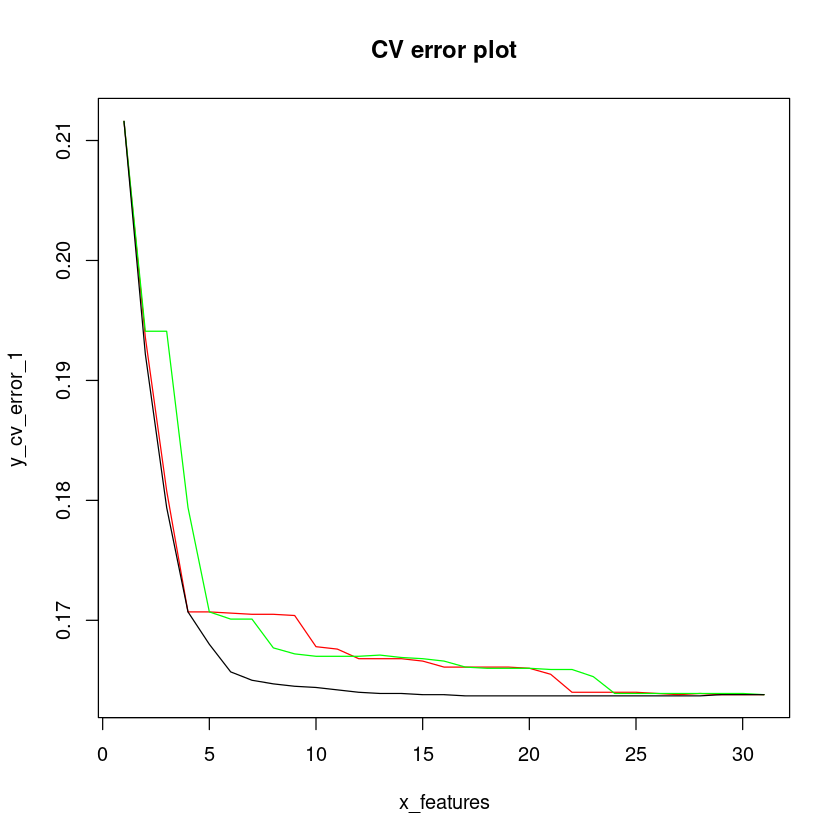

In [83]:
#CV error plot for the three methods.
plot(x_features, y_std_1, main='Standard deviation plot', type="l", col="red")
points(x_features,y_std_2,type="l",col="green")
points(x_features,y_std_3,type="l",col="black")

#Standard deviation plot for the three methods. 
plot(x_features, y_cv_error_1, type="l", main='CV error plot', col="red")
points(x_features,y_cv_error_2,type="l",col="green")
points(x_features,y_cv_error_3,type="l",col="black")

The observation that we made for the seasonal vaccine are very similar to the observation that we made for the h1n1 vaccine. 

We can observe that the standard deviation values for the three methods are in the same range and have similar values.
For the CV error values, we can observe that the cross-validation values are lower for the the forward selection method. 

As the accuracy of the correlation with the output and forward selection methods are similar, we chose the forward selection methods for our feature selection because the CV error were the lowest. 

In [84]:
#Creation of the seasonal vaccine_data frame with the selected features 
#Removing the last 7 features selected with the wrapper method

data_seasonal <- subset(data, select = -c(opinion_h1n1_vacc_effective, sex, behavioral_face_mask, h1n1_concern, employment_status, hhs_geo_region, behavioral_antiviral_meds))
data_seasonal




,respondent_id,h1n1_knowledge,behavioral_avoidance,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,⋯,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,marital_status,rent_or_own,census_msa,household_adults,household_children
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,1,1,0,0,0,⋯,1,2,4,1,4,2,1,3,0,0
2,1,2,1,1,0,1,1,0,0,0,⋯,2,4,2,2,4,2,2,1,0,0
3,2,1,1,0,0,0,0,0,0,1,⋯,1,2,1,3,4,2,1,1,2,0
4,3,1,1,1,1,0,0,0,1,1,⋯,4,1,5,2,4,2,2,2,0,0
5,4,1,1,1,1,0,1,0,0,0,⋯,1,4,3,4,4,1,1,1,1,0
6,5,1,1,1,0,0,1,0,1,0,⋯,4,4,5,2,4,1,1,2,2,3
7,6,0,0,0,0,0,0,0,0,0,⋯,2,1,4,1,4,2,1,1,0,0
8,7,0,1,1,0,0,1,1,0,1,⋯,2,1,3,4,4,1,1,3,2,0
9,8,2,1,1,1,1,1,0,0,0,⋯,2,1,3,3,4,1,1,1,1,0


# Model selection

In this section, we selected three models : Neural Network, Decision tree, Random Forest. Our goal is to configure these models and optimize their parameters. After optimization, we train the model using the dataset from the previous feature selection step. 
From the previous feature selection step, we managed to find the features that are relevant to our predictor, the seasonal vaccine or the h1n1 vaccinel. Afterwards, we will split our data into two sets:
	Training data: data used for the model to learn on.
	Test/validation data: unseen data that hasn’t been trained on.. 


In [85]:
#dividing data and labels into taining and test sets
set.seed(1)
smp_size <- floor(0.75 * nrow(data))# we chose 75% as the splitting ratio for our data
train_ind <- sample(seq_len(nrow(data)),size=smp_size)

data_h1n1_train <- data_h1n1[train_ind,]
data_h1n1_test <- data_h1n1[-train_ind,]
data_seasonal_test <- data_seasonal[-train_ind,]
data_seasonal_train <- data_seasonal[train_ind,]

From our labels datasets, we extract two dataset for each vaccine, with their relevant target labels and merge them with their respective training data.

We also remove the column “respondent_id” as this column is containing unique ids.


In [86]:
YYYY_hn = labels[, c('respondent_id','h1n1_vaccine')]
YYYY_ss = labels[, c('respondent_id','seasonal_vaccine')]

YYYY_hn$respondent_id= as.numeric(unlist(YYYY_hn$respondent_id))
YYYY_ss$respondent_id = as.numeric(unlist(YYYY_ss$respondent_id))
YYYY_hn$h1n1_vaccine= as.numeric(unlist(YYYY_hn$h1n1_vaccine))
YYYY_ss$seasonal_vaccine= as.numeric(unlist(YYYY_ss$seasonal_vaccine))

YYYY_hn_train = YYYY_hn[train_ind,]
YYYY_ss_train = YYYY_ss[train_ind,]
YYYY_hn_test = YYYY_hn[-train_ind,]
YYYY_ss_test = YYYY_ss[-train_ind,]

In [87]:
#removing the unique identifier from our data
data_h1n1_train <- merge(data_h1n1_train, YYYY_hn_train)
data_h1n1_train <- subset(data_h1n1_train , select=-respondent_id)
data_seasonal_train <- merge(data_seasonal_train, YYYY_ss_train)
data_seasonal_train <- subset(data_seasonal_train , select=-respondent_id)

data_h1n1_test <- subset(data_h1n1_test,select=-respondent_id)
data_seasonal_test <- subset(data_seasonal_test,select=-respondent_id)


## Model 1

## Neural network

Our first model is model is a neural network. NN are connected nodes within layers. The first layer is called an input layer and the last one is called an output layer. These two are connected by layers and between them are hidden layers. The nodes within the layers relate to the nodes in the next/previous layers through weights that are updatable during the training of the network.
The parameters we have chose for our network after experimentation are:
	Size: number of nodes of the layer.
	Maxit: the number of iteration that our learning will go through.
	Rang= that value that will be given when initializing the weight values.


In [88]:
#data for nnet
set.seed(1)
data_train_NN <- data_h1n1_train
data_train_NN$h1n1_vaccine <- as.factor(data_train_NN$h1n1_vaccine)
data_test_NN <- data_h1n1_test
data_real_NN <- YYYY_hn_test

In [89]:
model_NN <- nnet(h1n1_vaccine ~ ., data=data_train_NN,size=5,skip=FALSE,trace=T, maxit=200,rang=0.02)
model_NN

Y_NN_pred <- predict(model_NN,data_test_NN)
Y_NN_remodled <- ifelse(Y_NN_pred > 0.5,"h1n1","nonh1n1")
Y_NN_real <- ifelse(data_real_NN$h1n1_vaccine==1,"h1n1","nonh1n1")
Y_NN_pred <- data.frame(Y_NN_pred)

# weights:  131
initial  value 13828.580028 
iter  10 value 9536.409781
iter  20 value 8290.565720
iter  30 value 7940.509888
iter  40 value 7759.100539
iter  50 value 7681.479849
iter  60 value 7630.592464
iter  70 value 7607.847708
iter  80 value 7589.866469
iter  90 value 7570.471234
iter 100 value 7561.323017
iter 110 value 7555.146377
iter 120 value 7552.479260
iter 130 value 7547.993601
iter 140 value 7541.468131
iter 150 value 7523.116654
iter 160 value 7508.606646
iter 170 value 7500.732222
iter 180 value 7495.602229
iter 190 value 7487.052501
iter 200 value 7480.658084
final  value 7480.658084 
stopped after 200 iterations


a 24-5-1 network with 131 weights
inputs: h1n1_concern h1n1_knowledge behavioral_antiviral_meds behavioral_face_mask behavioral_large_gatherings doctor_recc_h1n1 doctor_recc_seasonal chronic_med_condition child_under_6_months health_worker opinion_h1n1_vacc_effective opinion_h1n1_risk opinion_seas_vacc_effective opinion_seas_risk opinion_seas_sick_from_vacc age_group education race sex marital_status rent_or_own employment_status census_msa household_children 
output(s): h1n1_vaccine 
options were - entropy fitting 

In [90]:
eval_NN_hn <- data.frame(
    NN_h1n1=evaluative_matrix(Y_NN_remodled ,Y_NN_real),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)
eval_NN_hn

,NN_h1n1
,<dbl>
Acc,0.8331586
F1,0.8985613
TPR,0.8619846
FPR,0.3399790


We get that the accuracy is about 83% whne runnning through 200 iterations and using 5 nodes per layer in our hidden layer. We also observed that the False positive rate is around 34%.

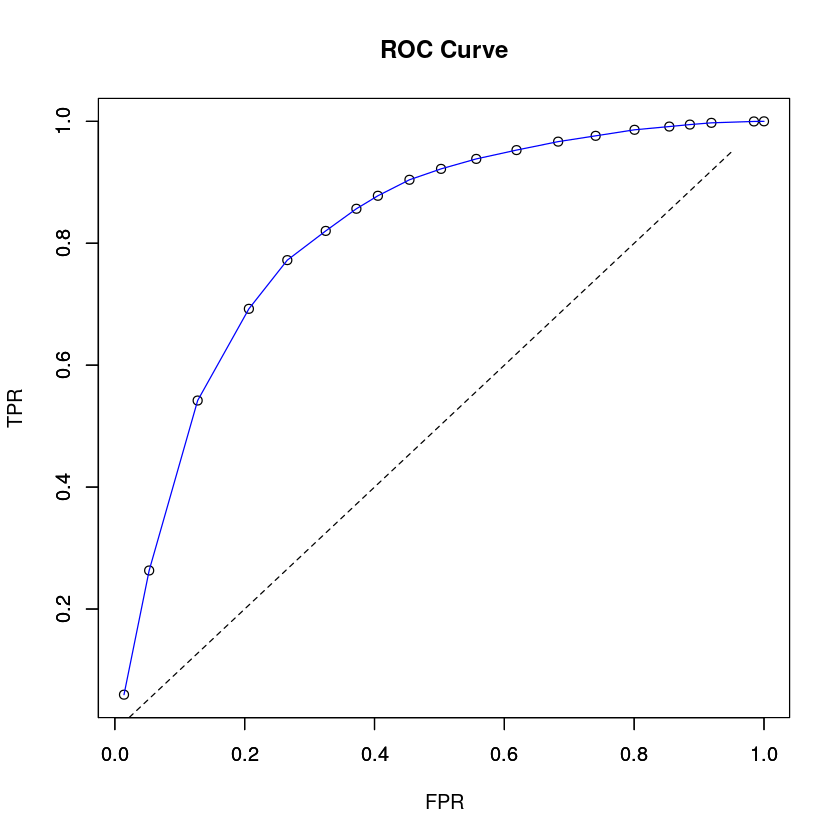

In [91]:
get_roc(Y_NN_pred,Y_NN_real,"h1n1","nonh1n1")

As we can see the graph for the NN model provides the closest value to the ideal clinical discriminator for h1n1.


#### seasonal

In [92]:
#data for nnet
set.seed(1)
data_train_NN_seasonal <- data_seasonal_train
data_train_NN_seasonal$seasonal_vaccine <- as.factor(data_train_NN_seasonal$seasonal_vaccine)
data_test_NN_seasonal <- data_seasonal_test
data_real_NN_seasonal <- YYYY_ss_test

In [93]:
model_NN_seasonal <- nnet(seasonal_vaccine ~ ., data=data_train_NN_seasonal,size=5,skip=FALSE,trace=T, maxit=200,rang=0.02)
model_NN_seasonal

Y_NN_pred_seasonal <- predict(model_NN_seasonal,data_test_NN_seasonal)
Y_NN_remodled_seasonal <- ifelse(Y_NN_pred_seasonal > 0.5,"seasonal","nonseasonal")
Y_NN_real_seasonal <- ifelse(data_real_NN_seasonal$seasonal_vaccine==1,"seasonal","nonseasonal")
Y_NN_pred_seasonal <- data.frame(Y_NN_pred_seasonal)

# weights:  131
initial  value 13877.472137 
iter  10 value 12517.303380
iter  20 value 11830.513957
iter  30 value 10485.187168
iter  40 value 10035.886336
iter  50 value 9830.623821
iter  60 value 9790.427430
iter  70 value 9766.588002
iter  80 value 9743.814717
iter  90 value 9717.450458
iter 100 value 9700.289386
iter 110 value 9683.827328
iter 120 value 9670.115970
iter 130 value 9654.195192
iter 140 value 9634.737478
iter 150 value 9609.903661
iter 160 value 9597.112843
iter 170 value 9579.947455
iter 180 value 9570.573195
iter 190 value 9565.167827
iter 200 value 9554.782823
final  value 9554.782823 
stopped after 200 iterations


a 24-5-1 network with 131 weights
inputs: h1n1_knowledge behavioral_avoidance behavioral_wash_hands behavioral_large_gatherings behavioral_outside_home behavioral_touch_face doctor_recc_h1n1 doctor_recc_seasonal chronic_med_condition child_under_6_months health_worker opinion_h1n1_risk opinion_h1n1_sick_from_vacc opinion_seas_vacc_effective opinion_seas_risk opinion_seas_sick_from_vacc age_group education race marital_status rent_or_own census_msa household_adults household_children 
output(s): seasonal_vaccine 
options were - entropy fitting 

In [94]:
eval_NN_ss <- data.frame(
    NN_seasonal=evaluative_matrix(Y_NN_remodled_seasonal ,Y_NN_real_seasonal),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)
eval_NN_ss

,NN_seasonal
,<dbl>
Acc,0.7737008
F1,0.7562510
TPR,0.7637667
FPR,0.2178492


We get that the accuracy is about 77% when runnning through 200 iterations and using 5 nodes per layer in our hidden layer. We also observed that the False positive rate is around 22%. we noticed that even though the learning on the seasonal vaccine generated lower accuracy it managed to produce lower FPR. The reason the acccuracy is lower probaly due to the more balanced classes in the seasonal vaccine.

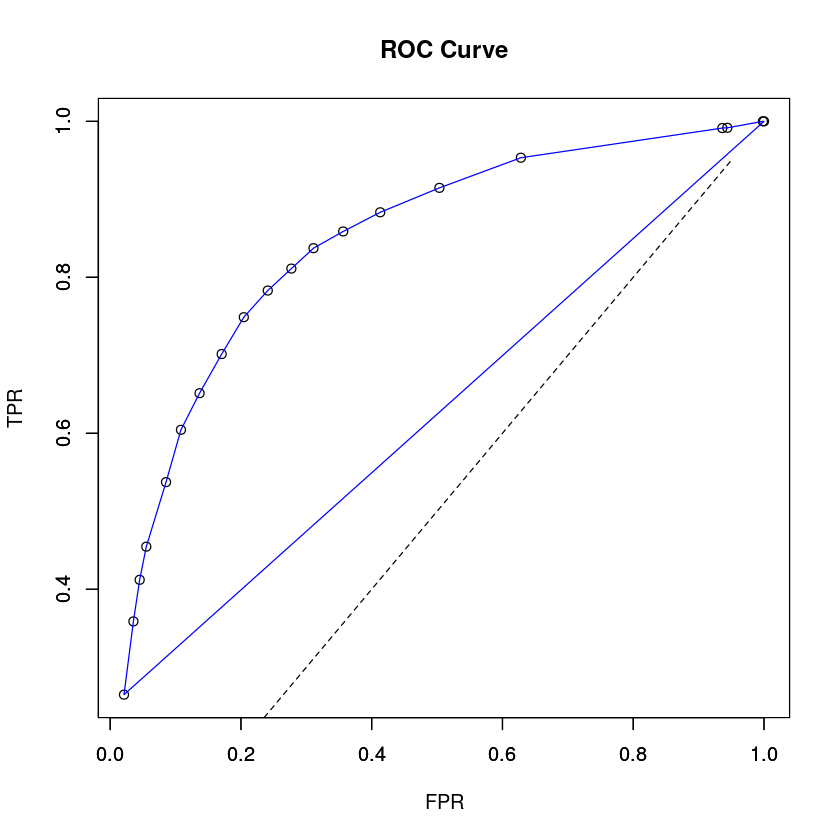

In [95]:
get_roc(Y_NN_pred_seasonal,Y_NN_real_seasonal,"seasonal","nonseasonal")


The error with the graph due to our function interpreting not existing as null instead of zero. The rest of the graph is correct and can be used to assess the model (we compared by building the graph with out the function).
The RAs we can see the graph for the NN model provides the closest value to the ideal clinical discriminator for seasonal vaccine.

## Model 2

### decision tree

Our second model is a Decision tree. DT is a supervised learning method used mostly for classification and regression. The data is continuously split according to a certain parameters. It’s composed of decision nodes that denote an attribute and leaves that denote class labels. We employ DT as they provide clear visualization of the model and does not require any feature scalling and are fast when training. At the same time in our analysis, we are taking into account that DT are prone to over-fitting and can have high variance. 
The parameters used are:
	CP: complexity parameter is used to control the optimal size of the tree and select the optimal tree size.


In [96]:
data_train_DT = data_h1n1_train
data_train_DT$h1n1_vaccine = ifelse(data_train_DT$h1n1_vaccine==1,"h1n1","nonh1n1")
data_real_DT = YYYY_hn_test
data_test_DT = data_h1n1_test

In [97]:
tree <- rpart(h1n1_vaccine ~ ., data = data_train_DT, control = rpart.control(cp = 0.0001))

In [98]:
printcp(tree)


Classification tree:
rpart(formula = h1n1_vaccine ~ ., data = data_train_DT, control = rpart.control(cp = 1e-04))

Variables actually used in tree construction:
 [1] age_group                   behavioral_antiviral_meds  
 [3] behavioral_face_mask        behavioral_large_gatherings
 [5] census_msa                  child_under_6_months       
 [7] chronic_med_condition       doctor_recc_h1n1           
 [9] doctor_recc_seasonal        education                  
[11] employment_status           h1n1_concern               
[13] h1n1_knowledge              health_worker              
[15] household_children          marital_status             
[17] opinion_h1n1_risk           opinion_h1n1_vacc_effective
[19] opinion_seas_risk           opinion_seas_sick_from_vacc
[21] opinion_seas_vacc_effective race                       
[23] rent_or_own                 sex                        

Root node error: 4255/20030 = 0.21243

n= 20030 

           CP nsplit rel error  xerror     xstd
1  0.07

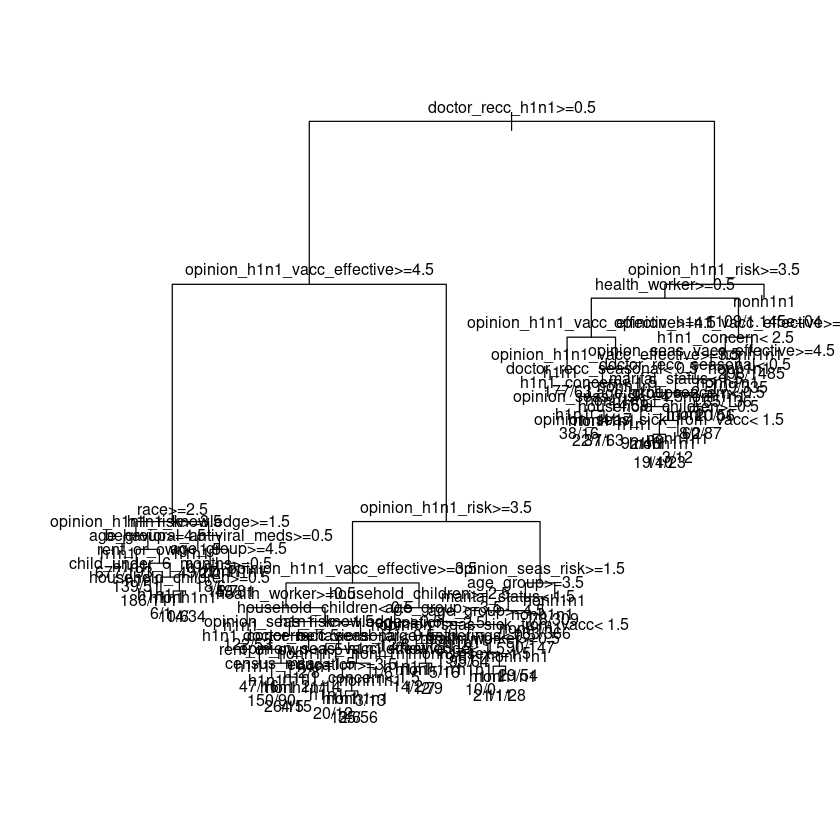

In [99]:
bestcp <- tree$cptable[which.min(tree$cptable[,"xerror"]),"CP"]
tree.pruned <- prune(tree, cp = bestcp)
plot(tree.pruned)
text(tree.pruned, cex = 0.8, use.n = TRUE, xpd = TRUE)


Using the decision tree, we can better understand the variables and the role they play in our model.
From the above we can see that for the DT, the variables that play a role are the behavioral features as “opinion_h1n1_vacc_effective” , “doctor_rec_h1n1”, “opinion_h1n1”. This explains that for our residents, if given value that their doctor recommends the vaccine is higher than .5 then they are more likely going to take the vaccine if the effectiveness and risk of the getting infected with h1n1 is low. While if the doctor doesn’t recommend the vaccine and the risk of getting infected is low then most residents won’t consider getting the vaccine unless they are health workers.
The absence of variables such as invoice, age, sex is logical considering that the vaccines are provided for free and that they are suitable for all age groups and sexes. 


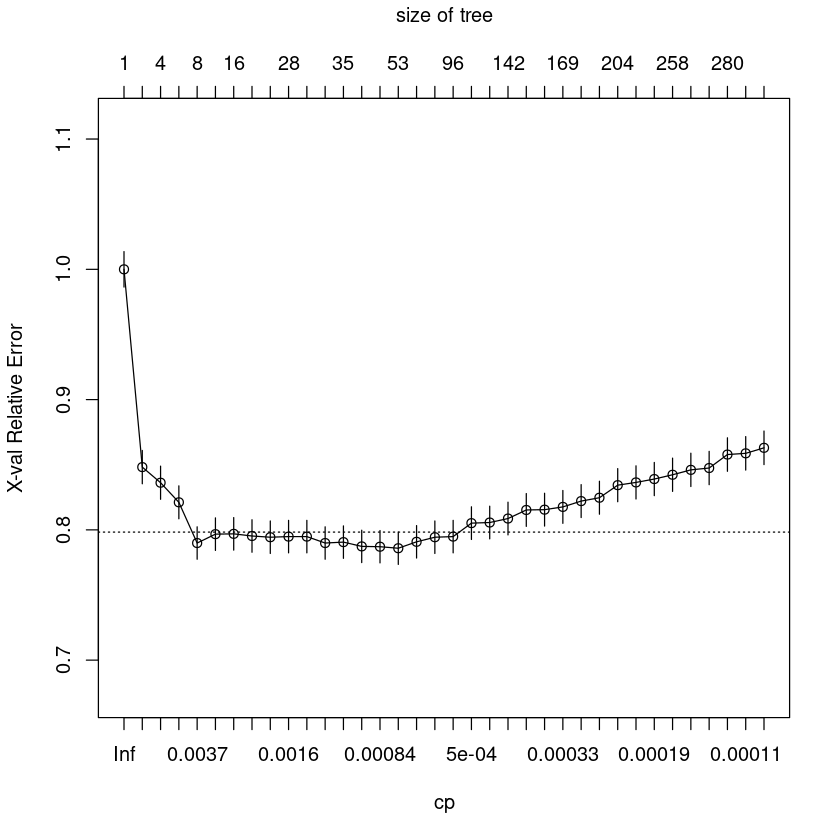

In [100]:
#printcp(tree) # display the results
plotcp(tree) # visualize cross-validation results
#summary(tree) # detailed summary of splits

In [101]:
data.frame(tree$variable.importance)

,tree.variable.importance
,<dbl>
doctor_recc_h1n1,1045.03170
opinion_h1n1_risk,353.99442
opinion_h1n1_vacc_effective,319.78108
doctor_recc_seasonal,262.70603
opinion_seas_risk,136.34427
health_worker,132.37426
opinion_seas_vacc_effective,120.18511
h1n1_concern,99.38921
age_group,98.42436


We can see that the most important variables are like what we saw in the tree, opinion_h1n1_risk and doctor_recc_h1n1 and opinion_h1n1_vacc_effective. What is interesting is that in the variable importance, we can see that opinion_seas_risk and doctor_recc_seasonal also play a role in determining whether a resident will take the h1n1 vaccine.


In [102]:
Y_DT_pred <- predict(tree,data_test_DT)
Y_DT_pred <- data.frame(Y_DT_pred)

In [103]:
Y_DT_remodled<- ifelse(Y_DT_pred$h1n1 > 0.5,"h1n1","nonh1n1")
Y_DT_real = ifelse(data_real_DT$h1n1_vaccine==1,"h1n1","nonh1n1")

eval_DT_hn <- data.frame(
    DT_h1n1=evaluative_matrix(Y_DT_remodled,Y_DT_real),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

In [104]:
Y_DT_real = data.frame(Y_DT_real)
Y_DT_remodled = data.frame(Y_DT_remodled)
Y_DT_remodled = ifelse(Y_DT_remodled=="nonh1n1",0,1)
Y_DT_real = ifelse(Y_DT_real=="nonh1n1",0,1)

,DT_h1n1
,<dbl>
Acc,0.8111427
F1,0.8840460
TPR,0.8557949
FPR,0.4254717


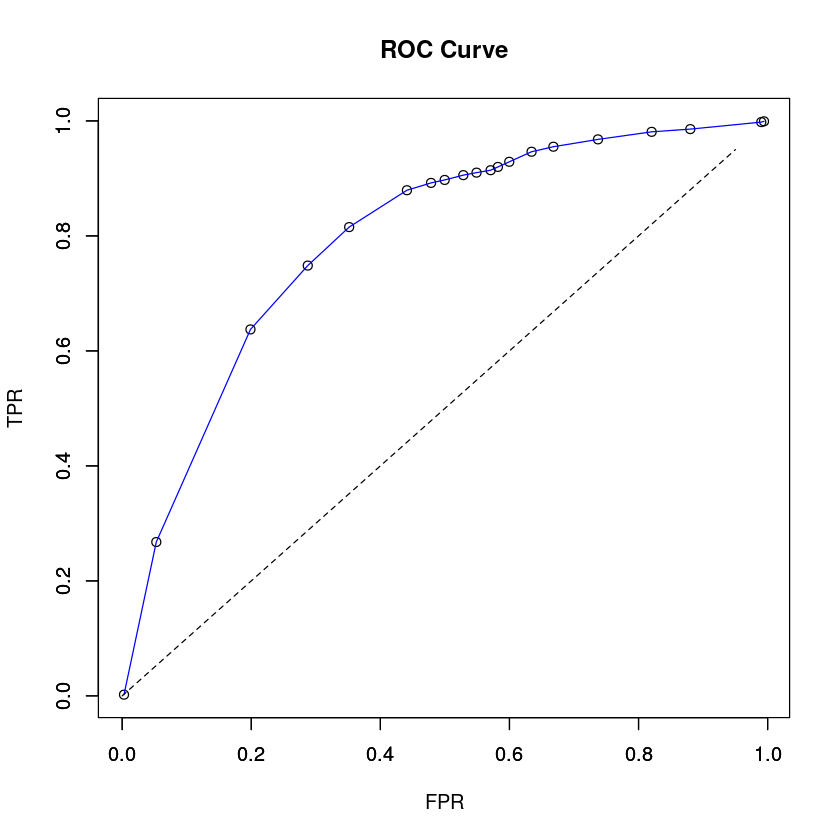

In [105]:
Y_DT_real = ifelse(data_real_DT$h1n1_vaccine==1,"h1n1","nonh1n1")
Y_DT_pred<-predict(tree,data_test_DT)
Y_DT_pred = data.frame(Y_DT_pred)
Y_DT_pred = Y_DT_pred$h1n1

get_roc(Y_DT_pred,Y_DT_real,"h1n1","nonh1n1")
eval_DT_hn

We can see that the trade-off between the sensitivity and specificity for the DT gives a curve that is closer to the left corner. With an accuracy of 81%.  The lower value for FPR has been possible due to the fact that DT manages to spot the rare occurences and not ignore them by biasing towards the most freauaent independent values.


#### seasonal

In [106]:
#tree_seasonal working good
set.seed(1)
data_train_DT_seasonal = data_seasonal_train
data_train_DT_seasonal$seasonal_vaccine = ifelse(data_train_DT_seasonal$seasonal_vaccine==1,"seasonal","nonseasonal")
data_real_DT_seasonal = YYYY_ss_test
data_test_DT_seasonal = data_seasonal_test

In [107]:
tree_seasonal <- rpart(seasonal_vaccine ~ ., data = data_train_DT_seasonal, control = rpart.control(cp = 0.0001))

In [108]:
printcp(tree_seasonal)


Classification tree:
rpart(formula = seasonal_vaccine ~ ., data = data_train_DT_seasonal, 
    control = rpart.control(cp = 1e-04))

Variables actually used in tree construction:
 [1] age_group                   behavioral_avoidance       
 [3] behavioral_large_gatherings behavioral_outside_home    
 [5] behavioral_touch_face       behavioral_wash_hands      
 [7] census_msa                  child_under_6_months       
 [9] chronic_med_condition       doctor_recc_h1n1           
[11] doctor_recc_seasonal        education                  
[13] h1n1_knowledge              health_worker              
[15] household_adults            household_children         
[17] marital_status              opinion_h1n1_risk          
[19] opinion_h1n1_sick_from_vacc opinion_seas_risk          
[21] opinion_seas_sick_from_vacc opinion_seas_vacc_effective
[23] race                        rent_or_own                

Root node error: 9305/20030 = 0.46455

n= 20030 

           CP nsplit rel error  xerro

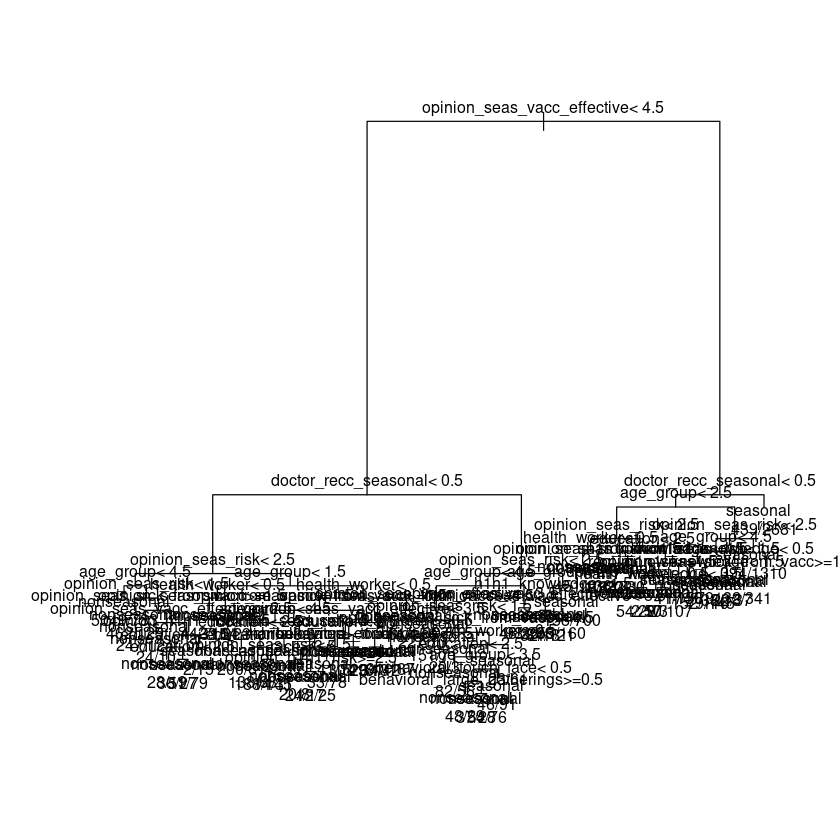

In [109]:
bestcp <- tree_seasonal$cptable[which.min(tree_seasonal$cptable[,"xerror"]),"CP"]
tree_seasonal.pruned <- prune(tree_seasonal, cp = bestcp)
plot(tree_seasonal.pruned)
text(tree_seasonal.pruned, cex = 0.8, use.n = TRUE, xpd = TRUE)

From the start, we notice that the decision tree for seasonal vaccine model contain more nodes and leaves. The reason is that the h1n1 virus is recent and is free and there is a lot of risk involved that are needed to be taken into consideration, while the seasonal vaccine is not free and restricted to certain age groups and only those with higher education understand the importance of the vaccine.


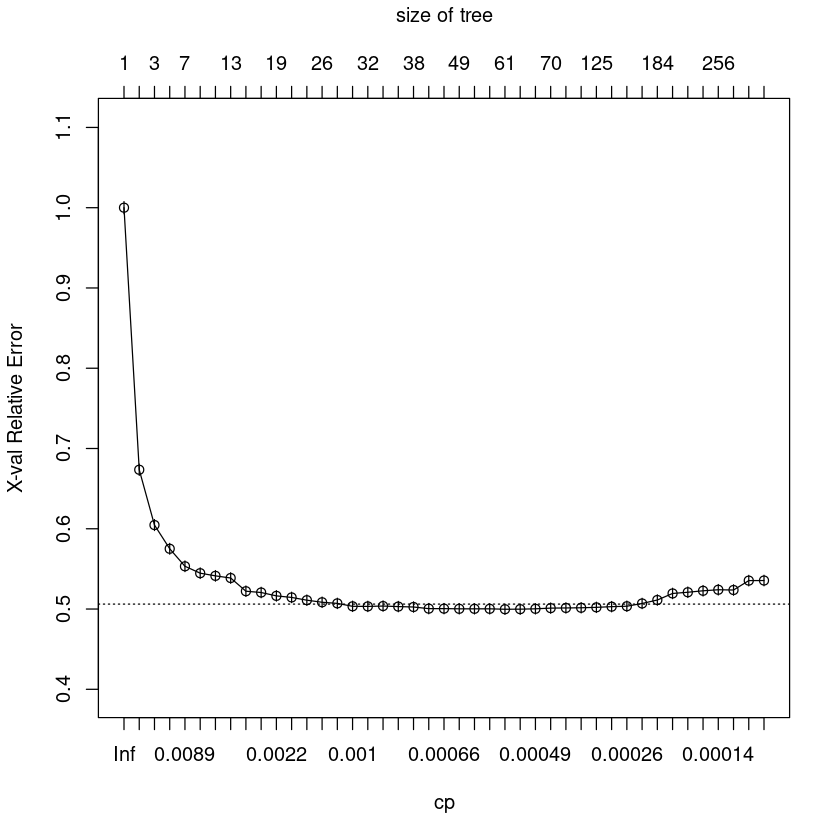

In [110]:
#printcp(tree_seasonal) # display the results
plotcp(tree_seasonal) # visualize cross-validation results
#summary(tree_seasonal) # detailed summary of splits

In [111]:
data.frame(tree_seasonal$variable.importance)

,tree_seasonal.variable.importance
,<dbl>
opinion_seas_vacc_effective,1479.58201
doctor_recc_seasonal,921.10052
opinion_seas_risk,811.00247
age_group,487.71096
doctor_recc_h1n1,441.97172
opinion_h1n1_risk,351.38185
opinion_seas_sick_from_vacc,187.17111
education,155.91807
opinion_h1n1_sick_from_vacc,154.77344


The table above shows that the opinion on the effectiveness and risk associated with the seasonal vaccine do play an important role even though the use of the vaccine has been widely spread. The additional thing taken into consideration the age group due to the age limitation on the vaccine and the education level since the more residents that understand the role of the vaccine and its benefits, the more they are to take it. We also see an involvement of opinion_h1n1_risk, doctor_h1n1_vacc_effective as we interpret this result as people looking for substitute to the h1n1_vaccine in case the effective is low 


In [112]:
Y_DT_pred_seasonal <- predict(tree_seasonal,data_test_DT_seasonal)
Y_DT_pred_seasonal <- data.frame(Y_DT_pred_seasonal)

In [113]:
Y_DT_remodled_seasonal<- ifelse(Y_DT_pred_seasonal$seasonal > 0.5,"seasonal","nonseasonal")
Y_DT_real_seasonal = ifelse(data_real_DT_seasonal$seasonal_vaccine==1,"seasonal","nonseasonal")

eval_DT_ss <- data.frame(
    DT_seasonal=evaluative_matrix(Y_DT_remodled_seasonal,Y_DT_real_seasonal),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

In [114]:
Y_DT_real_seasonal = data.frame(Y_DT_real_seasonal)
Y_DT_remodled_seasonal = data.frame(Y_DT_remodled_seasonal)
Y_DT_remodled_seasonal = ifelse(Y_DT_remodled_seasonal=="nonseasonal",0,1)
Y_DT_real_seasonal = ifelse(Y_DT_real_seasonal=="nonseasonal",0,1)

,DT_seasonal
,<dbl>
Acc,0.7545305
F1,0.7377180
TPR,0.7390189
FPR,0.2318718


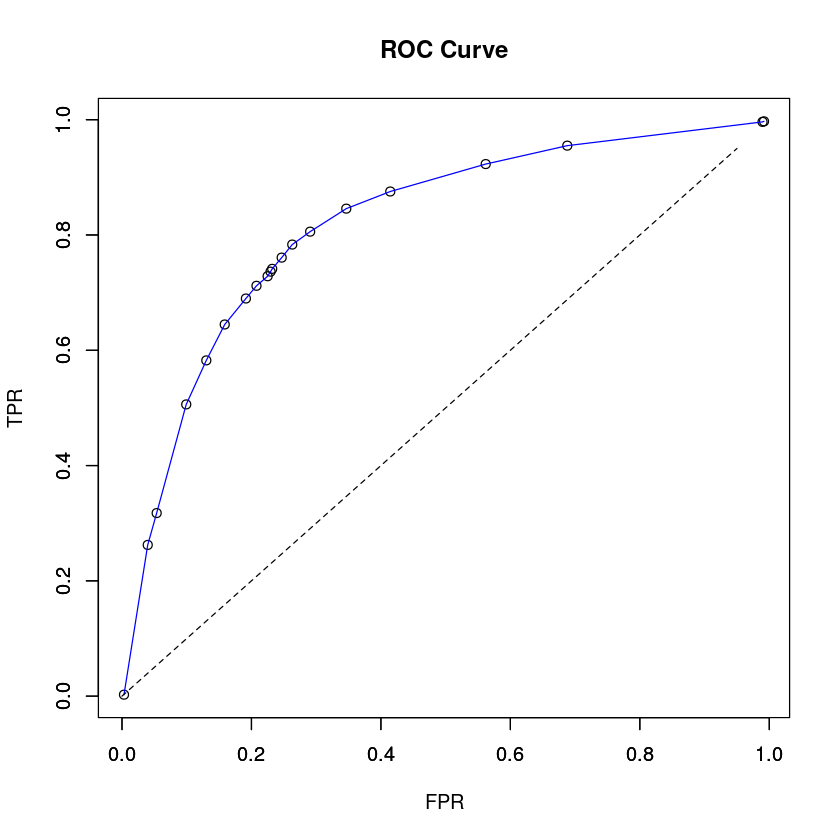

In [115]:
Y_DT_real_seasonal = ifelse(data_real_DT_seasonal$seasonal_vaccine==1,"seasonal","nonseasonal")
Y_DT_pred_seasonal<-predict(tree_seasonal,data_test_DT_seasonal)
Y_DT_pred_seasonal = data.frame(Y_DT_pred_seasonal)
Y_DT_pred_seasonal = Y_DT_pred_seasonal$seasonal

eval_DT_ss
get_roc(Y_DT_pred_seasonal,Y_DT_real_seasonal,"seasonal","nonseasonal")

In the case of seasonal data we see that the ROC curve faster than h1n1 data which is show in the lower False positive rate 23% but at the same time the accuracy is lower 75%.

## Model 3

### Random forest


Our Third model is Random Forest. RF is like DT except that it combines multiple classifiers (multiple decision tress). They are more effective than DT and don’t need as much hyper-parameter tuning. It also solves the issue of over-fitting that DT have, as in every random forest tree, a subset of features is selected randomly at the splitting node.



In [121]:
set.seed(1)
data_real_RF = YYYY_hn_test
data_train_Y_RF = YYYY_hn_train
data_train_RF <- subset(data_h1n1_train, select=-h1n1_vaccine)
data_test_RF <- data_h1n1_test

In [122]:
rf <- randomForest( data_train_RF, as.factor( data_train_Y_RF$h1n1_vaccine ), ntree = 150, do.trace = 10 )  # mtry = nvars
p <- predict( rf, data_test_RF, type = 'prob' )

ntree      OOB      1      2
   10:  27.22% 10.69% 88.65%
   20:  24.13%  5.25% 94.10%
   30:  22.76%  2.68% 97.23%
   40:  22.17%  1.69% 98.10%
   50:  21.87%  1.14% 98.73%
   60:  21.70%  0.87% 98.92%
   70:  21.56%  0.62% 99.20%
   80:  21.52%  0.52% 99.39%
   90:  21.42%  0.35% 99.53%
  100:  21.40%  0.30% 99.60%
  110:  21.38%  0.31% 99.51%
  120:  21.38%  0.25% 99.74%
  130:  21.35%  0.20% 99.76%
  140:  21.35%  0.21% 99.74%
  150:  21.31%  0.15% 99.74%


In [123]:
Y_RF_pred = data.frame(p)
Y_RF_pred$h1n1 = ifelse(Y_RF_pred$X0>0.5,0,1)
Y_RF_pred <- ifelse(Y_RF_pred$h1n1==1,"h1n1","nonh1n1")

In [124]:
Y_RF_real = ifelse(data_real_RF$h1n1_vaccine==1,"h1n1","nonh1n1")

,RF_h1n1
,<dbl>
Acc,0.7868803
F1,0.8806508
TPR,0.7876969
FPR,0.6666667


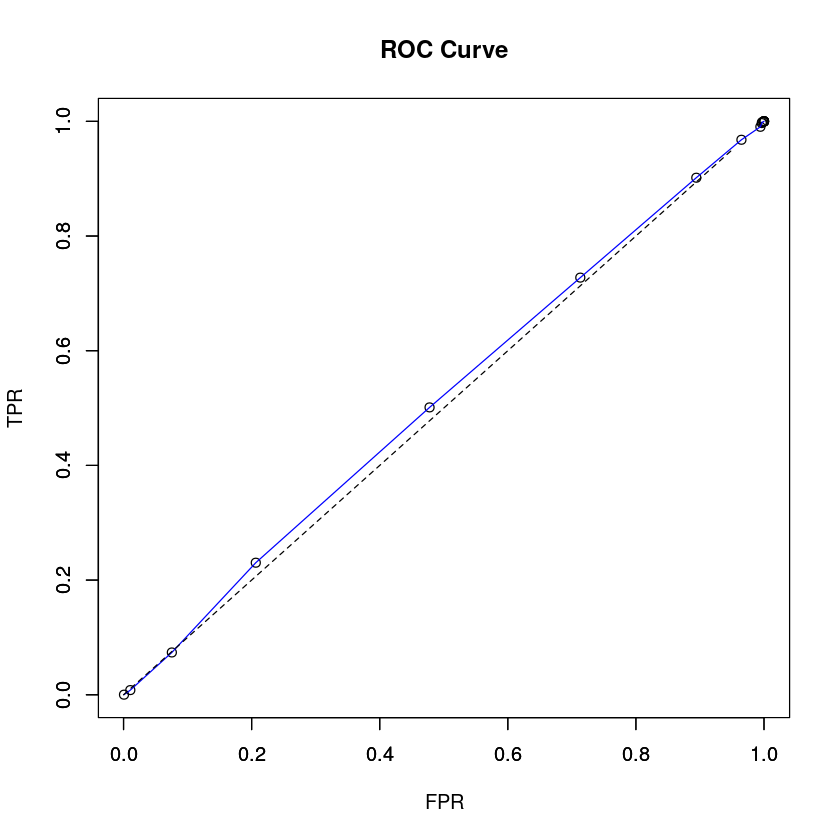

In [125]:
eval_RF_hn <- data.frame(
    RF_h1n1=evaluative_matrix(Y_RF_pred,Y_RF_real),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)
eval_RF_hn
Y_RF_prob <- data.frame(data.frame(p)$X1)
get_roc(Y_RF_prob,Y_RF_real,"h1n1","nonh1n1")

For the case of the RF, we observe that the prediction capability of our model is like a random classifier which means that our model is less accurate than DT. Usually RF perform better in terms of accuracy than DT since the main advantage of DT is its interpretability.

we observe a good Accuracy value of around 78% but the FPR is equal to 67%. This can be justified to the distribution of the predictor that was used to train on. Since the Independent variable in the case of h1n1 vaccine consisted of 1/5 of the data while for the case of nonh1n1 vaccine it was 1/4.

#### seasonal

In [126]:
set.seed(1)
data_real_RF_seasonal = YYYY_ss_test
data_train_Y_RF_seasonal = YYYY_ss_train
data_train_RF_seasonal <- subset(data_seasonal_train, select=-seasonal_vaccine)
data_test_RF_seasonal <- data_seasonal_test

In [127]:
rf <- randomForest( data_train_RF_seasonal, as.factor( data_train_Y_RF_seasonal$seasonal_vaccine ), ntree = 150, do.trace = 10 )  # mtry = nvars
p <- predict( rf, data_test_RF_seasonal, type = 'prob' )

ntree      OOB      1      2
   10:  49.08% 40.35% 59.12%
   20:  49.63% 39.79% 60.97%
   30:  49.37% 38.55% 61.85%
   40:  49.16% 37.99% 62.04%
   50:  48.87% 36.98% 62.57%
   60:  48.89% 36.56% 63.10%
   70:  48.57% 35.49% 63.65%
   80:  48.27% 34.42% 64.22%
   90:  48.43% 34.20% 64.84%
  100:  48.82% 34.50% 65.33%
  110:  48.52% 33.91% 65.35%
  120:  48.55% 33.79% 65.56%
  130:  48.55% 33.34% 66.08%
  140:  48.36% 33.13% 65.91%
  150:  48.32% 32.85% 66.16%


In [128]:
Y_RF_pred_seasonal = data.frame(p)
Y_RF_pred_seasonal$seasonal = ifelse(Y_RF_pred_seasonal$X0>0.5,0,1)
Y_RF_pred_seasonal <- ifelse(Y_RF_pred_seasonal$seasonal==1,"seasonal","nonseasonal")

In [129]:
Y_RF_real_seasonal = ifelse(data_real_RF_seasonal$seasonal_vaccine==1,"seasonal","nonseasonal")

,RF_seasonal
,<dbl>
Acc,0.5261345
F1,0.4072686
TPR,0.4923007
FPR,0.4571493


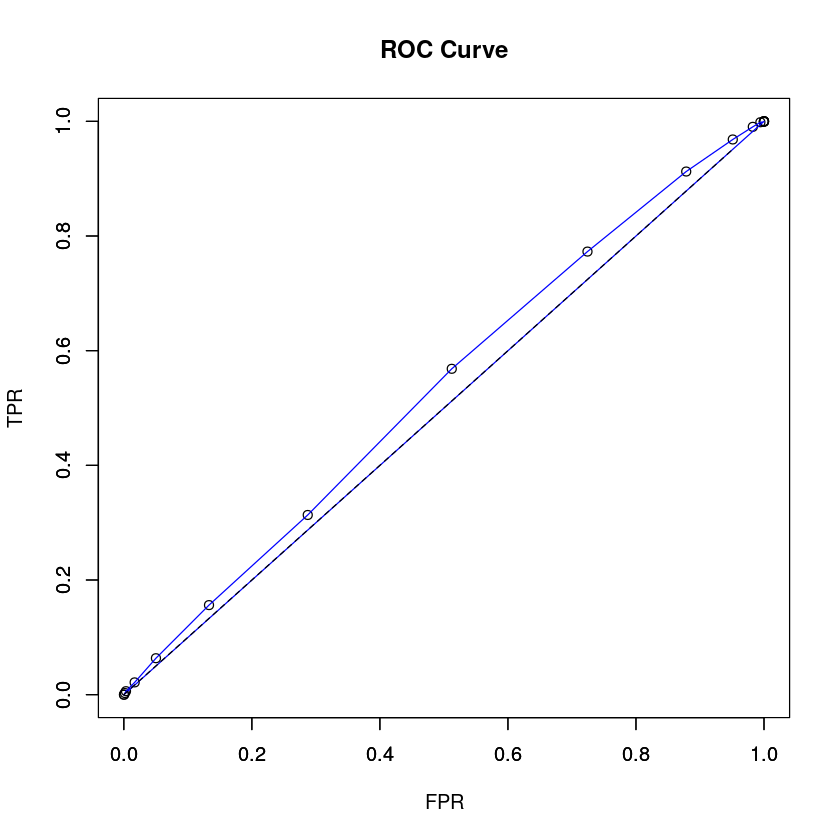

In [130]:
eval_RF_ss <- data.frame(
    RF_seasonal=evaluative_matrix(Y_RF_pred_seasonal,Y_RF_real_seasonal),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)
eval_RF_ss
Y_RF_prob_seasonal <- data.frame(data.frame(p)$X1)
get_roc(Y_RF_prob_seasonal,Y_RF_real_seasonal,"seasonal","nonseasonal")

For the case of the RF with seasonal vaccine prediciton, The prediction capability of our model is the same a randomly predicting and in some cases worse. The accuracy is lower then with h1n1 but the FPR is about half.

## Model selection

In this section we are going to compare the ROC curves and the evaluation metrics of the three models above for both the h1n1 vaccine prediction and seasonal vaccine prediction. The ROC curves of the models for the h1n1 vaccine are drawn in the same graph below.

In [131]:
#Getting the data for the curves for each of the models
roc1 <- get_roc(Y_RF_prob,Y_RF_real,"h1n1","nonh1n1",F)
roc2 <- get_roc(Y_DT_pred,Y_DT_real,"h1n1","nonh1n1",F)
roc3 <- get_roc(Y_NN_pred,Y_NN_real,"h1n1","nonh1n1",F)
roc4 <- get_roc(Y_RF_prob_seasonal,Y_RF_real_seasonal,"seasonal","nonseasonal",F)
roc5 <- get_roc(Y_DT_pred_seasonal,Y_DT_real_seasonal,"seasonal","nonseasonal",F)
roc6 <- get_roc(Y_NN_pred_seasonal,Y_NN_real_seasonal,"seasonal","nonseasonal",F)
colors <- c("red", "green", "blue")

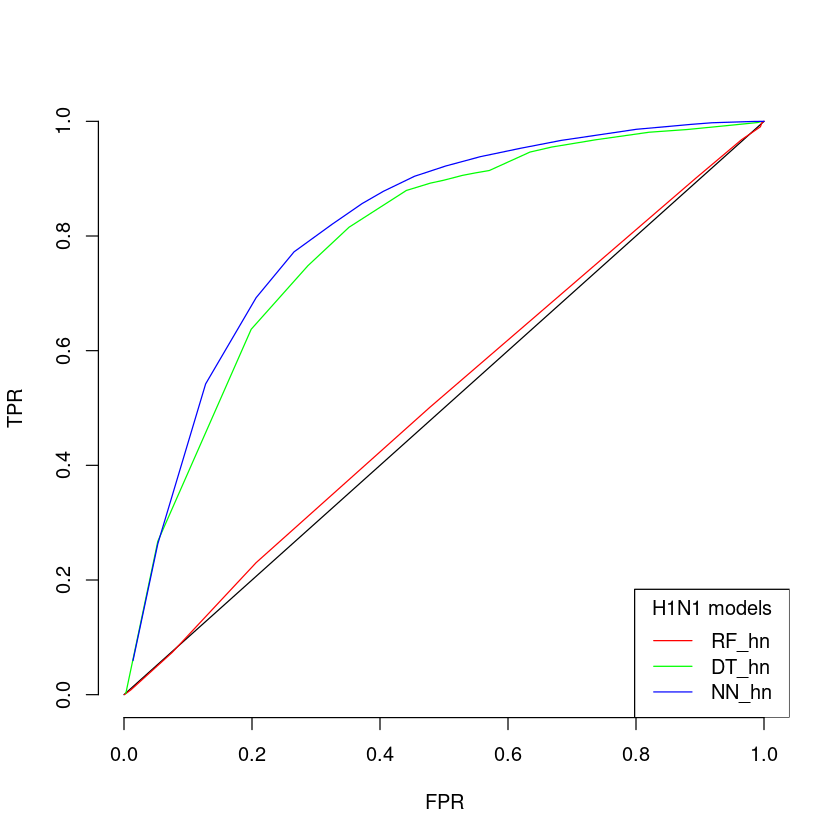

In [132]:
#Drawing the plot
plot(c(0,1), c(0,1), type = 'l', xlab = "FPR", ylab = "TPR", axes = F)
lines(roc1$fpr, roc1$tpr,type = 'l', col = colors[1])
lines(roc2$fpr, roc2$tpr,type = 'l', col = colors[2])
lines(roc3$fpr, roc3$tpr,type = 'l', col = colors[3])
model_names = c('RF_hn','DT_hn','NN_hn')
legend("bottomright", legend = model_names, col = colors,  lty = 1, title = "H1N1 models")
axis(1, at=seq(from = 0, to = 1, by = 0.2))
axis(2, at=seq(from = 0, to = 1, by = 0.2))

As we can see the neural network model is clearly the best one in terms of the ROC curve. The decision tree model is close in its accuracy to the neural network but random forest has much worse performance as the other two models.

In [133]:
data.frame(
    RF_h1n1=eval_RF_hn$RF_h1n1,
    DT_h1n1=eval_DT_hn$DT_h1n1,
    NN_h1n1=eval_NN_hn$NN_h1n1,
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

,RF_h1n1,DT_h1n1,NN_h1n1
,<dbl>,<dbl>,<dbl>
Acc,0.7868803,0.8111427,0.8331586
F1,0.8806508,0.8840460,0.8985613
TPR,0.7876969,0.8557949,0.8619846
FPR,0.6666667,0.4254717,0.3399790


When comparing the other evaluation metrics, we can see that neaural net outperforms the other models in all metrics. 

Therefore, based on the evaluation metrics and ROC curves we have decided to select neural network as the learning model for predicting the h1n1 vaccines.

The ROC curves of the models for the seasonal vaccine prediction are drawn in the same graph below.

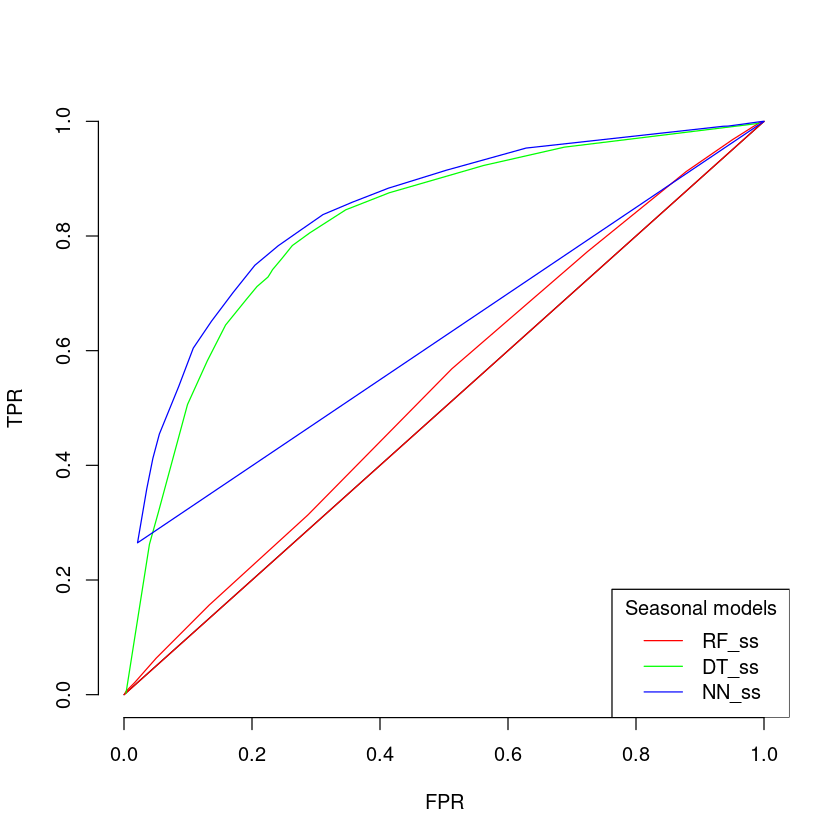

In [134]:
plot(c(0,1), c(0,1), type = 'l', xlab = "FPR", ylab = "TPR", axes = F)
lines(roc4$fpr, roc4$tpr,type = 'l', col = colors[1])
lines(roc5$fpr, roc5$tpr,type = 'l', col = colors[2])
lines(roc6$fpr, roc6$tpr,type = 'l', col = colors[3])
model_names = c('RF_ss','DT_ss','NN_ss')
legend("bottomright", legend = model_names, col = colors,  lty = 1, title = "Seasonal models")
axis(1, at=seq(from = 0, to = 1, by = 0.2))
axis(2, at=seq(from = 0, to = 1, by = 0.2))

As we can see the neural network model is clearly the best model in terms of the ROC curve for seasonal vaccine prediction as well. The decision tree model is close in its accuracy to the neural network but random forest has again much worse performance as the other two models.

In [135]:
data.frame(
    NN_seasonal=eval_NN_ss$NN_seasonal,
    DT_seasonal=eval_DT_ss$DT_seasonal,
    RF_seasonal=eval_RF_ss$RF_seasonal,
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

,NN_seasonal,DT_seasonal,RF_seasonal
,<dbl>,<dbl>,<dbl>
Acc,0.7737008,0.7545305,0.5261345
F1,0.7562510,0.7377180,0.4072686
TPR,0.7637667,0.7390189,0.4923007
FPR,0.2178492,0.2318718,0.4571493


When comparing the other evaluation metrics, we can again see that neaural net outperforms the other models in all metrics. 

Therefore, based on the evaluation metrics and ROC curves we have decided to select neural network as the learning model for predicting the seasonal vaccines as well.

In the next section we are going to implement another learning model and compare its performance to the neural network model for both h1n1 and seasonal vaccine prediction. We will choose the final learning model for both cases between the two.

# Alternative model





For the third part of the project, we chose gradient boosting as our classification model. We are using the same features that were chosen in the feature selection section of the project. The R library that we are using for the gradient boosting is xgboost.

Unfortunately, due to a bug somewhere in the code, we were not able to use the same data variables for xgboost as for the other models. The data used for the h1n1 prediction is defined below.

In [136]:
set.seed(1)
smp_size <- floor(0.75 * nrow(data))

train_ind_ <- sample(seq_len(nrow(data)), size = smp_size)

X_train <- subset(data_h1n1[train_ind_, ],select=-respondent_id)#
X_test <- subset(data_h1n1[-train_ind_, ],select=-respondent_id)
y_train <- labels[train_ind_,"h1n1_vaccine"]
y_test <- labels[-train_ind_,"h1n1_vaccine"]

We are setting the initial parameters of xgboost as the defaults, and we will be later tuning them to better fit our data. Since we are solving a classification problem, we are using logloss as the eval_metric, binary:logistic as objective and gbtree as booster. 

In [137]:
xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = y_train)
xgb_test <- xgb.DMatrix(data = as.matrix(X_test), label = y_test)
xgb_params <- list(
    booster = "gbtree",
    eta = 0.03,
    max_depth = 6,
    gamma = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    objective = "binary:logistic",
    eval_metric = "logloss"
)

First, we tune the gamma parameter. We give 5 alternatives for the value of gamma and run xgboost’s built-in cross validation algorithm to find the gamma that minimizes the mean test error of the model.

In [138]:
gamma <- c(0.1,1,2,5,10)
gamma_errors <- c()


for (i in (1:length(gamma))) {
    xgb_params$gamma <- gamma[i]
    xgb <- xgb.cv(
        params = xgb_params,
        data = xgb_train,
        nrounds = 100,
        nfold = 5,
        showsd = T,
        stratified = T,
        print_every_n = 20,
        early_stopping_rounds = 20,
        maximize = F,
        verbose=0
    )
    gamma_errors[i] <- min(xgb$evaluation_log$test_logloss_mean)
}
gamma_errors
best_gamma <- gamma[which.min(gamma_errors)]

[1] 0.3858791 0.3856284 0.3862799 0.3861277 0.3891608

In [139]:
xgb_params$gamma <- best_gamma

Next, we tune the eta parameter in the same way.

In [140]:
eta <- c(0.01,0.1,0.2,0.5,1)
eta_errors <- c()

for (i in (1:length(eta))) {
    xgb_params$eta <- eta[i]
    xgb <- xgb.cv(
        params = xgb_params,
        data = xgb_train,
        nrounds = 100,
        nfold = 5,
        showsd = T,
        stratified = T,
        print_every_n = 20,
        early_stopping_rounds = 20,
        maximize = F,
        verbose=0
    )
    eta_errors[i] <- min(xgb$evaluation_log$test_logloss_mean)
}
eta_errors
best_eta <- eta[which.min(eta_errors)]

[1] 0.4507951 0.3816469 0.3828565 0.3857450 0.3922243

In [141]:
xgb_params$eta <- best_eta

And finally, the colsample_bytree parameter.

In [142]:
cs=c(3/6,4/6,5/6,1)
cs_errors <- c()

for (i in (1:length(cs))) {
    xgb_params$colsample_bytree <- cs[i]
    xgb <- xgb.cv(
        params = xgb_params,
        data = xgb_train,
        nrounds = 100,
        nfold = 5,
        showsd = T,
        stratified = T,
        print_every_n = 20,
        early_stopping_rounds = 20,
        maximize = F,
        verbose=0
    )
    cs_errors[i] <- min(xgb$evaluation_log$test_logloss_mean)
}
cs_errors
best_cs <- cs[which.min(cs_errors)]

[1] 0.3800405 0.3811891 0.3824388 0.3827174

In [143]:
xgb_params$colsample_bytree <- best_cs

We run the cross validation algorithm once more to find the best value for the nrounds parameter. The value that is chosen will be the number of the iteration that minimizes the mean logloss error.

In [144]:
xgbcv <- xgb.cv(
    params = xgb_params,
    data = xgb_train,
    nrounds = 3000,
    nfold = 5,
    showsd = T,
    stratified = T,
    print_every_n = 20,
    early_stopping_rounds = 20,
    maximize = F
)
best_iteration <- match(min(xgbcv$evaluation_log$test_logloss_mean),xgbcv$evaluation_log$test_logloss_mean)

[1]	train-logloss:0.648266+0.004056	test-logloss:0.649373+0.004768 
Multiple eval metrics are present. Will use test_logloss for early stopping.
Will train until test_logloss hasn't improved in 20 rounds.

[21]	train-logloss:0.389946+0.003103	test-logloss:0.404727+0.005735 
[41]	train-logloss:0.355079+0.001766	test-logloss:0.383276+0.007443 
[61]	train-logloss:0.338951+0.001635	test-logloss:0.380407+0.007634 
[81]	train-logloss:0.327267+0.001518	test-logloss:0.380736+0.007418 
Stopping. Best iteration:
[68]	train-logloss:0.334535+0.001660	test-logloss:0.380102+0.007609



The model is trained using the parameters chosen above as well as the nrounds that was found to be the best and the model is used to predict the values for the h1n1 test data.

In [145]:
xgb_model <- xgb.train(
  params = xgb_params,
  data = xgb_train,
  nrounds = best_iteration,
  verbose = 1
)
xgb_model

##### xgb.Booster
raw: 314.9 Kb 
call:
  xgb.train(params = xgb_params, data = xgb_train, nrounds = best_iteration, 
    verbose = 1)
params (as set within xgb.train):
  booster = "gbtree", eta = "0.1", max_depth = "6", gamma = "1", subsample = "1", colsample_bytree = "0.5", colsample_bylevel = "1", objective = "binary:logistic", eval_metric = "logloss", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
# of features: 24 
niter: 68
nfeatures : 24 

In [146]:
xgb_preds <- predict(xgb_model, as.matrix(X_test), reshape = TRUE)
xgb_preds <- as.data.frame(xgb_preds)

We are adding the predicted classes and the actual classes as columns to the predicted dataframe and calculating the evaluation metrics based on those.

In [147]:
xgb_preds$predicted_class <- apply(xgb_preds, 1, function(y) as.numeric(y > 0.5))                       

xgb_preds$actual_class <- c(0,1)[y_test + 1]
                                   
preds <- xgb_preds$predicted_class
real <- xgb_preds$actual_class
                                   
preds <- ifelse(preds == 1, "h1n1", "nonh1n1")
real <- ifelse(real == 1, "h1n1", "nonh1n1")

In [148]:
data.frame(
    XGB_h1n1=evaluative_matrix(preds, real),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

,XGB_h1n1
,<dbl>
Acc,0.8409465
F1,0.9036298
TPR,0.8641097
FPR,0.3049180


The accuracy of the model is around 84% which is decent and the false positive rate around 30%. The moderately high false positive rate was is likely due to the imbalance in the h1n1 vaccine classes.

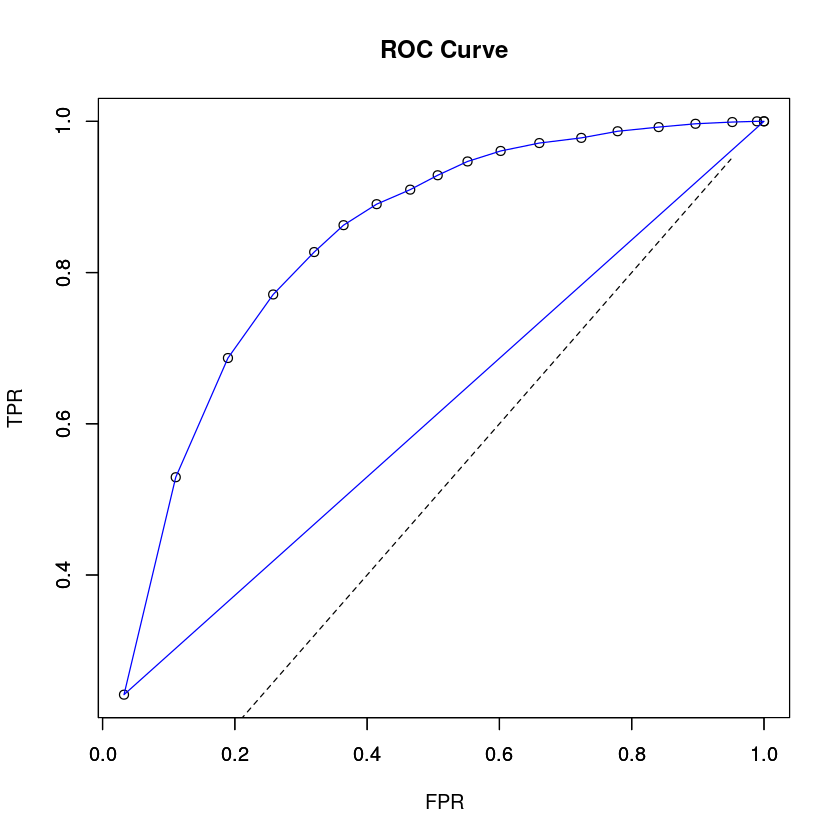

In [149]:
get_roc(xgb_preds$xgb_pred,real,"h1n1","nonh1n1")

The same error is present in the curve as in the neural net model. Nevertheless, we can see that the curve is very good for the model which indicates high predictivie accuracy of the model.

#### seasonal

We do the same parameter tuning, learning and prediction procedure for the seasonal vaccine data as we did for h1n1 data above.

In [150]:
set.seed(1)
smp_size <- floor(0.75 * nrow(data))

train_ind_ <- sample(seq_len(nrow(data)), size = smp_size)

X_train_seasonal <- subset(data_seasonal[train_ind_, ],select=-respondent_id)
X_test_seasonal <- subset(data_seasonal[-train_ind_, ],select=-respondent_id)
y_train_seasonal <- labels[train_ind_,"seasonal_vaccine"]
y_test_seasonal <- labels[-train_ind_,"seasonal_vaccine"]

In [151]:
set.seed(1)
xgb_train_seasonal <- xgb.DMatrix(data = as.matrix(X_train_seasonal), label = y_train_seasonal)
xgb_test_seasonal <- xgb.DMatrix(data = as.matrix(X_test_seasonal), label = y_test_seasonal)
xgb_params_seasonal <- list(
    booster = "gbtree",
    eta = 0.03,
    max_depth = 6,
    gamma = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    objective = "binary:logistic",
    eval_metric = "logloss"
)

In [152]:
gamma <- c(0.1,1,2,5,10)
gamma_errors <- c()


for (i in (1:length(gamma))) {
    xgb_params_seasonal$gamma <- gamma[i]
    xgb <- xgb.cv(
        params = xgb_params_seasonal,
        data = xgb_train_seasonal,
        nrounds = 100,
        nfold = 5,
        showsd = T,
        stratified = T,
        print_every_n = 20,
        early_stopping_rounds = 20,
        maximize = F,
        verbose=0
    )
    #print(xgb$evaluation_log)
    gamma_errors[i] <- min(xgb$evaluation_log$test_logloss_mean)
}
gamma_errors
best_gamma <- gamma[which.min(gamma_errors)]

[1] 0.4808630 0.4808738 0.4794509 0.4815427 0.4848478

In [153]:
xgb_params_seasonal$gamma <- best_gamma

In [154]:
eta <- c(0.01,0.1,0.2,0.5,1)
eta_errors <- c()

for (i in (1:length(eta))) {
    xgb_params_seasonal$eta <- eta[i]
    xgb <- xgb.cv(
        params = xgb_params_seasonal,
        data = xgb_train_seasonal,
        nrounds = 100,
        nfold = 5,
        showsd = T,
        stratified = T,
        print_every_n = 20,
        early_stopping_rounds = 20,
        maximize = F,
        verbose=0
    )
    #print(xgb$evaluation_log)
    eta_errors[i] <- min(xgb$evaluation_log$test_logloss_mean)
}
eta_errors
best_eta <- eta[which.min(eta_errors)]

[1] 0.5294124 0.4749593 0.4762089 0.4837522 0.4929530

In [155]:
xgb_params_seasonal$eta <- best_eta

In [156]:
cs=c(3/6,4/6,5/6,1)
cs_errors <- c()

for (i in (1:length(cs))) {
    xgb_params_seasonal$colsample_bytree <- cs[i]
    xgb <- xgb.cv(
        params = xgb_params_seasonal,
        data = xgb_train_seasonal,
        nrounds = 100,
        nfold = 5,
        showsd = T,
        stratified = T,
        print_every_n = 20,
        early_stopping_rounds = 20,
        maximize = F,
        verbose=0
    )
    #print(xgb$evaluation_log)
    cs_errors[i] <- min(xgb$evaluation_log$test_logloss_mean)
}
cs_errors
best_cs <- cs[which.min(cs_errors)]

[1] 0.4725662 0.4748315 0.4763685 0.4753276

In [157]:
xgb_params_seasonal$colsample_bytree <- best_cs

In [158]:
xgbcv <- xgb.cv(
    params = xgb_params_seasonal,
    data = xgb_train_seasonal,
    nrounds = 3000,
    nfold = 5,
    showsd = T,
    stratified = T,
    print_every_n = 20,
    early_stopping_rounds = 20,
    maximize = F
)
best_iteration <- match(min(xgbcv$evaluation_log$test_logloss_mean),xgbcv$evaluation_log$test_logloss_mean)

[1]	train-logloss:0.670459+0.006505	test-logloss:0.671780+0.006458 
Multiple eval metrics are present. Will use test_logloss for early stopping.
Will train until test_logloss hasn't improved in 20 rounds.

[21]	train-logloss:0.483948+0.002436	test-logloss:0.499889+0.005113 
[41]	train-logloss:0.449620+0.001255	test-logloss:0.479112+0.004692 
[61]	train-logloss:0.434858+0.001294	test-logloss:0.475460+0.004292 
[81]	train-logloss:0.424661+0.001038	test-logloss:0.475028+0.004492 
Stopping. Best iteration:
[68]	train-logloss:0.431039+0.001239	test-logloss:0.474926+0.004287



In [159]:
xgb_model_seasonal <- xgb.train(
  params = xgb_params_seasonal,
  data = xgb_train_seasonal,
  nrounds = best_iteration,
  verbose = 1
)
xgb_model_seasonal

##### xgb.Booster
raw: 322.2 Kb 
call:
  xgb.train(params = xgb_params_seasonal, data = xgb_train_seasonal, 
    nrounds = best_iteration, verbose = 1)
params (as set within xgb.train):
  booster = "gbtree", eta = "0.1", max_depth = "6", gamma = "2", subsample = "1", colsample_bytree = "0.5", colsample_bylevel = "1", objective = "binary:logistic", eval_metric = "logloss", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
# of features: 24 
niter: 68
nfeatures : 24 

In [160]:
xgb_preds_seasonal <- predict(xgb_model_seasonal, as.matrix(X_test_seasonal), reshape = TRUE)
xgb_preds_seasonal <- as.data.frame(xgb_preds_seasonal)

In [161]:
xgb_preds_seasonal$predicted_class <- apply(xgb_preds_seasonal, 1, function(y) as.numeric(y > 0.5))                     

xgb_preds_seasonal$actual_class <- c(0,1)[y_test_seasonal + 1]
                                   
preds_seasonal <- xgb_preds_seasonal$predicted_class
real_seasonal <- xgb_preds_seasonal$actual_class
                                   
preds_seasonal <- ifelse(preds_seasonal == 1, "seasonal", "nonseasonal")
real_seasonal <- ifelse(real_seasonal == 1, "seasonal", "nonseasonal")

In [162]:
data.frame(
    XGB_seasonal=evaluative_matrix(preds_seasonal, real_seasonal),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

,XGB_seasonal
,<dbl>
Acc,0.7802905
F1,0.7604116
TPR,0.7778149
FPR,0.2176982


The evaluation metrics for the seasonal vaccine case are good as well. The accuracy is lower in the seasonal vaccine case, which is to be expected as the vaccine classes are more balanced. We can also see that the false positive rate is significantly lower for the seasonal vaccine case.

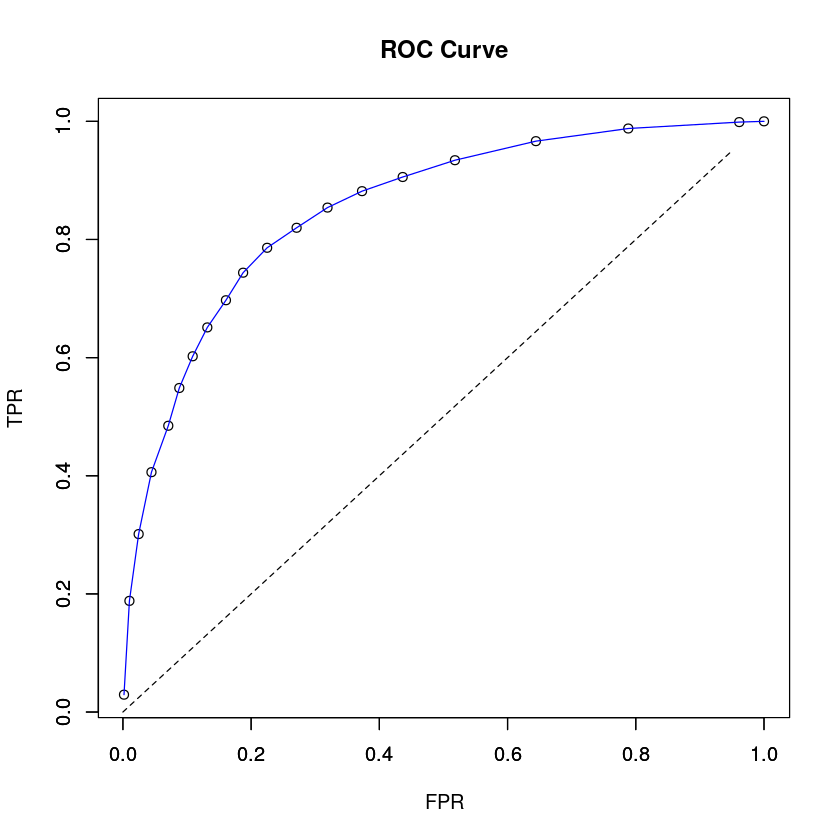

In [163]:
get_roc(xgb_preds_seasonal$xgb_preds_seasonal,real_seasonal,"seasonal","nonseasonal")

The bug that was present in the h1n1 ROC curve is not present in the seasonal vaccine case. When comparing the curves visually, we can see that the seasonal vaccine model is not quite as good as the h1n1 model, but still has good predictive accruacy.

## Choosing the model

In this section we are going to compare the ROC curves and the evaluation metrics of the neural net and the xgboost model for both the h1n1 vaccine and seasonal vaccine prediction. The ROC curves of the models for the h1n1 vaccine are drawn in the same graph below.

In [164]:
#Getting the data for the curves for each of the models
roc1=get_roc(Y_NN_pred,Y_NN_real,"h1n1","nonh1n1",F)
roc2=get_roc(xgb_preds$xgb_pred,real,"h1n1","nonh1n1",F)
roc3= get_roc(Y_NN_pred_seasonal,Y_NN_real_seasonal,"seasonal","nonseasonal",F)
roc4=get_roc(xgb_preds_seasonal$xgb_preds_seasonal,real_seasonal,"seasonal","nonseasonal",F)
colors <- c("red", "green")

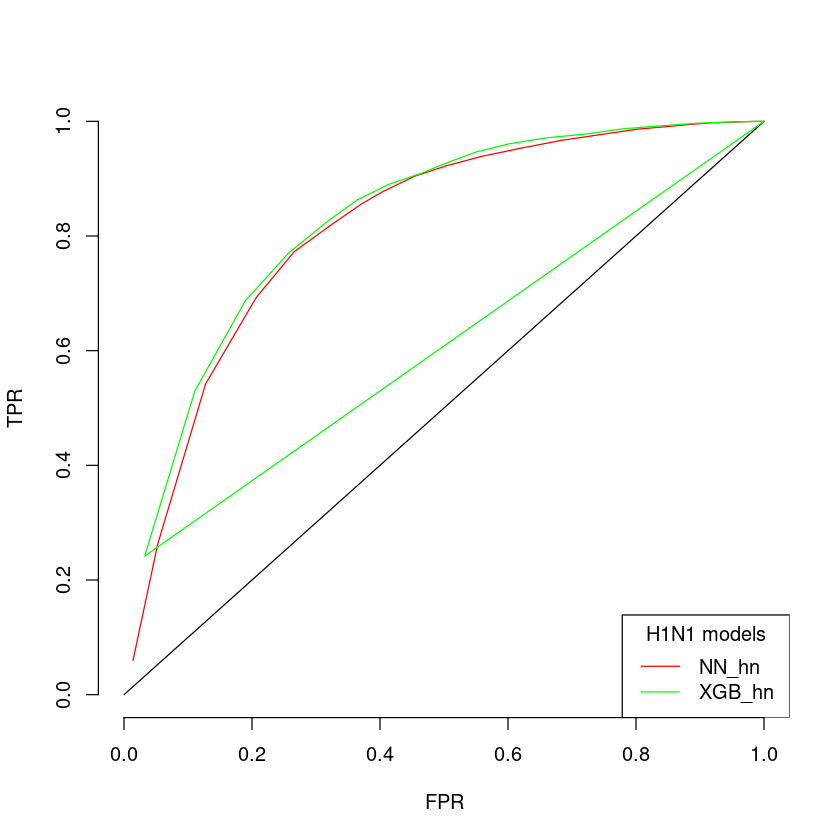

In [165]:
#Drawing the plot
plot(c(0,1), c(0,1), type = 'l', xlab = "FPR", ylab = "TPR", axes = F)
lines(roc1$fpr, roc1$tpr,type = 'l', col = colors[1])
lines(roc2$fpr, roc2$tpr,type = 'l', col = colors[2])
model_names = c('NN_hn','XGB_hn')
legend("bottomright", legend = model_names, col = colors,  lty = 1, title = "H1N1 models")
axis(1, at=seq(from = 0, to = 1, by = 0.2))
axis(2, at=seq(from = 0, to = 1, by = 0.2))

Comparing the ROC curves for the neaural net and the gradient boost model, we can see that the predictive power of the models is very similar but the xgboost is slightly better.

In [166]:
data.frame(
    XGB_h1n1=evaluative_matrix(preds, real),
    NN_h1n1=evaluative_matrix(Y_NN_remodled ,Y_NN_real),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

,XGB_h1n1,NN_h1n1
,<dbl>,<dbl>
Acc,0.8409465,0.8331586
F1,0.9036298,0.8985613
TPR,0.8641097,0.8619846
FPR,0.3049180,0.3399790


When comparing the other metrics, we can see that the xgboost model sightly outperforms neural net. Therefore, based on the ROC curve and the evaluation metrics, we have selected the xgboost model as the final model for predicting the h1n1 data and will be submitting the predictions made with it to the competition.

Next, we are comparing the ROC curves for the seasonal vaccine models, they are drawn below.

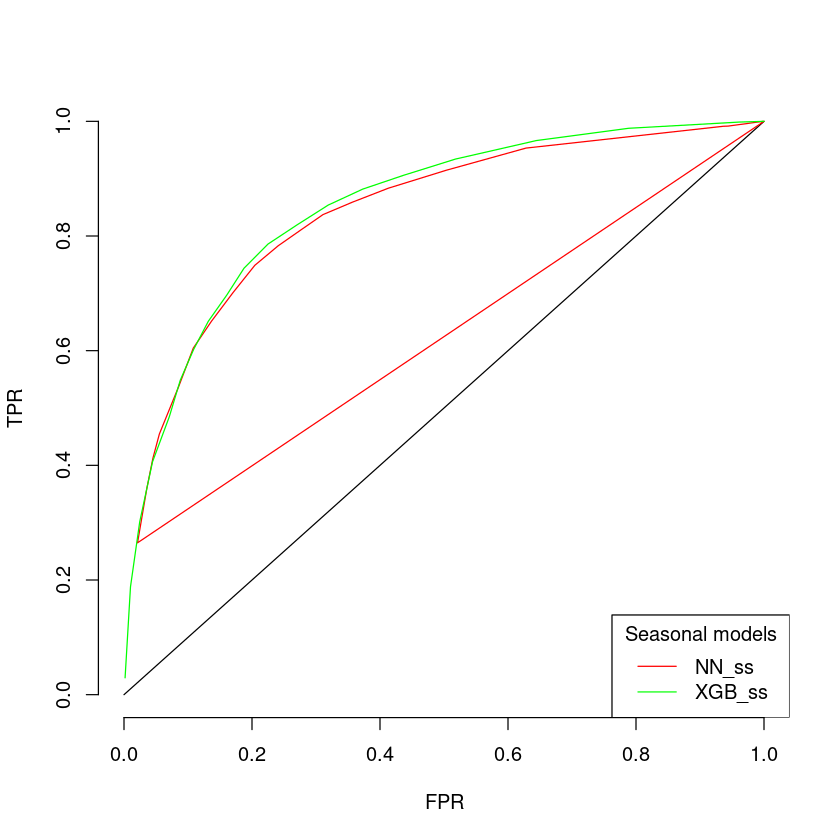

In [167]:
#Drawing the plot
plot(c(0,1), c(0,1), type = 'l', xlab = "FPR", ylab = "TPR", axes = F)
lines(roc3$fpr, roc3$tpr,type = 'l', col = colors[1])
lines(roc4$fpr, roc4$tpr,type = 'l', col = colors[2])
model_names = c('NN_ss','XGB_ss')
legend("bottomright", legend = model_names, col = colors,  lty = 1, title = "Seasonal models")
axis(1, at=seq(from = 0, to = 1, by = 0.2))
axis(2, at=seq(from = 0, to = 1, by = 0.2))

Now, the curve for xgboost is slightly better than for neural network but the predictive accuracy is still similar.

In [168]:
data.frame(
    XGB_seasonal=evaluative_matrix(preds_seasonal, real_seasonal),
    NN_seasonal=evaluative_matrix(Y_NN_remodled_seasonal, Y_NN_real_seasonal),
    row.names=c('Acc', 'F1', 'TPR', 'FPR')
)

,XGB_seasonal,NN_seasonal
,<dbl>,<dbl>
Acc,0.7802905,0.7737008
F1,0.7604116,0.7562510
TPR,0.7778149,0.7637667
FPR,0.2176982,0.2178492


We see that xgboost again slighty outperforms neural net in the other metrics. Therefore, based on the metrics and the curves, we have selected xgboost as the final model for the seasonal vaccine prediction and will be submitting the predictions made with it to the competition.

# Compiling the data for the competition

Below is the code used to get the final results for the competition commented out. 

In [174]:
#competition_data <- read.csv("./test_set_features.csv")

#competition_data <- data.frame(lapply(competition_data, function(x) ifelse(x == '', NA, x)))

#transforming character class columns to integers
#competition_data <- data.frame(lapply(competition_data, function(x) if(class(x)=="character") { as.factor(x) } else { x } ))
#competition_data <- data.frame(lapply(competition_data, function(x) if(class(x)=="factor") { as.numeric(x) } else { x } ))
                                      
#ncol(competition_data)
#competition_data <- competition_data[,which(colMeans(!is.na(competition_data))>.9)]
#ncol(competition_data) 
                                      
#competition_data<-data.frame(apply(competition_data,2,function(x) ifelse(is.na(x),calc_mode(x),x)))

#competition_data_h1n1 <- subset(competition_data, select = -c(behavioral_avoidance, behavioral_wash_hands, hhs_geo_region, opinion_h1n1_sick_from_vacc, behavioral_touch_face, behavioral_outside_home, household_adults))
#competition_data_seasonal <- subset(competition_data, select = -c(opinion_h1n1_vacc_effective, sex, behavioral_face_mask, h1n1_concern, employment_status, hhs_geo_region, behavioral_antiviral_meds)) 

#X_competition_seasonal <- subset(competition_data_seasonal,select=-respondent_id)
#X_competition_h1n1 <- subset(competition_data_h1n1,select=-respondent_id)

#xgb_preds_seasonal_competition <- predict(xgb_model_seasonal, as.matrix(X_competition_seasonal), reshape = TRUE)
#xgb_preds_h1n1_competition <- predict(xgb_model, as.matrix(X_competition_h1n1), reshape = TRUE)

#final_predictions <- data.frame(
#    respondent_id=competition_data$respondent_id,
#    h1n1_vaccine=xgb_preds_h1n1_competition,
#    seasonal_vaccine=xgb_preds_seasonal_competition
#)
#write.csv(final_predictions,"./final_predictions.csv", row.names = FALSE)

# Conclusions

Throughout our analysis, we managed to detect the variables that have significance influence on the decision of resident on whether taking the h1n1 vaccine or not taking the vaccine(seasonal/non seasonal).

We started by transforming the categorical features into numerical features, followed by replacing the missing values by selecting the most frequent value (we also predicted the values using DT). After cleaning our data, we move to feature selection where we use the methods of correlation with the output and mRMR and forward selection to test and compare which of these methods provided the best selection of features. the most appropriate method for our data was the forward selection (an wrapper method).

We have  configured multiple learning models that predict the independent variable and compared them using performance metrics such as the ROC, accuracy. We conclude that among the first models we had (NN, RF, DT) the NN performed the best due to it's ability to fit parameters that transform the input and the activation of the following neurons and handling complex data, while DT fit parameters explicitly fit parameters to the information flow. Same for RF as it's a collection of DT. the limitation in the results was compensated by the interpret-ability that DT provides into our data. 

At a second time, we compared our best performer model NN to an alternative model Xgboost. We used Xgbost because of it's performance when handling mixed feature type like in our case. Our result was that Xgboost did perform slightly better then the NN.


# References : 

 [1] : https://www.drivendata.org/competitions/66/flu-shot-learning/
 
 [2] : https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/
 
 [3] : http://www.sthda.com/french/wiki/ggplot2-barplots-guide-de-demarrage-rapide-logiciel-r-et-visualisation-de-donnees
 
 [4] : https://ggplot2.tidyverse.org/reference/ 